# Tiền Xử Lý Dữ Liệu (EDA) (Đồ Án 1)

In [ ]:
import polars as pl
import glob
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import polars.selectors as cs
import numpy as np
import pandas as pd
import scipy.stats as ss
import matplotlib.ticker as mtick
from scipy.stats import chi2_contingency
from IPython.display import display
from sklearn.preprocessing import RobustScaler
import os
import zipfile
import polars.selectors as cs
import time
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

!pip install -q gdown polars pyarrow
import gdown
pl.Config.set_tbl_cols(-1)

import warnings
warnings.filterwarnings("ignore")

## Upload data

In [ ]:

file_id = "1QfwJWqadsnUYd6WsZOMmY8TtEB7KII6n"  # ID thật của dataset
url = f"https://drive.google.com/uc?id={file_id}"

zip_path = "recommendation_dataset.zip"
extract_path = "./dataset"

# Tải file zip từ Google Drive (thêm fuzzy để tự động sửa link)
gdown.download(url, zip_path, quiet=False, fuzzy=True)

# Giải nén file zip
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Giải nén xong. Các thư mục có trong dataset:")
print(os.listdir(extract_path))

# ============================================================
# Tải các file parquet vào LazyFrame
# ============================================================
# Tự động nhận đúng đường dẫn trong thư mục sau khi giải nén
purchase_files = sorted(glob.glob(os.path.join(extract_path, "sales_pers.purchase_history_daily_chunk_*.parquet")))
user_files     = sorted(glob.glob(os.path.join(extract_path, "sales_pers.user_chunk_*.parquet")))
item_files     = sorted(glob.glob(os.path.join(extract_path, "sales_pers.item_chunk_*.parquet")))

# Kiểm tra xem có file nào không
print(f"Purchase files: {len(purchase_files)}")
print(f"User files: {len(user_files)}")
print(f"Item files: {len(item_files)}")

# Dùng lazy loading để load nhanh
lf_purchases = pl.concat([pl.scan_parquet(f) for f in purchase_files])
lf_users     = pl.concat([pl.scan_parquet(f) for f in user_files])
lf_items     = pl.concat([pl.scan_parquet(f) for f in item_files])

print("\nDataset đã load vào LazyFrames thành công!")
print("• lf_purchases:", lf_purchases.collect_schema().names())
print("• lf_users:", lf_users.collect_schema().names())
print("• lf_items:", lf_items.collect_schema().names())

Downloading...
From (original): https://drive.google.com/uc?id=1QfwJWqadsnUYd6WsZOMmY8TtEB7KII6n
From (redirected): https://drive.google.com/uc?id=1QfwJWqadsnUYd6WsZOMmY8TtEB7KII6n&confirm=t&uuid=5ae7aef2-1110-4757-8694-2a4196363be4
To: /content/recommendation_dataset.zip
100%|██████████| 1.73G/1.73G [00:11<00:00, 146MB/s]


Giải nén xong. Các thư mục có trong dataset:
['sales_pers.purchase_history_daily_chunk_23.parquet', 'sales_pers.purchase_history_daily_chunk_48.parquet', 'sales_pers.purchase_history_daily_chunk_34.parquet', 'sales_pers.purchase_history_daily_chunk_7.parquet', 'sales_pers.purchase_history_daily_chunk_21.parquet', 'sales_pers.purchase_history_daily_chunk_71.parquet', 'sales_pers.purchase_history_daily_chunk_56.parquet', 'sales_pers.user_chunk_4.parquet', 'sales_pers.user_chunk_9.parquet', 'sales_pers.purchase_history_daily_chunk_69.parquet', 'sales_pers.purchase_history_daily_chunk_50.parquet', 'sales_pers.purchase_history_daily_chunk_65.parquet', 'sales_pers.purchase_history_daily_chunk_1.parquet', 'sales_pers.user_chunk_0.parquet', 'sales_pers.purchase_history_daily_chunk_70.parquet', 'sales_pers.purchase_history_daily_chunk_11.parquet', 'sales_pers.purchase_history_daily_chunk_24.parquet', 'sales_pers.purchase_history_daily_chunk_37.parquet', 'sales_pers.user_chunk_2.parquet', 'sales

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')
# !pip -q install polars pyarrow

# data_path = '/content/drive/MyDrive/Copy_of_recommendation_dataset'

# purchases = sorted(glob.glob(os.path.join(data_path, 'sales_pers.purchase_history_daily_chunk_*.parquet')))
# users = sorted(glob.glob(os.path.join(data_path, 'sales_pers.user_chunk_*.parquet')))
# items = sorted(glob.glob(os.path.join(data_path, 'sales_pers.item_chunk_*.parquet')))
# lf_purchases = pl.concat([pl.scan_parquet(f) for f in purchases])
# lf_users = pl.concat([pl.scan_parquet(f) for f in users])
# lf_items = pl.concat([pl.scan_parquet(f) for f in items])

Xuất mẫu 5 dòng đầu

In [ ]:
print("===lf_purchases===")
lf_purchases.collect().head(5)


===lf_purchases===


shape: (5, 16)
┌─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬────────┐
│ tim ┆ use ┆ ite ┆ eve ┆ eve ┆ pri ┆ dat ┆ qua ┆ cus ┆ cre ┆ upd ┆ cha ┆ pay ┆ loc ┆ dis ┆ is_del │
│ est ┆ r_i ┆ m_i ┆ nt_ ┆ nt_ ┆ ce  ┆ e_k ┆ nti ┆ tom ┆ ate ┆ ate ┆ nne ┆ men ┆ ati ┆ cou ┆ eted   │
│ amp ┆ d   ┆ d   ┆ typ ┆ val ┆ --- ┆ ey  ┆ ty  ┆ er_ ┆ d_d ┆ d_d ┆ l   ┆ t   ┆ on  ┆ nt  ┆ ---    │
│ --- ┆ --- ┆ --- ┆ e   ┆ ue  ┆ dec ┆ --- ┆ --- ┆ id  ┆ ate ┆ ate ┆ --- ┆ --- ┆ --- ┆ --- ┆ bool   │
│ i64 ┆ str ┆ str ┆ --- ┆ --- ┆ ima ┆ i32 ┆ i32 ┆ --- ┆ --- ┆ --- ┆ str ┆ str ┆ i32 ┆ dec ┆        │
│     ┆     ┆     ┆ str ┆ dec ┆ l[3 ┆     ┆     ┆ i32 ┆ dat ┆ dat ┆     ┆     ┆     ┆ ima ┆        │
│     ┆     ┆     ┆     ┆ ima ┆ 8,4 ┆     ┆     ┆     ┆ eti ┆ eti ┆     ┆     ┆     ┆ l[3 ┆        │
│     ┆     ┆     ┆     ┆ l[3 ┆ ]   ┆     ┆     ┆     ┆ me[ ┆ me[ ┆     ┆     ┆     ┆ 8,4 ┆        │
│     ┆     ┆     ┆     ┆ 8,4 ┆     ┆     ┆     ┆     ┆ μs] ┆ μs] ┆     ┆     ┆     ┆ ]   ┆        │
│     ┆     ┆     ┆     ┆ ]   ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆        │
╞═════╪═════╪═════╪═════╪═════╪═════╪═════╪═════╪═════╪═════╪═════╪═════╪═════╪═════╪═════╪════════╡
│ 173 ┆ ca1 ┆ 711 ┆ Pur ┆ 1.0 ┆ 490 ┆ 202 ┆ 1   ┆ 525 ┆ 202 ┆ 202 ┆ In- ┆ Vie ┆ 656 ┆ 0.0 ┆ false  │
│ 506 ┆ 270 ┆ 500 ┆ cha ┆ 000 ┆ 00. ┆ 412 ┆     ┆ 421 ┆ 4-1 ┆ 4-1 ┆ Sto ┆ tQR ┆     ┆ 000 ┆        │
│ 422 ┆ 2dd ┆ 000 ┆ se  ┆     ┆ 000 ┆ 24  ┆     ┆ 4   ┆ 2-2 ┆ 2-2 ┆ re  ┆     ┆     ┆     ┆        │
│ 1   ┆ f55 ┆ 000 ┆     ┆     ┆ 0   ┆     ┆     ┆     ┆ 4   ┆ 4   ┆     ┆     ┆     ┆     ┆        │
│     ┆ aca ┆ 4   ┆     ┆     ┆     ┆     ┆     ┆     ┆ 18: ┆ 18: ┆     ┆     ┆     ┆     ┆        │
│     ┆ a9f ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆ 17: ┆ 20: ┆     ┆     ┆     ┆     ┆        │
│     ┆ b76 ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆ 01. ┆ 09. ┆     ┆     ┆     ┆     ┆        │
│     ┆ 7e1 ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆ 027 ┆ 453 ┆     ┆     ┆     ┆     ┆        │
│     ┆ 0fa ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆        │
│     ┆ aa6 ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆        │
│     ┆ …   ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆        │
│ 173 ┆ 543 ┆ 002 ┆ Pur ┆ 1.0 ┆ 690 ┆ 202 ┆ 1   ┆ 757 ┆ 202 ┆ 202 ┆ In- ┆ Tiề ┆ 143 ┆ 0.0 ┆ false  │
│ 506 ┆ 14c ┆ 913 ┆ cha ┆ 000 ┆ 00. ┆ 412 ┆     ┆ 323 ┆ 4-1 ┆ 4-1 ┆ Sto ┆ n   ┆     ┆ 000 ┆        │
│ 848 ┆ e86 ┆ 000 ┆ se  ┆     ┆ 000 ┆ 24  ┆     ┆ 2   ┆ 2-2 ┆ 2-2 ┆ re  ┆ mặt ┆     ┆     ┆        │
│ 1   ┆ 269 ┆ 003 ┆     ┆     ┆ 0   ┆     ┆     ┆     ┆ 4   ┆ 4   ┆     ┆     ┆     ┆     ┆        │
│     ┆ f48 ┆ 0   ┆     ┆     ┆     ┆     ┆     ┆     ┆ 19: ┆ 19: ┆     ┆     ┆     ┆     ┆        │
│     ┆ 49f ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆ 28: ┆ 28: ┆     ┆     ┆     ┆     ┆        │
│     ┆ 9a4 ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆ 01. ┆ 01. ┆     ┆     ┆     ┆     ┆        │
│     ┆ c3f ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆ 870 ┆ 870 ┆     ┆     ┆     ┆     ┆        │
│     ┆ c85 ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆        │
│     ┆ d94 ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆        │
│     ┆ …   ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆        │
│ 173 ┆ 479 ┆ 349 ┆ Pur ┆ 2.0 ┆ 750 ┆ 202 ┆ 2   ┆ 818 ┆ 202 ┆ 202 ┆ In- ┆ MoM ┆ 213 ┆ 0.0 ┆ false  │
│ 506 ┆ 9de ┆ 600 ┆ cha ┆ 000 ┆ 00. ┆ 412 ┆     ┆ 741 ┆ 4-1 ┆ 4-1 ┆ Sto ┆ o   ┆     ┆ 000 ┆        │
│ 984 ┆ 402 ┆ 000 ┆ se  ┆     ┆ 000 ┆ 24  ┆     ┆ 8   ┆ 2-2 ┆ 2-2 ┆ re  ┆     ┆     ┆     ┆        │
│ 3   ┆ 2b5 ┆ 005 ┆     ┆     ┆ 0   ┆     ┆     ┆     ┆ 4   ┆ 4   ┆     ┆     ┆     ┆     ┆        │
│     ┆ 868 ┆ 3   ┆     ┆     ┆     ┆     ┆     ┆     ┆ 19: ┆ 19: ┆     ┆     ┆     ┆     ┆        │
│     ┆ 9b2 ┆     ┆     ┆     ┆     ┆     ┆   

In [ ]:
print("\n ===lf_users===")
lf_users.collect().head(5)


 ===lf_users===


shape: (5, 18)
┌─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┐
│ cus ┆ gen ┆ loc ┆ pro ┆ mem ┆ tim ┆ cre ┆ upd ┆ syn ┆ las ┆ syn ┆ reg ┆ loc ┆ ins ┆ ins ┆ dis ┆ use ┆ is_ │
│ tom ┆ der ┆ ati ┆ vin ┆ ber ┆ est ┆ ate ┆ ate ┆ c_s ┆ t_s ┆ c_e ┆ ion ┆ ati ┆ tal ┆ tal ┆ tri ┆ r_i ┆ del │
│ er_ ┆ --- ┆ on  ┆ ce  ┆ shi ┆ amp ┆ d_d ┆ d_d ┆ tat ┆ ync ┆ rro ┆ --- ┆ on_ ┆ l_a ┆ l_d ┆ ct  ┆ d   ┆ ete │
│ id  ┆ str ┆ --- ┆ --- ┆ p   ┆ --- ┆ ate ┆ ate ┆ us_ ┆ _da ┆ r_m ┆ str ┆ nam ┆ pp  ┆ ate ┆ --- ┆ --- ┆ d   │
│ --- ┆     ┆ i32 ┆ str ┆ --- ┆ i64 ┆ --- ┆ --- ┆ id  ┆ te  ┆ ess ┆     ┆ e   ┆ --- ┆ --- ┆ str ┆ str ┆ --- │
│ i32 ┆     ┆     ┆     ┆ str ┆     ┆ dat ┆ dat ┆ --- ┆ --- ┆ age ┆     ┆ --- ┆ str ┆ i64 ┆     ┆     ┆ boo │
│     ┆     ┆     ┆     ┆     ┆     ┆ eti ┆ eti ┆ i32 ┆ dat ┆ --- ┆     ┆ str ┆     ┆     ┆     ┆     ┆ l   │
│     ┆     ┆     ┆     ┆     ┆     ┆ me[ ┆ me[ ┆     ┆ eti ┆ str ┆     ┆     ┆     ┆     ┆     ┆     ┆     │
│     ┆     ┆     ┆     ┆     ┆     ┆ μs] ┆ μs] ┆     ┆ me[ ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     │
│     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆ μs] ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     │
╞═════╪═════╪═════╪═════╪═════╪═════╪═════╪═════╪═════╪═════╪═════╪═════╪═════╪═════╪═════╪═════╪═════╪═════╡
│ 147 ┆ Nam ┆ 155 ┆ Hồ  ┆ Sta ┆ 130 ┆ 201 ┆ 202 ┆ 2   ┆ 202 ┆ nul ┆ Đôn ┆ HCM ┆ In- ┆ 130 ┆ 7   ┆ e1e ┆ fal │
│ 32  ┆     ┆     ┆ Chí ┆ nda ┆ 635 ┆ 1-0 ┆ 5-0 ┆     ┆ 5-0 ┆ l   ┆ g   ┆ -   ┆ Sto ┆ 628 ┆     ┆ 482 ┆ se  │
│     ┆     ┆     ┆ Min ┆ rd  ┆ 791 ┆ 5-2 ┆ 7-0 ┆     ┆ 7-1 ┆     ┆ Nam ┆ Gra ┆ re  ┆ 160 ┆     ┆ 066 ┆     │
│     ┆     ┆     ┆ h   ┆     ┆ 1   ┆ 5   ┆ 7   ┆     ┆ 6   ┆     ┆ Bộ  ┆ nd  ┆     ┆ 0   ┆     ┆ 52b ┆     │
│     ┆     ┆     ┆     ┆     ┆     ┆ 21: ┆ 15: ┆     ┆ 11: ┆     ┆     ┆ Vie ┆     ┆     ┆     ┆ f8c ┆     │
│     ┆     ┆     ┆     ┆     ┆     ┆ 11: ┆ 33: ┆     ┆ 54: ┆     ┆     ┆ w   ┆     ┆     ┆     ┆ 279 ┆     │
│     ┆     ┆     ┆     ┆     ┆     ┆ 51. ┆ 10. ┆     ┆ 29. ┆     ┆     ┆ Phú ┆     ┆     ┆     ┆ ff0 ┆     │
│     ┆     ┆     ┆     ┆     ┆     ┆ 677 ┆ 201 ┆     ┆ 816 ┆     ┆     ┆ Mỹ  ┆     ┆     ┆     ┆ 206 ┆     │
│     ┆     ┆     ┆     ┆     ┆     ┆     ┆ 316 ┆     ┆ 986 ┆     ┆     ┆ Hưn ┆     ┆     ┆     ┆ c69 ┆     │
│     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆ g   ┆     ┆     ┆     ┆ a80 ┆     │
│     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆ …   ┆     │
│ 151 ┆ Nữ  ┆ 300 ┆ Hồ  ┆ Sta ┆ 130 ┆ 201 ┆ 202 ┆ 2   ┆ 202 ┆ nul ┆ Đôn ┆ HCM ┆ In- ┆ 130 ┆ Thủ ┆ 778 ┆ fal │
│ 26  ┆     ┆     ┆ Chí ┆ nda ┆ 635 ┆ 1-0 ┆ 5-0 ┆     ┆ 5-0 ┆ l   ┆ g   ┆ -   ┆ Sto ┆ 628 ┆ Đức ┆ 917 ┆ se  │
│     ┆     ┆     ┆ Min ┆ rd  ┆ 791 ┆ 5-2 ┆ 7-0 ┆     ┆ 7-1 ┆     ┆ Nam ┆ 121 ┆ re  ┆ 160 ┆     ┆ 592 ┆     │
│     ┆     ┆     ┆ h   ┆     ┆ 1   ┆ 5   ┆ 7   ┆     ┆ 6   ┆     ┆ Bộ  ┆ A   ┆     ┆ 0   ┆     ┆ 04b ┆     │
│     ┆     ┆     ┆     ┆     ┆     ┆ 21: ┆ 15: ┆     ┆ 11: ┆     ┆     ┆ Ngu ┆     ┆     ┆     ┆ d27 ┆     │
│     ┆     ┆     ┆     ┆     ┆     ┆ 11: ┆ 33: ┆     ┆ 54: ┆     ┆     ┆ yễn ┆     ┆     ┆     ┆ e69 ┆     │
│     ┆     ┆     ┆     ┆     ┆     ┆ 51. ┆ 10. ┆     ┆ 29. ┆     ┆     ┆ Duy ┆     ┆     ┆     ┆ fb1 ┆     │
│     ┆     ┆     ┆     ┆     ┆     ┆ 677 ┆ 201 ┆     ┆ 816 ┆     ┆     ┆ Tri ┆     ┆     ┆     ┆ 1a7 ┆     │
│     ┆     ┆     ┆     ┆     ┆     ┆     ┆ 316 ┆     ┆ 986 ┆     ┆     ┆ nh  ┆     ┆     ┆     ┆ b92 ┆     │
│     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆ 889 ┆     │
│     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆ …   ┆     │
│ 297 ┆ Nữ  ┆ 157 ┆ Bến ┆ Sta ┆ 131 ┆ 201 ┆ 202 ┆ 2   ┆ 202 ┆ nul ┆ Đồn ┆ BTR ┆ In- ┆ 158 ┆ Bến ┆ b80 ┆ fal │
│ 18  ┆     ┆     ┆ Tre ┆ nda ┆ 212 ┆ 1-0 ┆ 5-0 ┆     ┆ 5-0 ┆ l   ┆ g   ┆ -   ┆ Sto ┆ 207 ┆ Tre ┆ 41b ┆ se  │
│     ┆     ┆     ┆     ┆

In [ ]:

print("\n ===lf_items===")
lf_items.collect().head(5)


 ===lf_items===


shape: (5, 34)
┌─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┐
│ p_i ┆ ite ┆ pri ┆ cat ┆ cat ┆ cat ┆ cat ┆ cat ┆ cat ┆ cat ┆ cat ┆ des ┆ bra ┆ man ┆ cre ┆ is_ ┆ cre ┆ upd ┆ syn ┆ las ┆ syn ┆ ima ┆ gen ┆ age ┆ ite ┆ gp  ┆ wei ┆ col ┆ siz ┆ ori ┆ vol ┆ mat ┆ sal ┆ des │
│ d   ┆ m_i ┆ ce  ┆ ego ┆ ego ┆ ego ┆ ego ┆ ego ┆ ego ┆ ego ┆ ego ┆ cri ┆ nd  ┆ ufa ┆ ati ┆ del ┆ ate ┆ ate ┆ c_s ┆ t_s ┆ c_e ┆ ge_ ┆ der ┆ _gr ┆ m_t ┆ --- ┆ ght ┆ or  ┆ e   ┆ gin ┆ ume ┆ eri ┆ e_s ┆ cri │
│ --- ┆ d   ┆ --- ┆ ry_ ┆ ry_ ┆ ry_ ┆ ry_ ┆ ry_ ┆ ry_ ┆ ry_ ┆ ry  ┆ pti ┆ --- ┆ ctu ┆ on_ ┆ ete ┆ d_d ┆ d_d ┆ tat ┆ ync ┆ rro ┆ url ┆ _ta ┆ oup ┆ ype ┆ dec ┆ --- ┆ --- ┆ --- ┆ --- ┆ --- ┆ al  ┆ tat ┆ pti │
│ i32 ┆ --- ┆ dec ┆ l1_ ┆ l1  ┆ l2_ ┆ l2  ┆ l3_ ┆ l3  ┆ id  ┆ --- ┆ on  ┆ str ┆ rer ┆ tim ┆ d   ┆ ate ┆ ate ┆ us_ ┆ _da ┆ r_m ┆ --- ┆ rge ┆ --- ┆ --- ┆ ima ┆ f32 ┆ str ┆ str ┆ str ┆ str ┆ --- ┆ us  ┆ on_ │
│     ┆ str ┆ ima ┆ id  ┆ --- ┆ id  ┆ --- ┆ id  ┆ --- ┆ --- ┆ str ┆ --- ┆     ┆ --- ┆ est ┆ --- ┆ --- ┆ --- ┆ id  ┆ te  ┆ ess ┆ str ┆ t   ┆ str ┆ str ┆ l[3 ┆     ┆     ┆     ┆     ┆     ┆ str ┆ --- ┆ new │
│     ┆     ┆ l[3 ┆ --- ┆ str ┆ --- ┆ str ┆ --- ┆ str ┆ i32 ┆     ┆ str ┆     ┆ str ┆ amp ┆ boo ┆ dat ┆ dat ┆ --- ┆ --- ┆ age ┆     ┆ --- ┆     ┆     ┆ 8,4 ┆     ┆     ┆     ┆     ┆     ┆     ┆ i32 ┆ --- │
│     ┆     ┆ 8,4 ┆ i32 ┆     ┆ i32 ┆     ┆ i32 ┆     ┆     ┆     ┆     ┆     ┆     ┆ --- ┆ l   ┆ eti ┆ eti ┆ i32 ┆ dat ┆ --- ┆     ┆ str ┆     ┆     ┆ ]   ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆ str │
│     ┆     ┆ ]   ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆ i64 ┆     ┆ me[ ┆ me[ ┆     ┆ eti ┆ str ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     │
│     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆ μs] ┆ μs] ┆     ┆ me[ ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     │
│     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆ μs] ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     │
╞═════╪═════╪═════╪═════╪═════╪═════╪═════╪═════╪═════╪═════╪═════╪═════╪═════╪═════╪═════╪═════╪═════╪═════╪═════╪═════╪═════╪═════╪═════╪═════╪═════╪═════╪═════╪═════╪═════╪═════╪═════╪═════╪═════╪═════╡
│ 170 ┆ 050 ┆ 990 ┆ 1   ┆ Bab ┆ 35  ┆ Bìn ┆ 705 ┆ Núm ┆ 705 ┆ Núm ┆ Khô ┆ Dr. ┆ Khô ┆ 133 ┆ fal ┆ 201 ┆ 202 ┆ 2   ┆ 202 ┆ nul ┆ Khô ┆ Khô ┆ Khô ┆ Khô ┆ 368 ┆ nul ┆ Khô ┆ Khô ┆ Khô ┆ Khô ┆ Khô ┆ 0   ┆ Chi │
│ 65  ┆ 202 ┆ 00. ┆     ┆ yca ┆     ┆ h   ┆ 0   ┆ ty  ┆ 8   ┆ ty  ┆ ng  ┆ Bro ┆ ng  ┆ 353 ┆ se  ┆ 2-0 ┆ 5-0 ┆     ┆ 5-0 ┆ l   ┆ ng  ┆ ng  ┆ ng  ┆ ng  ┆ 28. ┆ l   ┆ ng  ┆ ng  ┆ ng  ┆ ng  ┆ ng  ┆     ┆ tiế │
│     ┆ 000 ┆ 000 ┆     ┆ re  ┆     ┆ sữa ┆     ┆     ┆     ┆ Dr  ┆ xác ┆ wn' ┆ xác ┆ 154 ┆     ┆ 4-0 ┆ 8-1 ┆     ┆ 7-1 ┆     ┆ xác ┆ xác ┆ xác ┆ xác ┆ 000 ┆     ┆ xác ┆ xác ┆ xác ┆ xác ┆ xác ┆     ┆ t   │
│     ┆ 000 ┆ 0   ┆     ┆     ┆     ┆ ,   ┆     ┆     ┆     ┆ Bro ┆ địn ┆ s   ┆ địn ┆ 4   ┆     ┆ 4   ┆ 8   ┆     ┆ 8   ┆     ┆ địn ┆ địn ┆ địn ┆ địn ┆ 0   ┆     ┆ địn ┆ địn ┆ địn ┆ địn ┆ địn ┆     ┆ sản │
│     ┆ 4   ┆     ┆     ┆     ┆     ┆ phụ ┆     ┆     ┆     ┆ wn  ┆ h   ┆     ┆ h   ┆     ┆     ┆ 09: ┆ 09: ┆     ┆ 17: ┆     ┆ h   ┆ h   ┆ h   ┆ h   ┆     ┆     ┆ h   ┆ h   ┆ h   ┆ h   ┆ h   ┆     ┆ phẩ │
│     ┆     ┆     ┆     ┆     ┆     ┆ kiệ ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆ 25: ┆ 59: ┆     ┆ 59: ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆ m   │
│     ┆     ┆     ┆     ┆     ┆     ┆ n   ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆ 44. ┆ 19. ┆     ┆ 29. ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆ …   │
│     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆    

##EDA đơn biến

In [ ]:
class UnivariateEDALazy:
    """
    Một class để thực hiện Phân tích Dữ liệu Khám phá (EDA) Đơn biến
    trên Polars LazyFrame.
    """

    def __init__(self, lf: pl.LazyFrame, name: str = "LazyFrame"):
        """
        Khởi tạo class với một LazyFrame.
        """
        self.lf = lf
        self.name = name
        self.schema = lf.schema
        self.columns = lf.columns
        print(f"Khởi tạo EDA helper cho: '{self.name}'")
        print(f"Tổng số cột: {len(self.columns)}")
        # Lấy tổng số hàng (cần 1 lần .collect() trên một biểu thức đơn giản)
        try:
            self.total_rows = self.lf.select(pl.count()).collect().item()
            print(f"Tổng số hàng: {self.total_rows:,}")
        except Exception as e:
            print(f"Không thể lấy tổng số hàng: {e}")
            self.total_rows = 0

    def _get_numeric_cols(self) -> list[str]:
        """Helper: Lấy danh sách các cột số."""
        return self.lf.select(cs.numeric()).columns

    def _get_categorical_cols(self) -> list[str]:
        """Helper: Lấy danh sách các cột dạng chuỗi, boolean, hoặc category."""
        return self.lf.select(cs.string() | cs.categorical() | cs.boolean()).columns

    def summarize_schema(self) -> pl.DataFrame:
        """
        Cung cấp thông tin tổng quan về schema, tương tự như .info()
        nhưng bao gồm cả số lượng null và tỷ lệ %.
        """
        if self.total_rows == 0:
            print("Không có hàng nào để tóm tắt.")
            return pl.DataFrame()

        print("Đang tính toán số lượng null (có thể mất một chút thời gian)...")
        # Tính toán null count cho tất cả các cột
        # .collect() ở đây vì kết quả trả về rất nhỏ (chỉ 1 hàng)
        null_counts_df = self.lf.select(pl.all().null_count()).collect()

        data = []
        for col_name in self.columns:
            dtype = self.schema[col_name]
            nulls = null_counts_df.item(0, col_name)
            non_nulls = self.total_rows - nulls
            null_pct = (nulls / self.total_rows) * 100

            data.append({
                "column": col_name,
                "dtype": dtype,
                "total_count": self.total_rows,
                "non_null_count": non_nulls,
                "null_count": nulls,
                "null_percentage": null_pct
            })

        summary_df = pl.DataFrame(data)
        return summary_df.select([
            "column",
            "dtype",
            "non_null_count",
            "null_count",
            pl.col("null_percentage").round(2).alias("null_percentage (%)")
        ])

    def get_numeric_summary(self) -> pl.DataFrame:
        """
        Cung cấp tóm tắt thống kê (mean, std, min, max, percentile)
        cho tất cả các cột số.
        """
        print("Đang tính toán thống kê mô tả cho các cột số...")
        numeric_cols = self._get_numeric_cols()
        if not numeric_cols:
            print("Không tìm thấy cột số nào.")
            return pl.DataFrame() # Return empty DataFrame if no numeric columns

        # Select numeric columns and then call describe() on the resulting LazyFrame
        # Ensure describe() is called on a LazyFrame before collecting
        lf = self.lf.select(numeric_cols).collect()
        return lf.describe()

    def get_value_counts(self, column_name: str, top_n: int = 20) -> pl.DataFrame:
        """
        Đếm giá trị duy nhất cho một cột (thường là categorical/string)
        và trả về top N giá trị phổ biến nhất.
        """
        if column_name not in self.columns:
            raise ValueError(f"Cột '{column_name}' không có trong LazyFrame.")

        print(f"Đang lấy giá trị cho cột '{column_name}'...")

        # Biểu thức này chạy hoàn toàn lazy
        counts_lf = (
            self.lf
            .group_by(column_name)
            .agg(pl.count().alias("count"))
            .sort("count", descending=True)
            .limit(top_n)
            # Thêm cột %
            .with_columns(
                ((pl.col("count") / self.total_rows) * 100).round(2).alias("percentage (%)")
            )
        )

        # Chỉ .collect() kết quả top_n (rất nhỏ)
        return counts_lf.collect()

    def plot_numeric_distribution(self, column_name: str, sample_size: int = 50000):
        """
        Vẽ biểu đồ histogram và KDE cho một cột số.
        """
        if column_name not in self._get_numeric_cols():
            print(f"Cột '{column_name}' không phải là cột số. Đang bỏ qua...")
            return

        # Lấy mẫu, chọn cột, bỏ null, và CHỈ .collect() mẫu nhỏ này
        try:
            sampled_data = (
                self.lf
                .select(column_name)
                .drop_nulls()
                .collect()
                .sample(n=sample_size, with_replacement=False, shuffle=True)
                .to_series()
            )
        except Exception as e:
            print(f"Lỗi khi lấy mẫu (có thể do kích thước mẫu > tổng số hàng): {e}")
            # Thử lại với toàn bộ dữ liệu nếu nó nhỏ
            sampled_data = self.lf.select(column_name).drop_nulls().collect().to_series()

        if sampled_data.is_empty():
            print(f"Không có dữ liệu non-null để vẽ cho '{column_name}'.")
            return

        # Vẽ biểu đồ
        plt.figure(figsize=(10, 6))
        sns.histplot(sampled_data, kde=True, bins=50)
        plt.title(f"Phân phối của {column_name} (Sampled n={len(sampled_data)})")
        plt.xlabel(column_name)
        plt.ylabel("Frequency")
        plt.show()

    def plot_categorical_distribution(self, column_name: str):
        """
        Vẽ biểu đồ bar plot cho Top N giá trị phổ biến nhất của một cột.

        Sử dụng lại hàm .get_value_counts() để lấy dữ liệu đã tổng hợp.
        """
        if column_name not in self._get_categorical_cols():
            print(f"Cột '{column_name}' không phải là cột string/categorical. Đang bỏ qua...")
            # Bạn vẫn có thể muốn chạy nếu nó là số nguyên có ít giá trị duy nhất
            # nhưng theo logic hiện tại, chúng ta sẽ bỏ qua
            return

        # Lấy dữ liệu đã tổng hợp (đã được .collect() và nhỏ)
        counts_df = self.get_value_counts(column_name)

        if counts_df.is_empty():
            print(f"Không có dữ liệu để vẽ cho '{column_name}'.")
            return

        # Chuyển sang pandas để Seaborn vẽ dễ dàng hơn
        counts_pd = counts_df.to_pandas()

        # Vẽ biểu đồ
        plt.figure(figsize=(12, max(6, len(counts_pd) * 0.4))) # Điều chỉnh chiều cao
        sns.barplot(data=counts_pd, y=column_name, x="count", orient='h')
        plt.title(f"Giá trị phổ biến cho {column_name}")
        plt.xlabel("Count")
        plt.ylabel(column_name)
        plt.show()

khởi tạo

In [ ]:
# 1. Khởi tạo các helper
# Việc này sẽ tốn một ít thời gian vì nó cần chạy 1 lần
# để lấy self.total_rows
print("--- Khởi tạo EDA cho Users ---")
eda_users = UnivariateEDALazy(lf_users, name="Users")

print("\n--- Khởi tạo EDA cho Items ---")
eda_items = UnivariateEDALazy(lf_items, name="Items")

print("\n--- Khởi tạo EDA cho Purchases ---")
eda_purchases = UnivariateEDALazy(lf_purchases, name="Purchases")

--- Khởi tạo EDA cho Users ---
Khởi tạo EDA helper cho: 'Users'
Tổng số cột: 18
Tổng số hàng: 4,573,964

--- Khởi tạo EDA cho Items ---
Khởi tạo EDA helper cho: 'Items'
Tổng số cột: 34
Tổng số hàng: 27,332

--- Khởi tạo EDA cho Purchases ---
Khởi tạo EDA helper cho: 'Purchases'
Tổng số cột: 16
Tổng số hàng: 35,729,825


purchases

Đang tính toán số lượng null (có thể mất một chút thời gian)...


shape: (16, 5)
┌─────────────┬────────────────────────────────┬────────────────┬────────────┬─────────────────────┐
│ column      ┆ dtype                          ┆ non_null_count ┆ null_count ┆ null_percentage (%) │
│ ---         ┆ ---                            ┆ ---            ┆ ---        ┆ ---                 │
│ str         ┆ object                         ┆ i64            ┆ i64        ┆ f64                 │
╞═════════════╪════════════════════════════════╪════════════════╪════════════╪═════════════════════╡
│ timestamp   ┆ Int64                          ┆ 35729825       ┆ 0          ┆ 0.0                 │
│ user_id     ┆ String                         ┆ 35729825       ┆ 0          ┆ 0.0                 │
│ item_id     ┆ String                         ┆ 35729825       ┆ 0          ┆ 0.0                 │
│ event_type  ┆ String                         ┆ 35729825       ┆ 0          ┆ 0.0                 │
│ event_value ┆ Decimal(precision=38, scale=4) ┆ 35729825       ┆ 0          ┆ 0.0                 │
│ …           ┆ …                              ┆ …              ┆ …          ┆ …                   │
│ channel     ┆ String                         ┆ 35729825       ┆ 0          ┆ 0.0                 │
│ payment     ┆ String                         ┆ 35729825       ┆ 0          ┆ 0.0                 │
│ location    ┆ Int32                          ┆ 35729825       ┆ 0          ┆ 0.0                 │
│ discount    ┆ Decimal(precision=38, scale=4) ┆ 35729825       ┆ 0          ┆ 0.0                 │
│ is_deleted  ┆ Boolean                        ┆ 35729825       ┆ 0          ┆ 0.0                 │
└─────────────┴────────────────────────────────┴────────────────┴────────────┴─────────────────────┘

Đang tính toán thống kê mô tả cho các cột số...


shape: (9, 9)
┌──────────┬──────────┬──────────┬──────────┬──────────┬──────────┬──────────┬──────────┬──────────┐
│ statisti ┆ timestam ┆ event_va ┆ price    ┆ date_key ┆ quantity ┆ customer ┆ location ┆ discount │
│ c        ┆ p        ┆ lue      ┆ ---      ┆ ---      ┆ ---      ┆ _id      ┆ ---      ┆ ---      │
│ ---      ┆ ---      ┆ ---      ┆ f64      ┆ f64      ┆ f64      ┆ ---      ┆ f64      ┆ f64      │
│ str      ┆ f64      ┆ f64      ┆          ┆          ┆          ┆ f64      ┆          ┆          │
╞══════════╪══════════╪══════════╪══════════╪══════════╪══════════╪══════════╪══════════╪══════════╡
│ count    ┆ 3.572982 ┆ 3.572982 ┆ 3.572982 ┆ 3.572982 ┆ 3.572982 ┆ 3.572982 ┆ 3.572982 ┆ 3.572982 │
│          ┆ 5e7      ┆ 5e7      ┆ 5e7      ┆ 5e7      ┆ 5e7      ┆ 5e7      ┆ 5e7      ┆ 5e7      │
│ null_cou ┆ 0.0      ┆ 0.0      ┆ 0.0      ┆ 0.0      ┆ 0.0      ┆ 0.0      ┆ 0.0      ┆ 0.0      │
│ nt       ┆          ┆          ┆          ┆          ┆          ┆          ┆          ┆          │
│ mean     ┆ 1.7199e9 ┆ 1.508098 ┆ 169188.7 ┆ 2.0241e7 ┆ 1.508098 ┆ 4.8713e6 ┆ 448.4145 ┆ 17235.65 │
│          ┆          ┆          ┆ 42494    ┆          ┆          ┆          ┆ 08       ┆ 1914     │
│ std      ┆ 9.1568e6 ┆ 2.264976 ┆ 195539.8 ┆ 346.2314 ┆ 2.264976 ┆ 2.2697e6 ┆ 247.5054 ┆ 46673.70 │
│          ┆          ┆          ┆ 8976     ┆ 65       ┆          ┆          ┆ 32       ┆ 8499     │
│ min      ┆ 1.7041e9 ┆ 1.0      ┆ 0.0444   ┆ 2.024010 ┆ 1.0      ┆ 14732.0  ┆ 16.0     ┆ 0.0      │
│          ┆          ┆          ┆          ┆ 1e7      ┆          ┆          ┆          ┆          │
│ 25%      ┆ 1.7120e9 ┆ 1.0      ┆ 48316.39 ┆ 2.024040 ┆ 1.0      ┆ 3.06641e ┆ 234.0    ┆ 0.0      │
│          ┆          ┆          ┆ 14       ┆ 1e7      ┆          ┆ 6        ┆          ┆          │
│ 50%      ┆ 1.7199e9 ┆ 1.0      ┆ 87000.0  ┆ 2.024070 ┆ 1.0      ┆ 5.373736 ┆ 439.0    ┆ 0.0      │
│          ┆          ┆          ┆          ┆ 2e7      ┆          ┆ e6       ┆          ┆          │
│ 75%      ┆ 1.7279e9 ┆ 1.0      ┆ 244000.0 ┆ 2.024100 ┆ 1.0      ┆ 6.853734 ┆ 653.0    ┆ 15000.0  │
│          ┆          ┆          ┆          ┆ 2e7      ┆          ┆ e6       ┆          ┆          │
│ max      ┆ 1.7357e9 ┆ 240.0    ┆ 2.099e7  ┆ 2.024123 ┆ 240.0    ┆ 8.208027 ┆ 1036.0   ┆ 7.995e6  │
│          ┆          ┆          ┆          ┆ 1e7      ┆          ┆ e6       ┆          ┆          │
└──────────┴──────────┴──────────┴──────────┴──────────┴──────────┴──────────┴──────────┴──────────┘

Đang lấy giá trị cho cột 'user_id'...


shape: (20, 3)
┌─────────────────────────────────┬───────┬────────────────┐
│ user_id                         ┆ count ┆ percentage (%) │
│ ---                             ┆ ---   ┆ ---            │
│ str                             ┆ u32   ┆ f64            │
╞═════════════════════════════════╪═══════╪════════════════╡
│ 7f1ad828d8fd0bf64642908060fe5c… ┆ 893   ┆ 0.0            │
│ b6d309d61deb6bd8691562b64d629e… ┆ 838   ┆ 0.0            │
│ ec44b0821fc75180c9d7da38ec3095… ┆ 793   ┆ 0.0            │
│ 0c81f44235a594fc21b7836b594785… ┆ 779   ┆ 0.0            │
│ 298e48063d145d09c704170bde7fd9… ┆ 776   ┆ 0.0            │
│ …                               ┆ …     ┆ …              │
│ d5c748f842ec9dcd1a5c1d72b7f7ce… ┆ 672   ┆ 0.0            │
│ 8e727ec94c2f96047d99fe3b5150e6… ┆ 669   ┆ 0.0            │
│ 0be9c3daa61857f46ef311493bbee7… ┆ 662   ┆ 0.0            │
│ de178d5b5ca2f3afc3aee223c728c9… ┆ 654   ┆ 0.0            │
│ 4ba44d4544ef1e4db42962aa5a6b46… ┆ 652   ┆ 0.0            │
└─────────────────────────────────┴───────┴────────────────┘

Đang lấy giá trị cho cột 'item_id'...


shape: (20, 3)
┌───────────────┬────────┬────────────────┐
│ item_id       ┆ count  ┆ percentage (%) │
│ ---           ┆ ---    ┆ ---            │
│ str           ┆ u32    ┆ f64            │
╞═══════════════╪════════╪════════════════╡
│ 1512000000004 ┆ 302740 ┆ 0.85           │
│ 2803000000013 ┆ 224091 ┆ 0.63           │
│ 0020010000438 ┆ 206507 ┆ 0.58           │
│ 4690000000001 ┆ 197920 ┆ 0.55           │
│ 2803000000011 ┆ 185810 ┆ 0.52           │
│ …             ┆ …      ┆ …              │
│ 2808000000001 ┆ 128249 ┆ 0.36           │
│ 2798000000001 ┆ 127128 ┆ 0.36           │
│ 0029130000029 ┆ 125997 ┆ 0.35           │
│ 6766000000002 ┆ 124019 ┆ 0.35           │
│ 4603024000002 ┆ 118848 ┆ 0.33           │
└───────────────┴────────┴────────────────┘

Đang lấy giá trị cho cột 'event_type'...


shape: (1, 3)
┌────────────┬──────────┬────────────────┐
│ event_type ┆ count    ┆ percentage (%) │
│ ---        ┆ ---      ┆ ---            │
│ str        ┆ u32      ┆ f64            │
╞════════════╪══════════╪════════════════╡
│ Purchase   ┆ 35729825 ┆ 100.0          │
└────────────┴──────────┴────────────────┘

Đang lấy giá trị cho cột 'channel'...


shape: (11, 3)
┌────────────────┬──────────┬────────────────┐
│ channel        ┆ count    ┆ percentage (%) │
│ ---            ┆ ---      ┆ ---            │
│ str            ┆ u32      ┆ f64            │
╞════════════════╪══════════╪════════════════╡
│ In-Store       ┆ 33016358 ┆ 92.41          │
│ iOS            ┆ 1397128  ┆ 3.91           │
│ SPE            ┆ 602896   ┆ 1.69           │
│ Android        ┆ 483885   ┆ 1.35           │
│ Web            ┆ 146401   ┆ 0.41           │
│ …              ┆ …        ┆ …              │
│ CRM Partner    ┆ 16640    ┆ 0.05           │
│ Chat           ┆ 2310     ┆ 0.01           │
│ Wholesale      ┆ 162      ┆ 0.0            │
│ Không xác định ┆ 119      ┆ 0.0            │
│ TKS            ┆ 2        ┆ 0.0            │
└────────────────┴──────────┴────────────────┘

Đang lấy giá trị cho cột 'payment'...


shape: (10, 3)
┌────────────────┬──────────┬────────────────┐
│ payment        ┆ count    ┆ percentage (%) │
│ ---            ┆ ---      ┆ ---            │
│ str            ┆ u32      ┆ f64            │
╞════════════════╪══════════╪════════════════╡
│ Tiền mặt       ┆ 22454572 ┆ 62.85          │
│ VietQR         ┆ 5766946  ┆ 16.14          │
│ Cà thẻ         ┆ 4040302  ┆ 11.31          │
│ VNPay          ┆ 2080460  ┆ 5.82           │
│ MoMo           ┆ 747996   ┆ 2.09           │
│ Không xác định ┆ 331952   ┆ 0.93           │
│ ZaloPay        ┆ 242983   ┆ 0.68           │
│ ShopeePay      ┆ 45508    ┆ 0.13           │
│ Kredivo        ┆ 19044    ┆ 0.05           │
│ Chuyển khoản   ┆ 62       ┆ 0.0            │
└────────────────┴──────────┴────────────────┘

Đang lấy giá trị cho cột 'is_deleted'...


shape: (1, 3)
┌────────────┬──────────┬────────────────┐
│ is_deleted ┆ count    ┆ percentage (%) │
│ ---        ┆ ---      ┆ ---            │
│ bool       ┆ u32      ┆ f64            │
╞════════════╪══════════╪════════════════╡
│ false      ┆ 35729825 ┆ 100.0          │
└────────────┴──────────┴────────────────┘

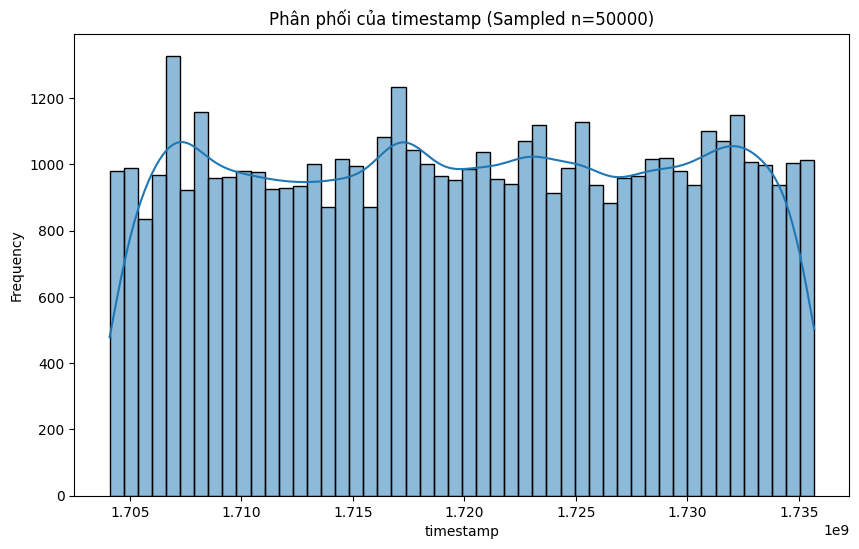

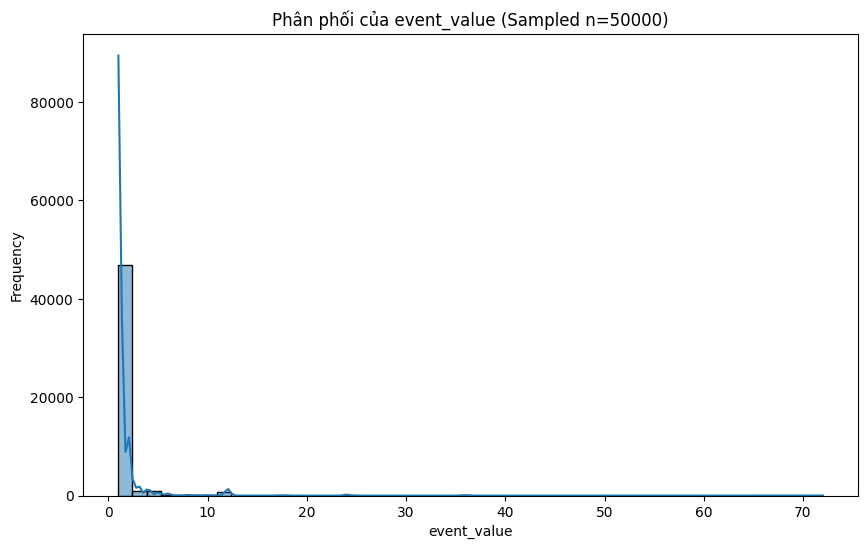

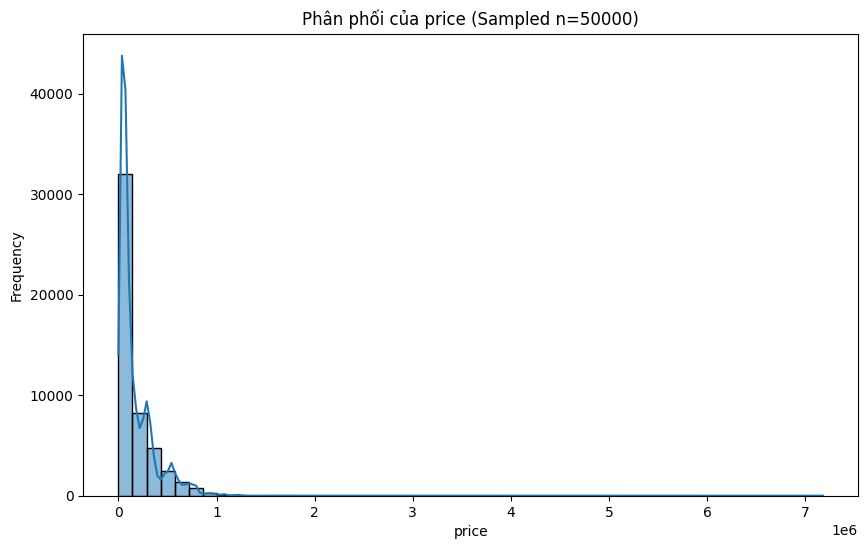

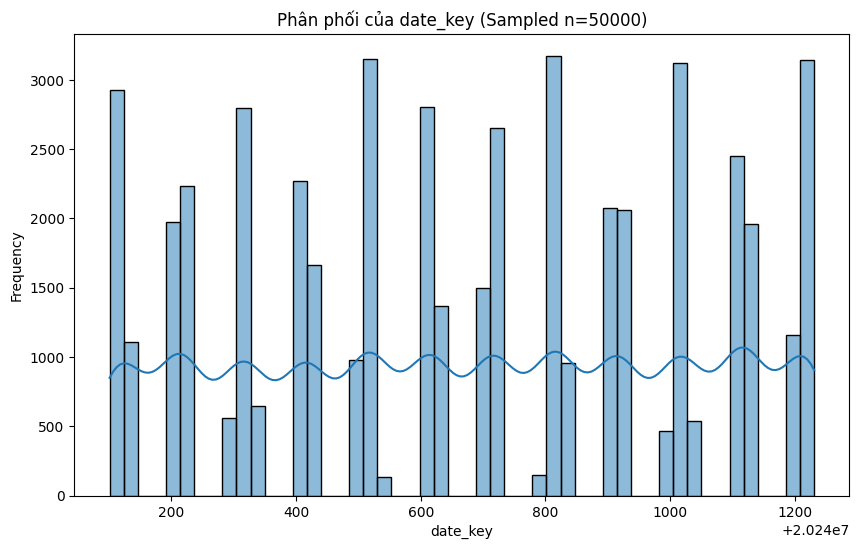

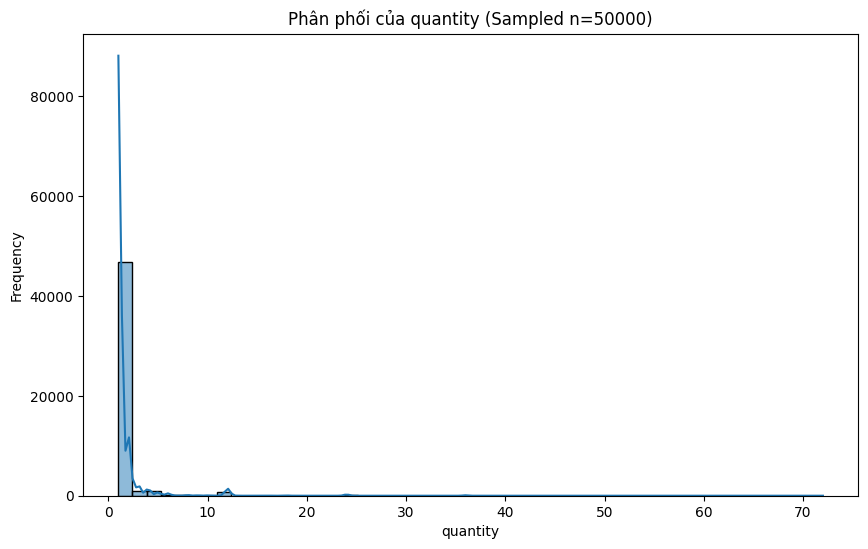

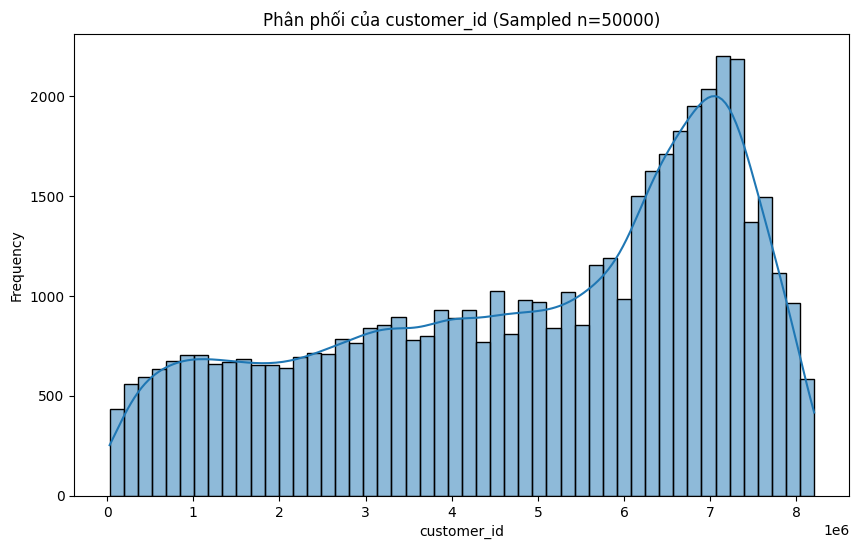

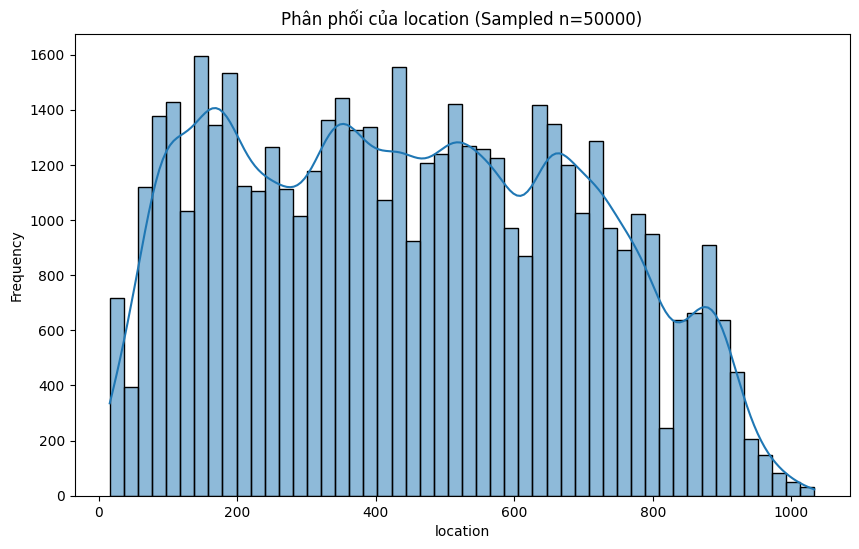

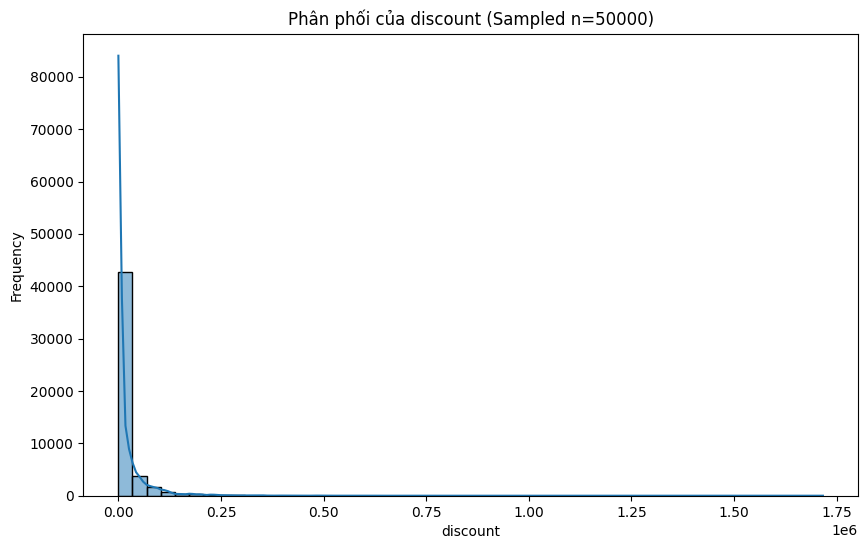

Đang lấy giá trị cho cột 'user_id'...


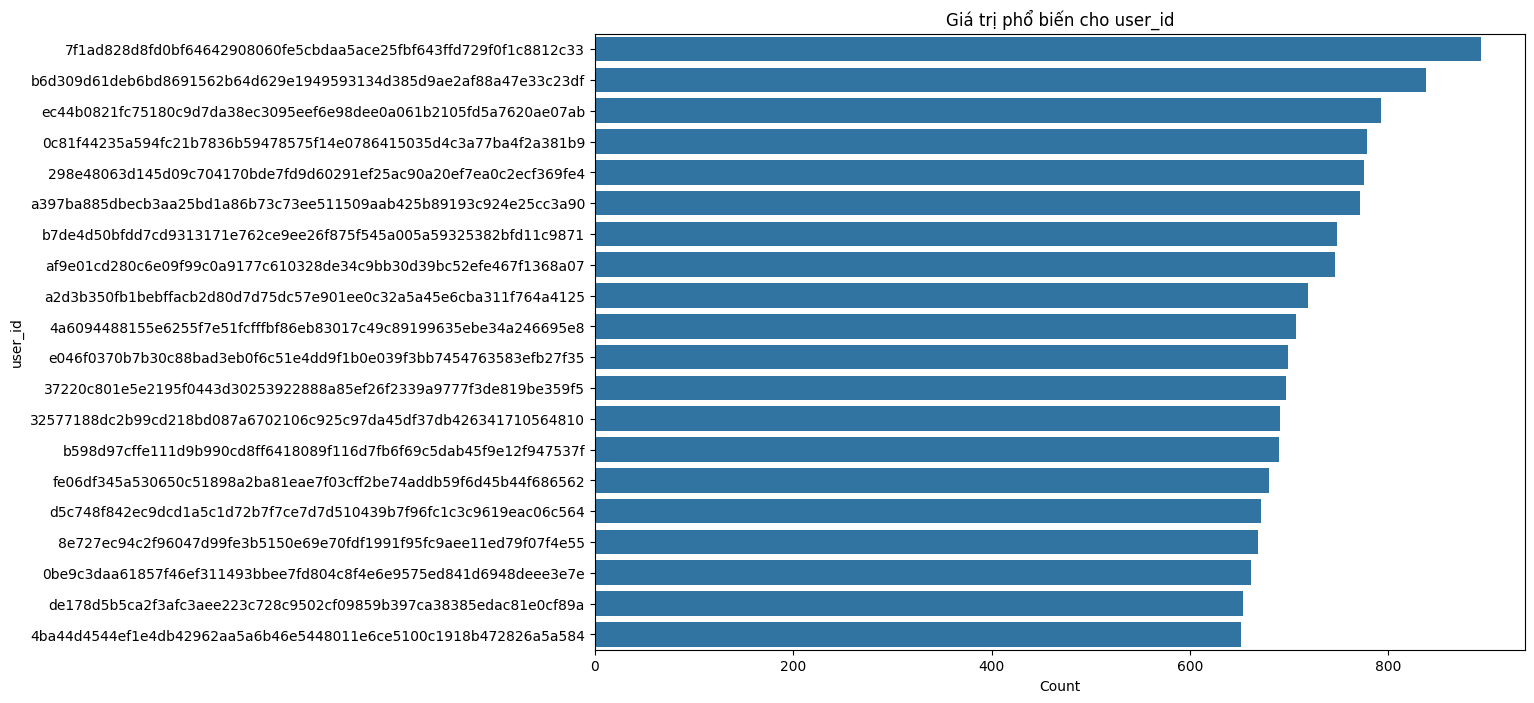

Đang lấy giá trị cho cột 'item_id'...


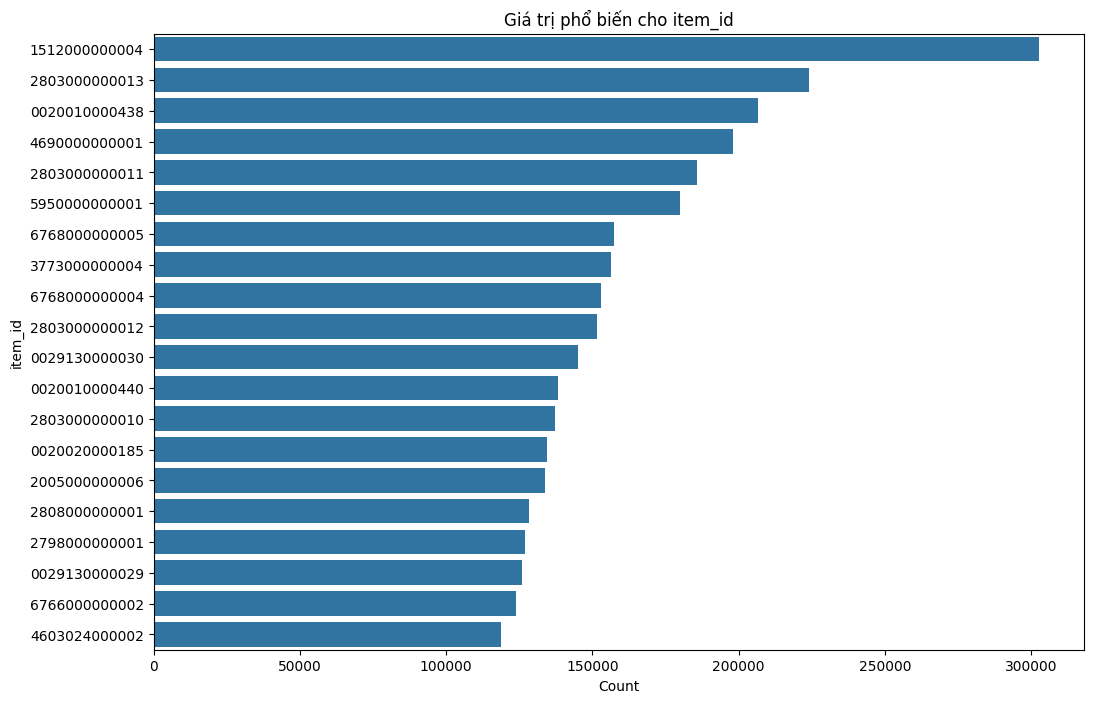

Đang lấy giá trị cho cột 'event_type'...


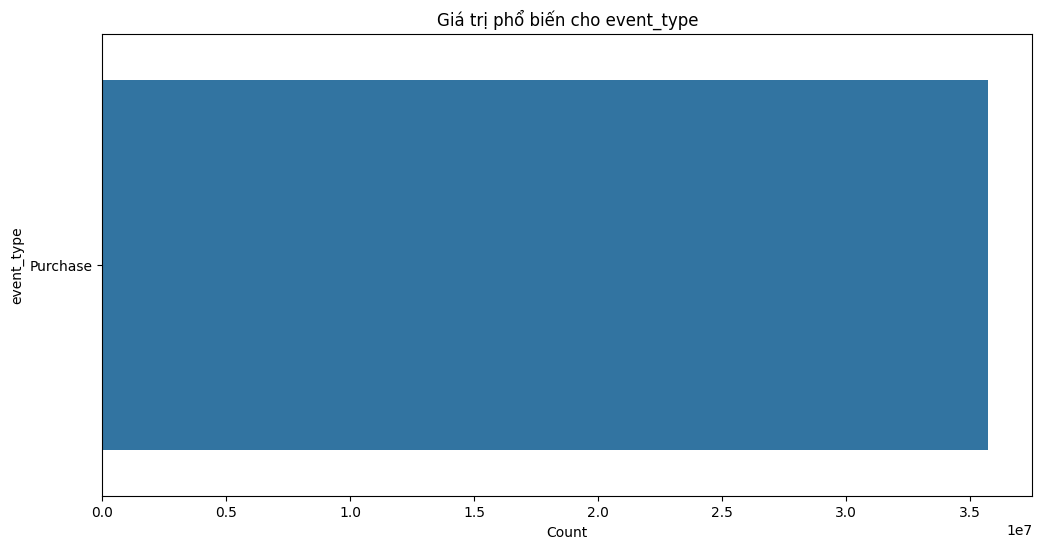

Đang lấy giá trị cho cột 'channel'...


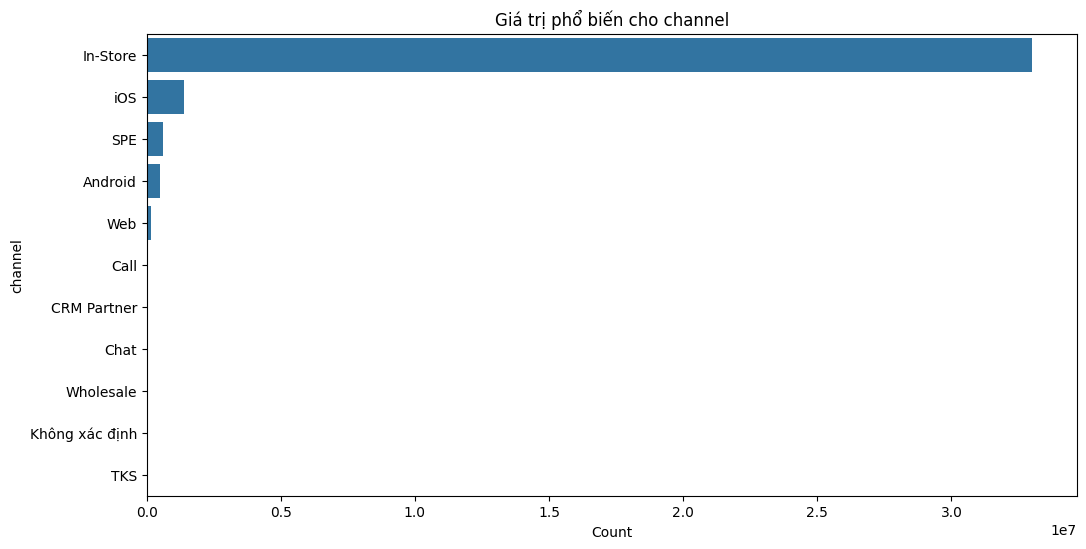

Đang lấy giá trị cho cột 'payment'...


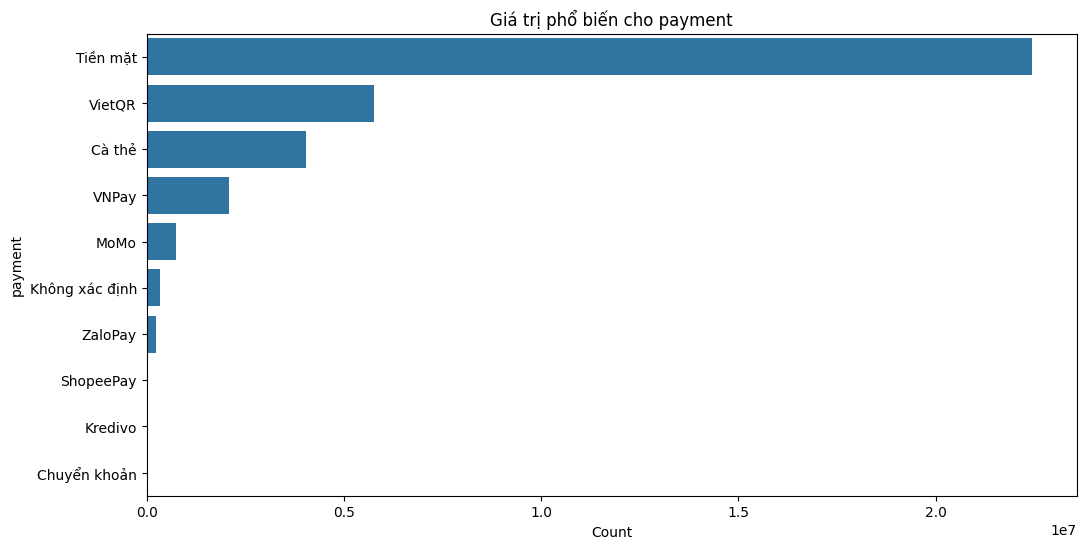

Đang lấy giá trị cho cột 'is_deleted'...


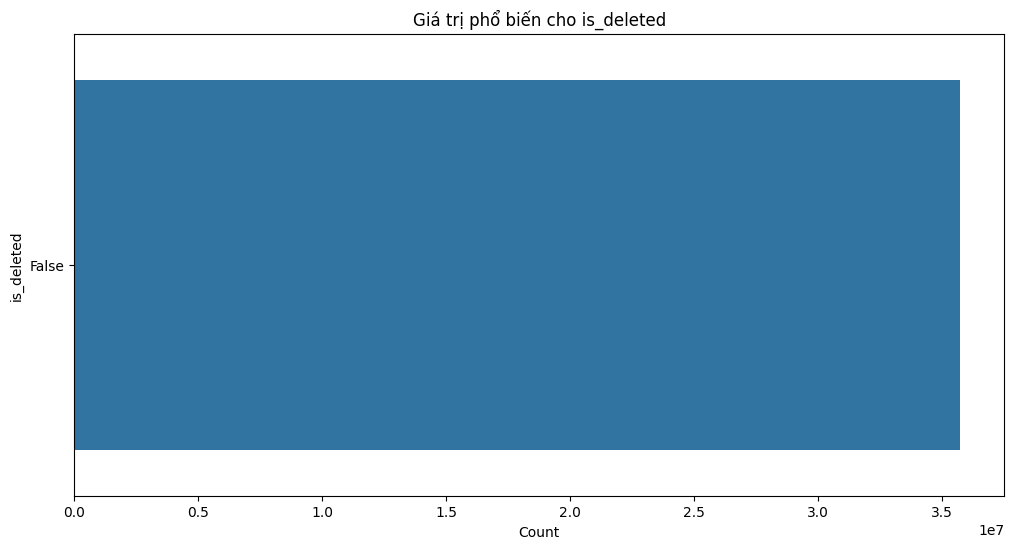

In [ ]:
# 1. Xem tóm tắt schema (giống .info() + nulls)
purchases_summary = eda_purchases.summarize_schema()
display(purchases_summary)

# 2. Xem tóm tắt các cột số (nếu có)
purchases_numeric_summary = eda_purchases.get_numeric_summary()
display(purchases_numeric_summary)
# 3. Xem các giá trị phổ biến nhất cho một cột
for col in eda_purchases._get_categorical_cols():
  purchases_value_counts = eda_purchases.get_value_counts(col)
  display(purchases_value_counts)
# 4. Vẽ biểu đồ phân phối cho 'age' (sẽ lấy mẫu)
for col in eda_purchases._get_numeric_cols():
  eda_purchases.plot_numeric_distribution(col)
# 5. Vẽ biểu đồ bar plot cho 'gender'
for col in eda_purchases._get_categorical_cols():
  eda_purchases.plot_categorical_distribution(col)

users

Đang tính toán số lượng null (có thể mất một chút thời gian)...


shape: (18, 5)
┌──────────────┬─────────┬────────────────┬────────────┬─────────────────────┐
│ column       ┆ dtype   ┆ non_null_count ┆ null_count ┆ null_percentage (%) │
│ ---          ┆ ---     ┆ ---            ┆ ---        ┆ ---                 │
│ str          ┆ object  ┆ i64            ┆ i64        ┆ f64                 │
╞══════════════╪═════════╪════════════════╪════════════╪═════════════════════╡
│ customer_id  ┆ Int32   ┆ 4573964        ┆ 0          ┆ 0.0                 │
│ gender       ┆ String  ┆ 4573964        ┆ 0          ┆ 0.0                 │
│ location     ┆ Int32   ┆ 4573964        ┆ 0          ┆ 0.0                 │
│ province     ┆ String  ┆ 4573964        ┆ 0          ┆ 0.0                 │
│ membership   ┆ String  ┆ 4573964        ┆ 0          ┆ 0.0                 │
│ …            ┆ …       ┆ …              ┆ …          ┆ …                   │
│ install_app  ┆ String  ┆ 4573964        ┆ 0          ┆ 0.0                 │
│ install_date ┆ Int64   ┆ 4573964        ┆ 0          ┆ 0.0                 │
│ district     ┆ String  ┆ 4573964        ┆ 0          ┆ 0.0                 │
│ user_id      ┆ String  ┆ 4573964        ┆ 0          ┆ 0.0                 │
│ is_deleted   ┆ Boolean ┆ 4573964        ┆ 0          ┆ 0.0                 │
└──────────────┴─────────┴────────────────┴────────────┴─────────────────────┘

Đang tính toán thống kê mô tả cho các cột số...


shape: (9, 6)
┌────────────┬─────────────┬────────────┬────────────┬────────────────┬──────────────┐
│ statistic  ┆ customer_id ┆ location   ┆ timestamp  ┆ sync_status_id ┆ install_date │
│ ---        ┆ ---         ┆ ---        ┆ ---        ┆ ---            ┆ ---          │
│ str        ┆ f64         ┆ f64        ┆ f64        ┆ f64            ┆ f64          │
╞════════════╪═════════════╪════════════╪════════════╪════════════════╪══════════════╡
│ count      ┆ 4.573964e6  ┆ 4.573964e6 ┆ 4.573964e6 ┆ 4.235679e6     ┆ 4.573964e6   │
│ null_count ┆ 0.0         ┆ 0.0        ┆ 0.0        ┆ 338285.0       ┆ 0.0          │
│ mean       ┆ 6.1266e6    ┆ 554.053518 ┆ 1.6712e9   ┆ 2.0            ┆ 1.6841e9     │
│ std        ┆ 2.4412e6    ┆ 295.523361 ┆ 7.9743e7   ┆ 0.0            ┆ 7.1374e7     │
│ min        ┆ 14732.0     ┆ 42.0       ┆ 1.3064e9   ┆ 2.0            ┆ 1.3063e9     │
│ 25%        ┆ 4.53268e6   ┆ 302.0      ┆ 1.6343e9   ┆ 2.0            ┆ 1.6550e9     │
│ 50%        ┆ 6.843955e6  ┆ 547.0      ┆ 1.6960e9   ┆ 2.0            ┆ 1.7054e9     │
│ 75%        ┆ 8.029649e6  ┆ 765.0      ┆ 1.7312e9   ┆ 2.0            ┆ 1.7366e9     │
│ max        ┆ 9.264159e6  ┆ 1310.0     ┆ 1.7593e9   ┆ 2.0            ┆ 1.7592e9     │
└────────────┴─────────────┴────────────┴────────────┴────────────────┴──────────────┘

Đang lấy giá trị cho cột 'gender'...


shape: (3, 3)
┌────────┬─────────┬────────────────┐
│ gender ┆ count   ┆ percentage (%) │
│ ---    ┆ ---     ┆ ---            │
│ str    ┆ u32     ┆ f64            │
╞════════╪═════════╪════════════════╡
│ Nữ     ┆ 3424887 ┆ 74.88          │
│ Nam    ┆ 1149069 ┆ 25.12          │
│ Khác   ┆ 8       ┆ 0.0            │
└────────┴─────────┴────────────────┘

Đang lấy giá trị cho cột 'province'...


shape: (20, 3)
┌─────────────┬─────────┬────────────────┐
│ province    ┆ count   ┆ percentage (%) │
│ ---         ┆ ---     ┆ ---            │
│ str         ┆ u32     ┆ f64            │
╞═════════════╪═════════╪════════════════╡
│ Hồ Chí Minh ┆ 1223333 ┆ 26.75          │
│ Đồng Nai    ┆ 312131  ┆ 6.82           │
│ Bình Dương  ┆ 287542  ┆ 6.29           │
│ Hà Nội      ┆ 201491  ┆ 4.41           │
│ Đà Nẵng     ┆ 146596  ┆ 3.21           │
│ …           ┆ …       ┆ …              │
│ Bình Thuận  ┆ 81964   ┆ 1.79           │
│ Đồng Tháp   ┆ 74808   ┆ 1.64           │
│ Bình Phước  ┆ 71158   ┆ 1.56           │
│ Vĩnh Long   ┆ 61105   ┆ 1.34           │
│ Cà Mau      ┆ 56627   ┆ 1.24           │
└─────────────┴─────────┴────────────────┘

Đang lấy giá trị cho cột 'membership'...


shape: (3, 3)
┌────────────┬─────────┬────────────────┐
│ membership ┆ count   ┆ percentage (%) │
│ ---        ┆ ---     ┆ ---            │
│ str        ┆ u32     ┆ f64            │
╞════════════╪═════════╪════════════════╡
│ Standard   ┆ 4242946 ┆ 92.76          │
│ Gold       ┆ 255173  ┆ 5.58           │
│ Diamond    ┆ 75845   ┆ 1.66           │
└────────────┴─────────┴────────────────┘

Đang lấy giá trị cho cột 'sync_error_message'...


shape: (1, 3)
┌────────────────────┬─────────┬────────────────┐
│ sync_error_message ┆ count   ┆ percentage (%) │
│ ---                ┆ ---     ┆ ---            │
│ str                ┆ u32     ┆ f64            │
╞════════════════════╪═════════╪════════════════╡
│ null               ┆ 4573964 ┆ 100.0          │
└────────────────────┴─────────┴────────────────┘

Đang lấy giá trị cho cột 'region'...


shape: (8, 3)
┌───────────────────────────────┬─────────┬────────────────┐
│ region                        ┆ count   ┆ percentage (%) │
│ ---                           ┆ ---     ┆ ---            │
│ str                           ┆ u32     ┆ f64            │
╞═══════════════════════════════╪═════════╪════════════════╡
│ Đông Nam Bộ                   ┆ 2126066 ┆ 46.48          │
│ Đồng bằng sông Cửu Long       ┆ 847970  ┆ 18.54          │
│ Duyên hải Nam Trung Bộ        ┆ 577306  ┆ 12.62          │
│ Đồng bằng sông Hồng           ┆ 361571  ┆ 7.9            │
│ Tây Nguyên                    ┆ 333463  ┆ 7.29           │
│ Bắc Trung Bộ                  ┆ 217869  ┆ 4.76           │
│ Trung du và miền núi phía Bắc ┆ 105336  ┆ 2.3            │
│ Duyên hải Bắc Bộ              ┆ 4383    ┆ 0.1            │
└───────────────────────────────┴─────────┴────────────────┘

Đang lấy giá trị cho cột 'location_name'...


shape: (20, 3)
┌───────────────────────────────┬───────┬────────────────┐
│ location_name                 ┆ count ┆ percentage (%) │
│ ---                           ┆ ---   ┆ ---            │
│ str                           ┆ u32   ┆ f64            │
╞═══════════════════════════════╪═══════╪════════════════╡
│ DNA - 81 - 83 Nguyễn Văn Linh ┆ 22383 ┆ 0.49           │
│ HNI - Aeon Mall Hà Đông       ┆ 21746 ┆ 0.48           │
│ HCM - 66 Nguyễn Du            ┆ 21509 ┆ 0.47           │
│ HNI - 933 La Thành            ┆ 20835 ┆ 0.46           │
│ HCM - 9 – 11 – 13 Nguyễn Trãi ┆ 20563 ┆ 0.45           │
│ …                             ┆ …     ┆ …              │
│ TBI - Go! Thái Bình           ┆ 13994 ┆ 0.31           │
│ HCM - 55B Phan Đăng Lưu       ┆ 13966 ┆ 0.31           │
│ LDO - 4A - 4C Hải Thượng      ┆ 13645 ┆ 0.3            │
│ HCM - 317 Hoàng Diệu          ┆ 13580 ┆ 0.3            │
│ THO - 300 - 302 Trần Phú      ┆ 13477 ┆ 0.29           │
└───────────────────────────────┴───────┴────────────────┘

Đang lấy giá trị cho cột 'install_app'...


shape: (11, 3)
┌────────────────┬─────────┬────────────────┐
│ install_app    ┆ count   ┆ percentage (%) │
│ ---            ┆ ---     ┆ ---            │
│ str            ┆ u32     ┆ f64            │
╞════════════════╪═════════╪════════════════╡
│ In-Store       ┆ 3942000 ┆ 86.18          │
│ SPE            ┆ 347908  ┆ 7.61           │
│ iOS            ┆ 127882  ┆ 2.8            │
│ Android        ┆ 91951   ┆ 2.01           │
│ Web            ┆ 35876   ┆ 0.78           │
│ …              ┆ …       ┆ …              │
│ Call           ┆ 10584   ┆ 0.23           │
│ Chat           ┆ 1727    ┆ 0.04           │
│ Wholesale      ┆ 38      ┆ 0.0            │
│ Không xác định ┆ 5       ┆ 0.0            │
│ LZD            ┆ 1       ┆ 0.0            │
└────────────────┴─────────┴────────────────┘

Đang lấy giá trị cho cột 'district'...


shape: (20, 3)
┌───────────────┬────────┬────────────────┐
│ district      ┆ count  ┆ percentage (%) │
│ ---           ┆ ---    ┆ ---            │
│ str           ┆ u32    ┆ f64            │
╞═══════════════╪════════╪════════════════╡
│ Thủ Đức       ┆ 195601 ┆ 4.28           │
│ Biên Hòa      ┆ 125390 ┆ 2.74           │
│ Bình Tân      ┆ 105858 ┆ 2.31           │
│ Tân Phú       ┆ 102835 ┆ 2.25           │
│ Bình Chánh    ┆ 84427  ┆ 1.85           │
│ …             ┆ …      ┆ …              │
│ Hóc Môn       ┆ 48664  ┆ 1.06           │
│ Đà Lạt        ┆ 48346  ┆ 1.06           │
│ Ninh Kiều     ┆ 48019  ┆ 1.05           │
│ Châu Thành    ┆ 47351  ┆ 1.04           │
│ Buôn Ma Thuột ┆ 46805  ┆ 1.02           │
└───────────────┴────────┴────────────────┘

Đang lấy giá trị cho cột 'user_id'...


shape: (20, 3)
┌─────────────────────────────────┬───────┬────────────────┐
│ user_id                         ┆ count ┆ percentage (%) │
│ ---                             ┆ ---   ┆ ---            │
│ str                             ┆ u32   ┆ f64            │
╞═════════════════════════════════╪═══════╪════════════════╡
│ a974bff966b64c1ac2a4fec55462aa… ┆ 1     ┆ 0.0            │
│ 485f539cb134ac0ff5324ae247f4e1… ┆ 1     ┆ 0.0            │
│ 479c25e939acef5c741691b5eece51… ┆ 1     ┆ 0.0            │
│ d618df6758c2feddfafa1df7f917d4… ┆ 1     ┆ 0.0            │
│ a085172c139af69a45417c2e4db69f… ┆ 1     ┆ 0.0            │
│ …                               ┆ …     ┆ …              │
│ 61afaa5974dceb0006715483f014a8… ┆ 1     ┆ 0.0            │
│ 9f3c85e62cb147dc21224a1c662a85… ┆ 1     ┆ 0.0            │
│ 124d8f89aa730cc4714694d953cf74… ┆ 1     ┆ 0.0            │
│ 2f401203d1ec051c8ac2cbc9fc91fa… ┆ 1     ┆ 0.0            │
│ 4e0795fa7539d061c8b08c37cdd7ed… ┆ 1     ┆ 0.0            │
└─────────────────────────────────┴───────┴────────────────┘

Đang lấy giá trị cho cột 'is_deleted'...


shape: (1, 3)
┌────────────┬─────────┬────────────────┐
│ is_deleted ┆ count   ┆ percentage (%) │
│ ---        ┆ ---     ┆ ---            │
│ bool       ┆ u32     ┆ f64            │
╞════════════╪═════════╪════════════════╡
│ false      ┆ 4573964 ┆ 100.0          │
└────────────┴─────────┴────────────────┘

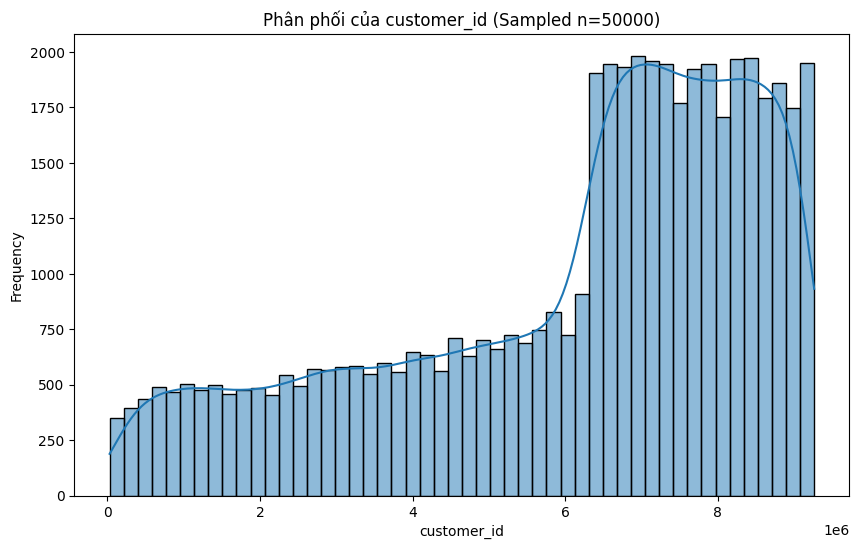

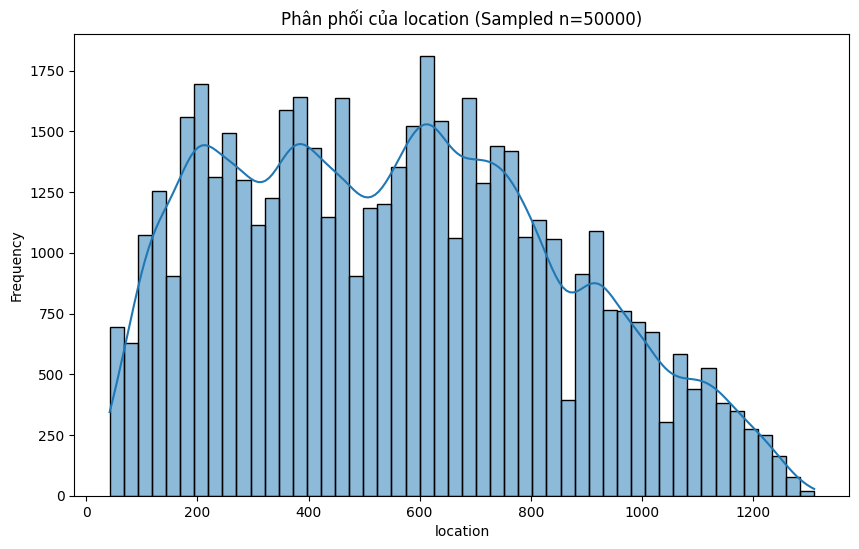

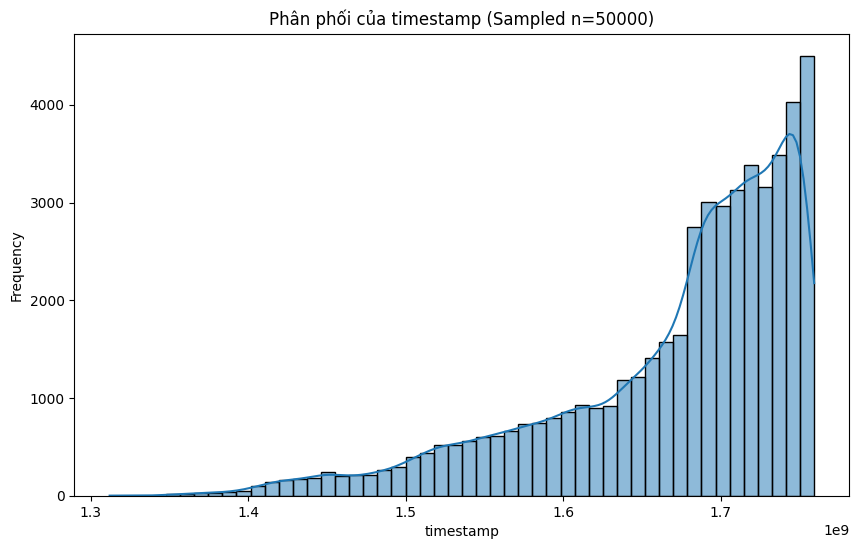

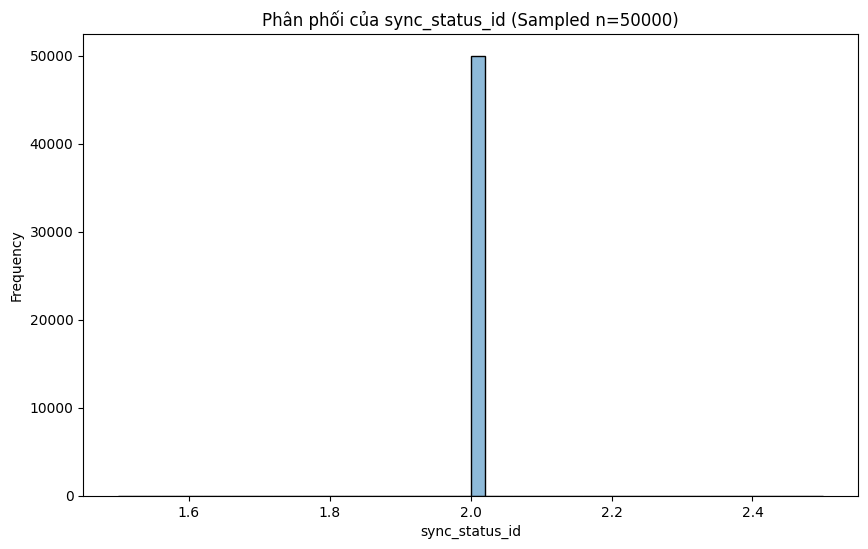

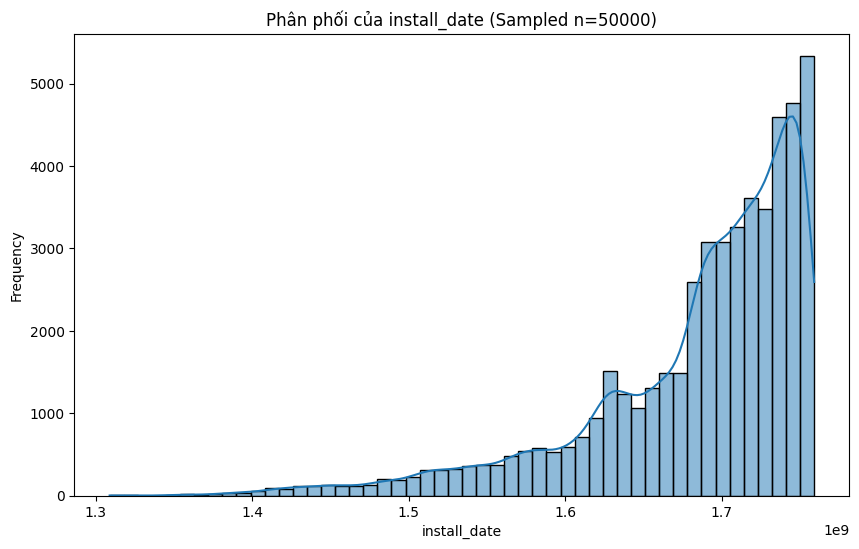

Đang lấy giá trị cho cột 'gender'...


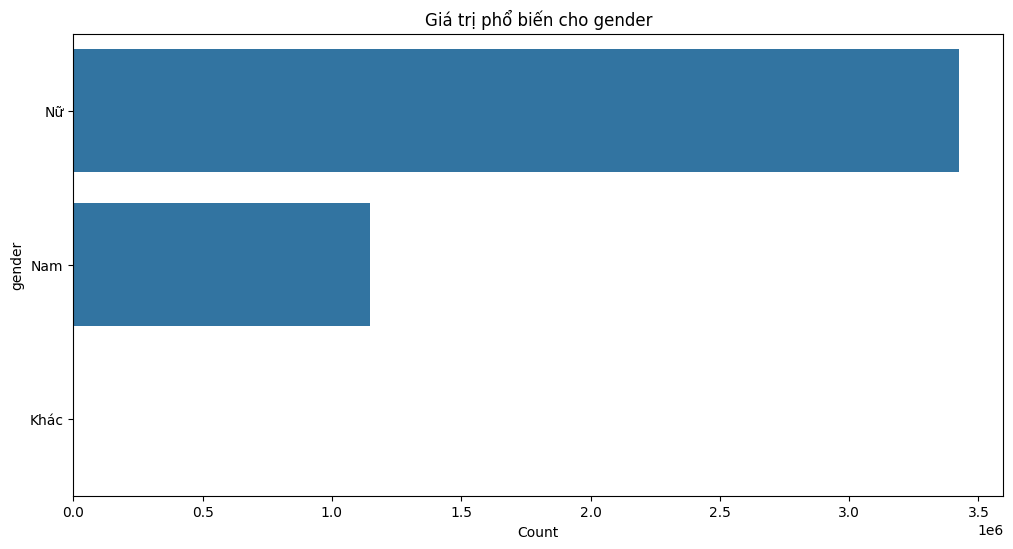

Đang lấy giá trị cho cột 'province'...


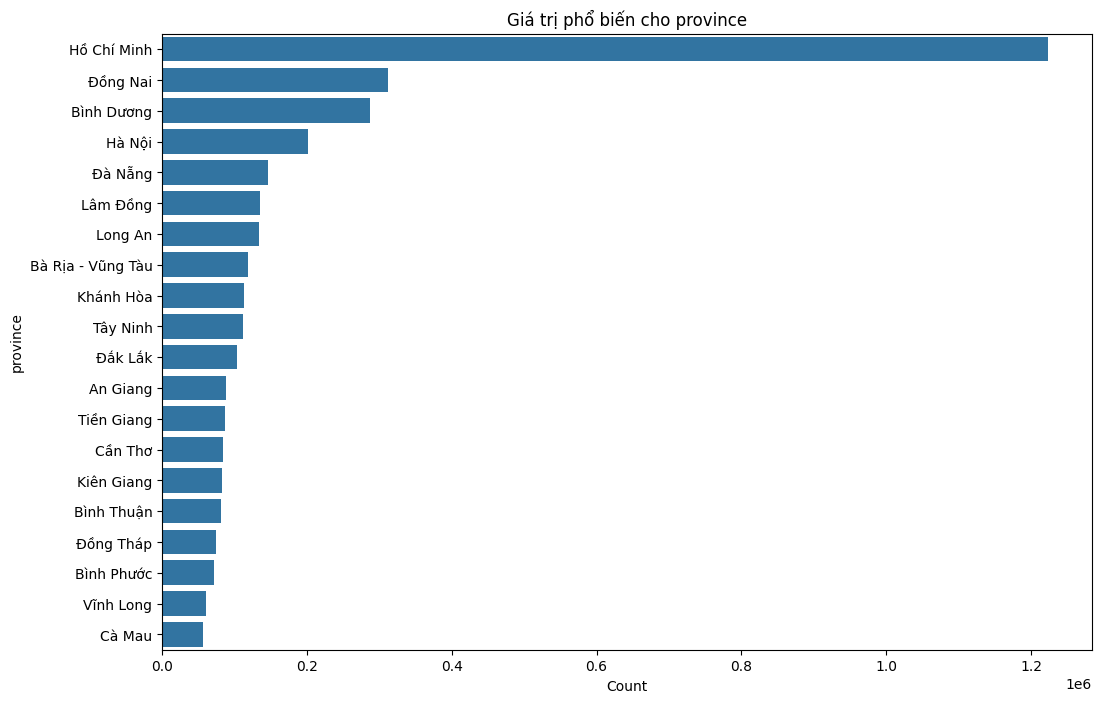

Đang lấy giá trị cho cột 'membership'...


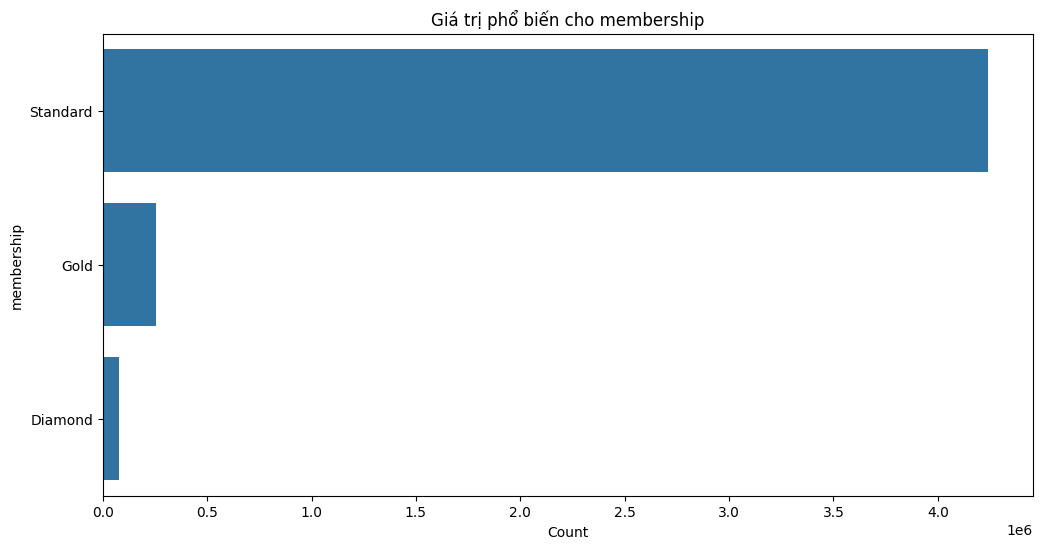

Đang lấy giá trị cho cột 'sync_error_message'...


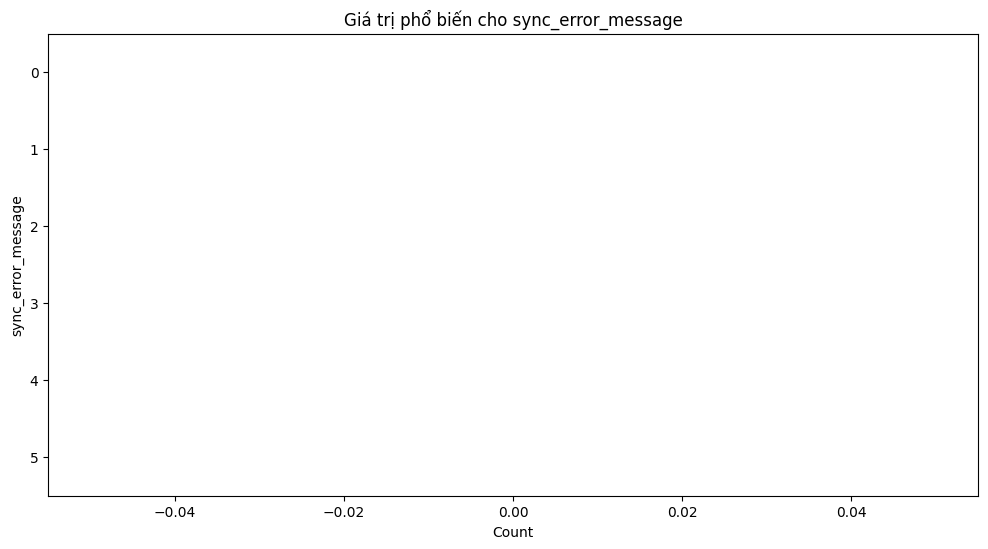

Đang lấy giá trị cho cột 'region'...


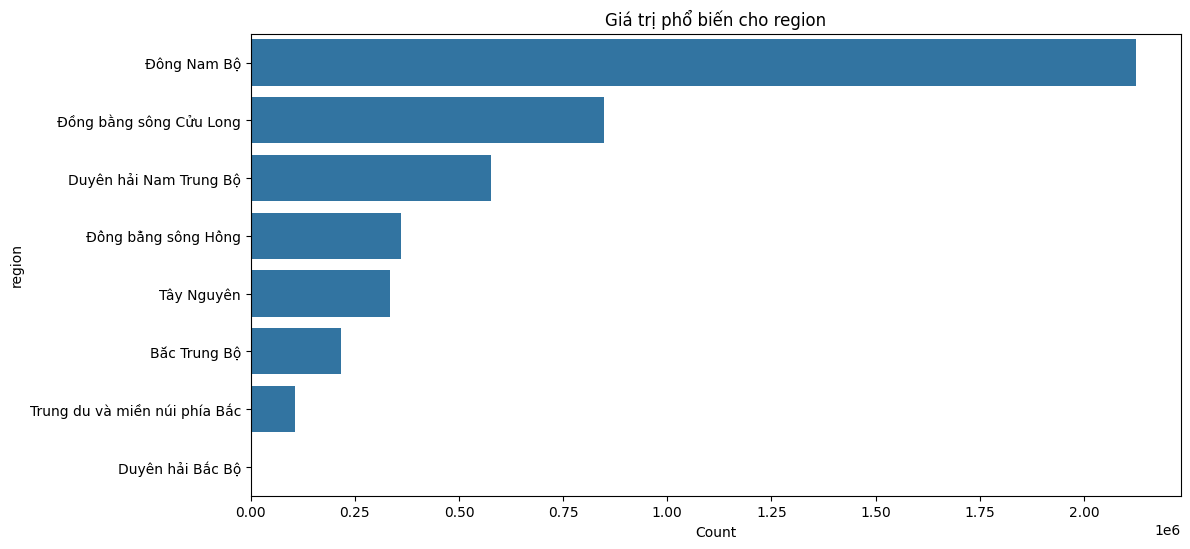

Đang lấy giá trị cho cột 'location_name'...


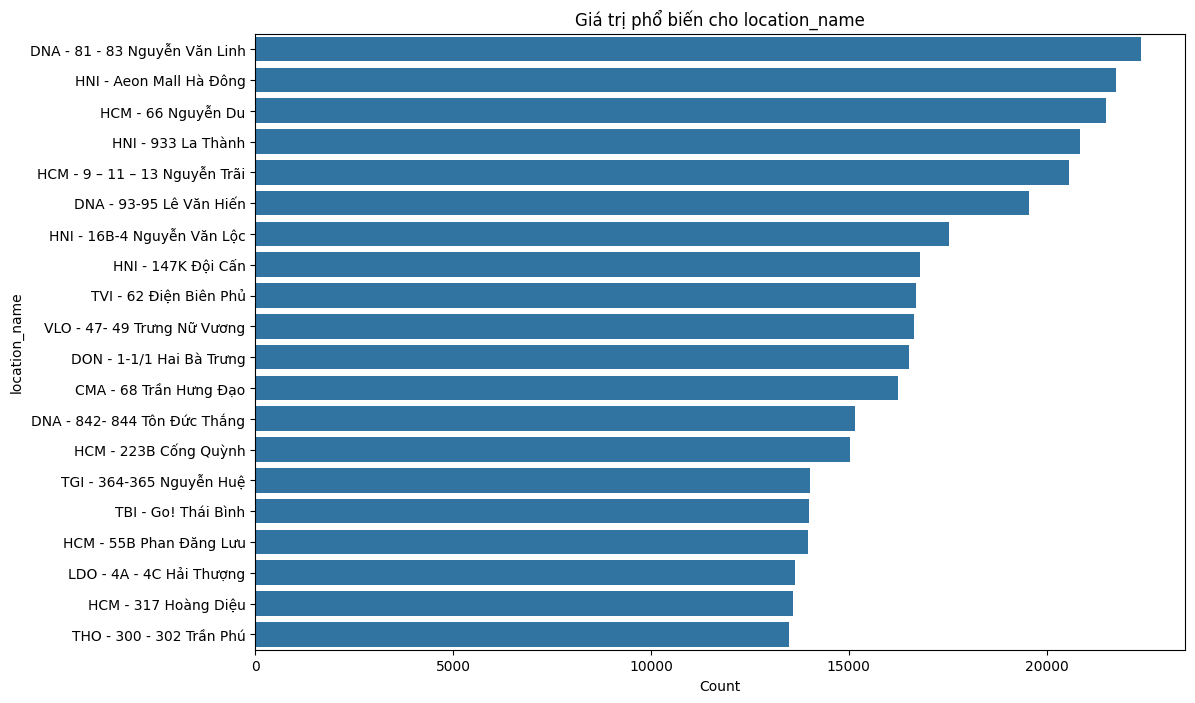

Đang lấy giá trị cho cột 'install_app'...


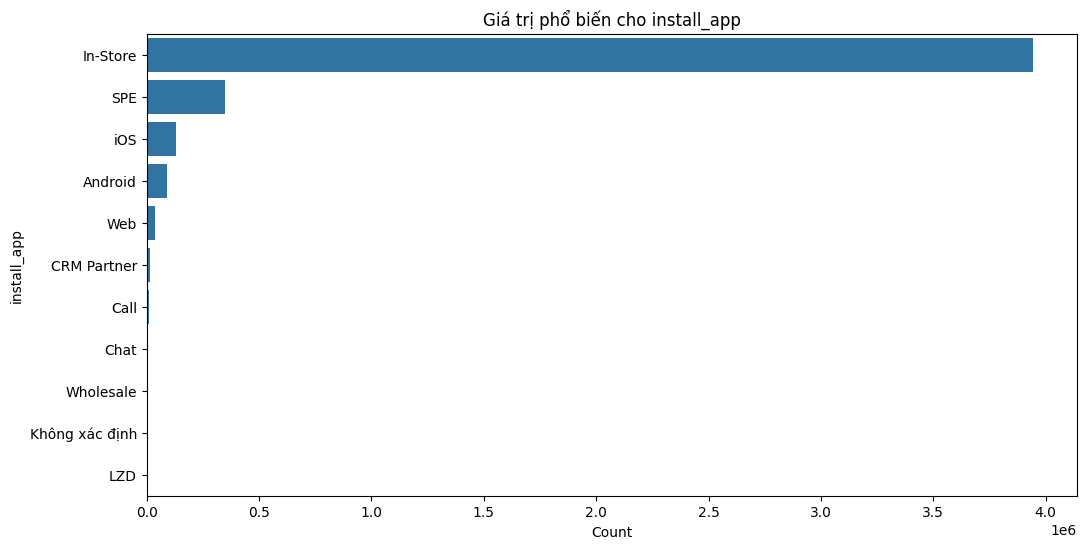

Đang lấy giá trị cho cột 'district'...


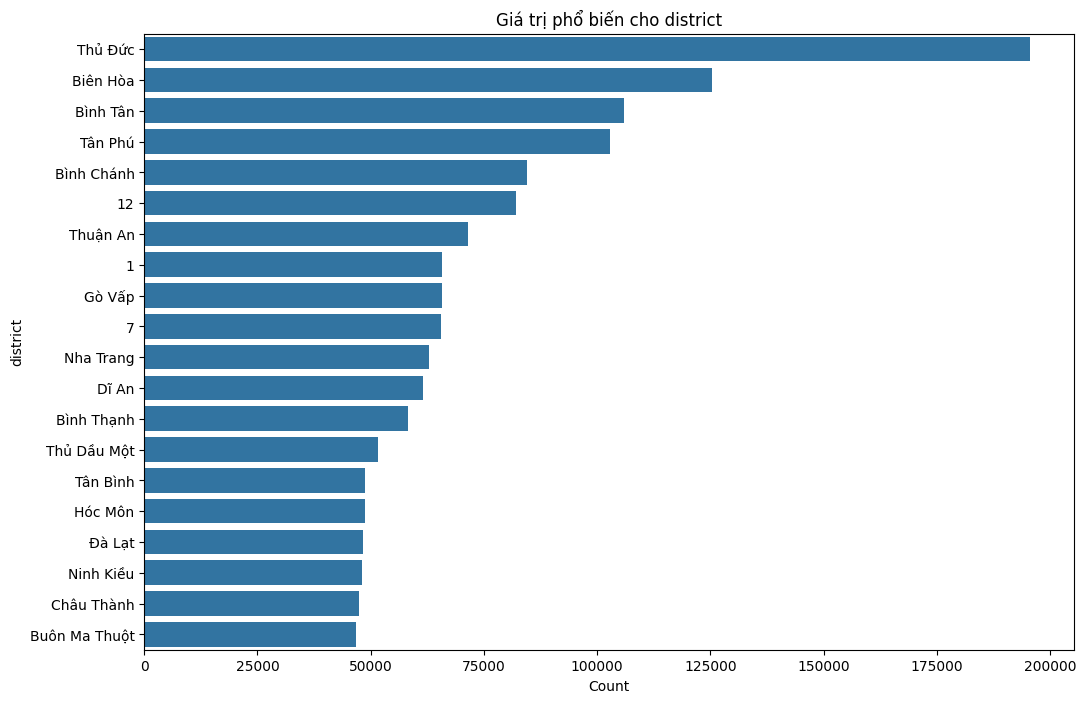

Đang lấy giá trị cho cột 'user_id'...


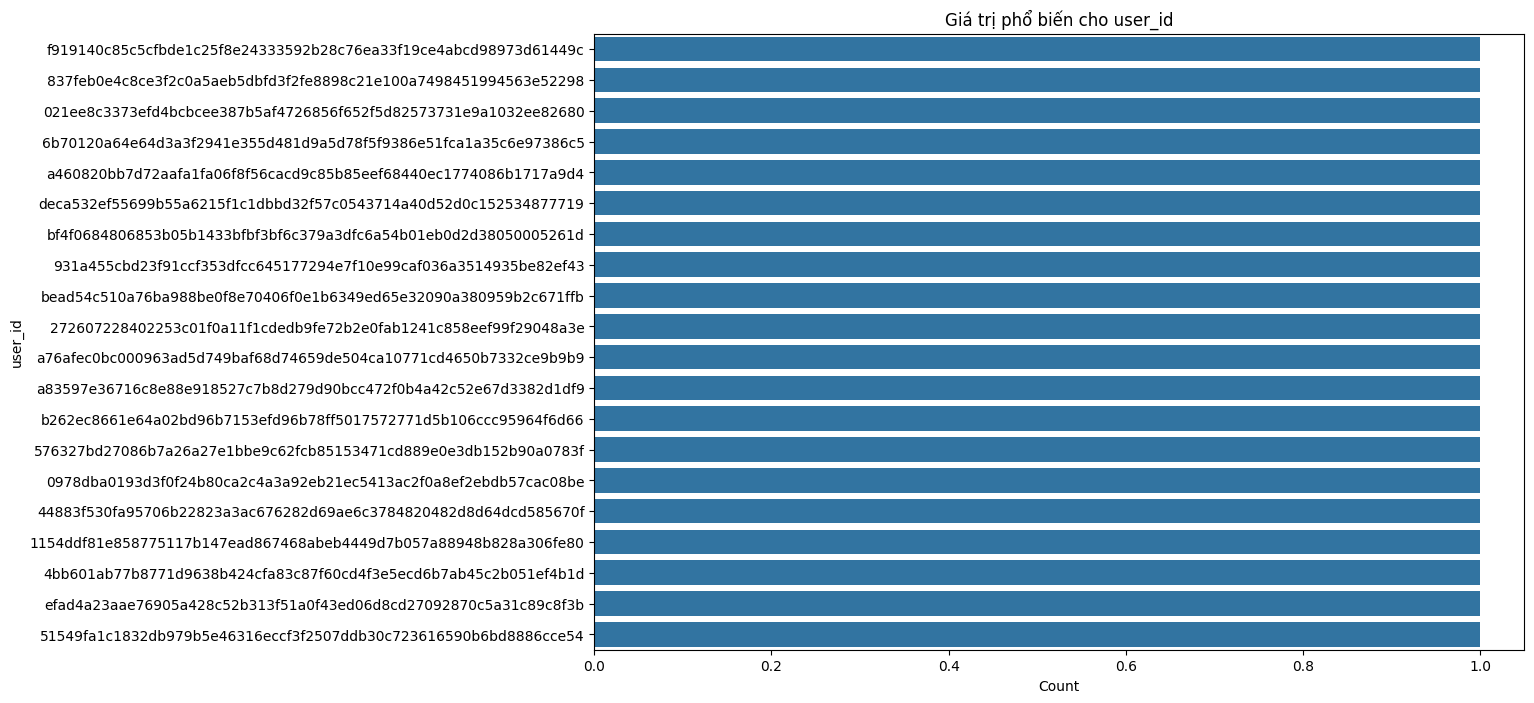

Đang lấy giá trị cho cột 'is_deleted'...


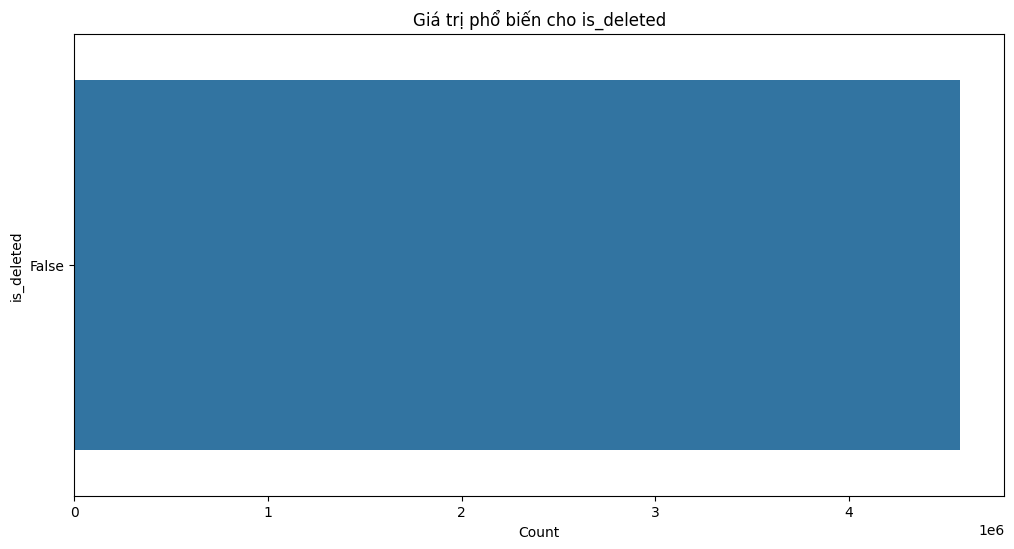

In [ ]:
# 1. Xem tóm tắt schema (giống .info() + nulls)
user_summary = eda_users.summarize_schema()
display(user_summary)

# 2. Xem tóm tắt các cột số (nếu có)
user_numeric_summary = eda_users.get_numeric_summary()
display(user_numeric_summary)

# 3. Xem các giá trị phổ biến nhất cho một cột
for col in eda_users._get_categorical_cols():
  users_value_counts = eda_users.get_value_counts(col)
  display(users_value_counts)

# 4. Vẽ biểu đồ phân phối cho 'age' (sẽ lấy mẫu)
for col in eda_users._get_numeric_cols():
  eda_users.plot_numeric_distribution(col)


# 5. Vẽ biểu đồ bar plot cho 'gender'
for col in eda_users._get_categorical_cols():
  eda_users.plot_categorical_distribution(col)

items

Đang tính toán số lượng null (có thể mất một chút thời gian)...


shape: (34, 5)
┌─────────────────┬───────────────────────┬────────────────┬────────────┬─────────────────────┐
│ column          ┆ dtype                 ┆ non_null_count ┆ null_count ┆ null_percentage (%) │
│ ---             ┆ ---                   ┆ ---            ┆ ---        ┆ ---                 │
│ str             ┆ object                ┆ i64            ┆ i64        ┆ f64                 │
╞═════════════════╪═══════════════════════╪════════════════╪════════════╪═════════════════════╡
│ p_id            ┆ Int32                 ┆ 27332          ┆ 0          ┆ 0.0                 │
│ item_id         ┆ String                ┆ 27332          ┆ 0          ┆ 0.0                 │
│ price           ┆ Decimal(precision=38, ┆ 27332          ┆ 0          ┆ 0.0                 │
│                 ┆ scale=4)              ┆                ┆            ┆                     │
│ category_l1_id  ┆ Int32                 ┆ 27332          ┆ 0          ┆ 0.0                 │
│ category_l1     ┆ String                ┆ 27332          ┆ 0          ┆ 0.0                 │
│ …               ┆ …                     ┆ …              ┆ …          ┆ …                   │
│ origin          ┆ String                ┆ 27332          ┆ 0          ┆ 0.0                 │
│ volume          ┆ String                ┆ 27332          ┆ 0          ┆ 0.0                 │
│ material        ┆ String                ┆ 27332          ┆ 0          ┆ 0.0                 │
│ sale_status     ┆ Int32                 ┆ 27332          ┆ 0          ┆ 0.0                 │
│ description_new ┆ String                ┆ 22317          ┆ 5015       ┆ 18.35               │
└─────────────────┴───────────────────────┴────────────────┴────────────┴─────────────────────┘

Đang tính toán thống kê mô tả cho các cột số...


shape: (9, 12)
┌────────┬────────┬────────┬───────┬───────┬───────┬───────┬───────┬───────┬───────┬───────┬───────┐
│ statis ┆ p_id   ┆ price  ┆ categ ┆ categ ┆ categ ┆ categ ┆ creat ┆ sync_ ┆ gp    ┆ weigh ┆ sale_ │
│ tic    ┆ ---    ┆ ---    ┆ ory_l ┆ ory_l ┆ ory_l ┆ ory_i ┆ ion_t ┆ statu ┆ ---   ┆ t     ┆ statu │
│ ---    ┆ f64    ┆ f64    ┆ 1_id  ┆ 2_id  ┆ 3_id  ┆ d     ┆ imest ┆ s_id  ┆ f64   ┆ ---   ┆ s     │
│ str    ┆        ┆        ┆ ---   ┆ ---   ┆ ---   ┆ ---   ┆ amp   ┆ ---   ┆       ┆ f64   ┆ ---   │
│        ┆        ┆        ┆ f64   ┆ f64   ┆ f64   ┆ f64   ┆ ---   ┆ f64   ┆       ┆       ┆ f64   │
│        ┆        ┆        ┆       ┆       ┆       ┆       ┆ f64   ┆       ┆       ┆       ┆       │
╞════════╪════════╪════════╪═══════╪═══════╪═══════╪═══════╪═══════╪═══════╪═══════╪═══════╪═══════╡
│ count  ┆ 27332. ┆ 27332. ┆ 27332 ┆ 27332 ┆ 27332 ┆ 27332 ┆ 27332 ┆ 26546 ┆ 27332 ┆ 0.0   ┆ 27332 │
│        ┆ 0      ┆ 0      ┆ .0    ┆ .0    ┆ .0    ┆ .0    ┆ .0    ┆ .0    ┆ .0    ┆       ┆ .0    │
│ null_c ┆ 0.0    ┆ 0.0    ┆ 0.0   ┆ 0.0   ┆ 0.0   ┆ 0.0   ┆ 0.0   ┆ 786.0 ┆ 0.0   ┆ 27332 ┆ 0.0   │
│ ount   ┆        ┆        ┆       ┆       ┆       ┆       ┆       ┆       ┆       ┆ .0    ┆       │
│ mean   ┆ 106317 ┆ 190456 ┆ 2836. ┆ 3719. ┆ 4876. ┆ 4920. ┆ 1.622 ┆ 2.0   ┆ 49696 ┆ null  ┆ 0.167 │
│        ┆ .67964 ┆ .82946 ┆ 18919 ┆ 03984 ┆ 76829 ┆ 71271 ┆ 5e9   ┆       ┆ .6512 ┆       ┆ 203   │
│        ┆ 3      ┆ 7      ┆ 2     ┆ 3     ┆ 4     ┆ 8     ┆       ┆       ┆ 26    ┆       ┆       │
│ std    ┆ 25425. ┆ 511123 ┆ 1417. ┆ 1935. ┆ 2035. ┆ 1999. ┆ 7.566 ┆ 0.0   ┆ 14415 ┆ null  ┆ 0.373 │
│        ┆ 734073 ┆ .97181 ┆ 52113 ┆ 04204 ┆ 95274 ┆ 30835 ┆ 6e7   ┆       ┆ 5.687 ┆       ┆ 164   │
│        ┆        ┆ 3      ┆ 7     ┆ 4     ┆ 1     ┆ 5     ┆       ┆       ┆ 53    ┆       ┆       │
│ min    ┆ 1675.0 ┆ 0.0    ┆ 1.0   ┆ 2.0   ┆ 14.0  ┆ 4.0   ┆ 1.298 ┆ 2.0   ┆ 0.0   ┆ null  ┆ 0.0   │
│        ┆        ┆        ┆       ┆       ┆       ┆       ┆ 3e9   ┆       ┆       ┆       ┆       │
│ 25%    ┆ 88905. ┆ 49000. ┆ 2788. ┆ 2038. ┆ 3516. ┆ 3522. ┆ 1.575 ┆ 2.0   ┆ 0.0   ┆ null  ┆ 0.0   │
│        ┆ 0      ┆ 0      ┆ 0     ┆ 0     ┆ 0     ┆ 0     ┆ 5e9   ┆       ┆       ┆       ┆       │
│ 50%    ┆ 104510 ┆ 119000 ┆ 3292. ┆ 3958. ┆ 5254. ┆ 5511. ┆ 1.635 ┆ 2.0   ┆ 25047 ┆ null  ┆ 0.0   │
│        ┆ .0     ┆ .0     ┆ 0     ┆ 0     ┆ 0     ┆ 0     ┆ 8e9   ┆       ┆ .0    ┆       ┆       │
│ 75%    ┆ 120262 ┆ 199000 ┆ 3292. ┆ 4571. ┆ 6984. ┆ 6988. ┆ 1.669 ┆ 2.0   ┆ 65532 ┆ null  ┆ 0.0   │
│        ┆ .0     ┆ .0     ┆ 0     ┆ 0     ┆ 0     ┆ 0     ┆ 9e9   ┆       ┆ .0    ┆       ┆       │
│ max    ┆ 167147 ┆ 2.099e ┆ 7376. ┆ 7492. ┆ 7493. ┆ 7501. ┆ 1.755 ┆ 2.0   ┆ 5.541 ┆ null  ┆ 1.0   │
│        ┆ .0     ┆ 7      ┆ 0     ┆ 0     ┆ 0     ┆ 0     ┆ 9e9   ┆       ┆ 36e6  ┆       ┆       │
└────────┴────────┴────────┴───────┴───────┴───────┴───────┴───────┴───────┴───────┴───────┴───────┘

Đang lấy giá trị cho cột 'item_id'...


shape: (20, 3)
┌───────────────┬───────┬────────────────┐
│ item_id       ┆ count ┆ percentage (%) │
│ ---           ┆ ---   ┆ ---            │
│ str           ┆ u32   ┆ f64            │
╞═══════════════╪═══════╪════════════════╡
│ 3324000000319 ┆ 1     ┆ 0.0            │
│ 3953000000767 ┆ 1     ┆ 0.0            │
│ 0819004140002 ┆ 1     ┆ 0.0            │
│ 2276000000009 ┆ 1     ┆ 0.0            │
│ 2206000000088 ┆ 1     ┆ 0.0            │
│ …             ┆ …     ┆ …              │
│ 0064000000005 ┆ 1     ┆ 0.0            │
│ 2898000000011 ┆ 1     ┆ 0.0            │
│ 3321017730001 ┆ 1     ┆ 0.0            │
│ 0957000000080 ┆ 1     ┆ 0.0            │
│ 5735000000001 ┆ 1     ┆ 0.0            │
└───────────────┴───────┴────────────────┘

Đang lấy giá trị cho cột 'category_l1'...


shape: (15, 3)
┌────────────────────┬───────┬────────────────┐
│ category_l1        ┆ count ┆ percentage (%) │
│ ---                ┆ ---   ┆ ---            │
│ str                ┆ u32   ┆ f64            │
╞════════════════════╪═══════╪════════════════╡
│ Thời trang         ┆ 15042 ┆ 55.03          │
│ Phụ kiện           ┆ 3147  ┆ 11.51          │
│ Đồ chơi & Sách     ┆ 2955  ┆ 10.81          │
│ Babycare           ┆ 1994  ┆ 7.3            │
│ Thực phẩm cho bé   ┆ 981   ┆ 3.59           │
│ …                  ┆ …     ┆ …              │
│ Hóa mỹ phẩm cho bé ┆ 346   ┆ 1.27           │
│ TPCN               ┆ 270   ┆ 0.99           │
│ Sữa nước           ┆ 166   ┆ 0.61           │
│ Vệ sinh            ┆ 132   ┆ 0.48           │
│ Gói Hội Viên       ┆ 7     ┆ 0.03           │
└────────────────────┴───────┴────────────────┘

Đang lấy giá trị cho cột 'category_l2'...


shape: (20, 3)
┌────────────────────┬───────┬────────────────┐
│ category_l2        ┆ count ┆ percentage (%) │
│ ---                ┆ ---   ┆ ---            │
│ str                ┆ u32   ┆ f64            │
╞════════════════════╪═══════╪════════════════╡
│ Cơ cấu hàng cũ     ┆ 9105  ┆ 33.31          │
│ Thời trang bé trai ┆ 2179  ┆ 7.97           │
│ Thời trang bé gái  ┆ 1887  ┆ 6.9            │
│ Modal kháng khuẩn  ┆ 1711  ┆ 6.26           │
│ 1Y+                ┆ 1565  ┆ 5.73           │
│ …                  ┆ …     ┆ …              │
│ Đồ dùng vệ sinh    ┆ 244   ┆ 0.89           │
│ TPCN cho bé        ┆ 199   ┆ 0.73           │
│ Bánh & Kẹo cho bé  ┆ 197   ┆ 0.72           │
│ Đồ dùng ra ngoài   ┆ 193   ┆ 0.71           │
│ Snack ăn dặm       ┆ 188   ┆ 0.69           │
└────────────────────┴───────┴────────────────┘

Đang lấy giá trị cho cột 'category_l3'...


shape: (20, 3)
┌────────────────────────────────┬───────┬────────────────┐
│ category_l3                    ┆ count ┆ percentage (%) │
│ ---                            ┆ ---   ┆ ---            │
│ str                            ┆ u32   ┆ f64            │
╞════════════════════════════════╪═══════╪════════════════╡
│ Thời trang bé trai, bé gái cũ  ┆ 5164  ┆ 18.89          │
│ Quần, áo & phụ kiện sơ sinh cũ ┆ 1763  ┆ 6.45           │
│ Bộ bé trai                     ┆ 1643  ┆ 6.01           │
│ Bộ Modal                       ┆ 1200  ┆ 4.39           │
│ Giày dép tồn                   ┆ 1092  ┆ 4.0            │
│ …                              ┆ …     ┆ …              │
│ Bodysuit bé trai               ┆ 324   ┆ 1.19           │
│ Bodysuit bé gái                ┆ 274   ┆ 1.0            │
│ Phụ kiện khác                  ┆ 259   ┆ 0.95           │
│ Giày tập đi 149k               ┆ 246   ┆ 0.9            │
│ Phát triển giác quan           ┆ 241   ┆ 0.88           │
└────────────────────────────────┴───────┴────────────────┘

Đang lấy giá trị cho cột 'category'...


shape: (20, 3)
┌──────────────────────┬───────┬────────────────┐
│ category             ┆ count ┆ percentage (%) │
│ ---                  ┆ ---   ┆ ---            │
│ str                  ┆ u32   ┆ f64            │
╞══════════════════════╪═══════╪════════════════╡
│ Bộ bé trai Animo     ┆ 1018  ┆ 3.72           │
│ Bộ quần áo bé gái    ┆ 741   ┆ 2.71           │
│ Bộ Modal lẻ          ┆ 740   ┆ 2.71           │
│ Áo bé gái            ┆ 731   ┆ 2.67           │
│ Bodysuit             ┆ 718   ┆ 2.63           │
│ …                    ┆ …     ┆ …              │
│ Quần sơ sinh Animo   ┆ 439   ┆ 1.61           │
│ Bộ bé gái Animo Easy ┆ 424   ┆ 1.55           │
│ Đầm                  ┆ 416   ┆ 1.52           │
│ Đầm bé gái Animo     ┆ 357   ┆ 1.31           │
│ Bộ Modal set 2       ┆ 354   ┆ 1.3            │
└──────────────────────┴───────┴────────────────┘

Đang lấy giá trị cho cột 'description'...


shape: (20, 3)
┌─────────────────────────────────┬───────┬────────────────┐
│ description                     ┆ count ┆ percentage (%) │
│ ---                             ┆ ---   ┆ ---            │
│ str                             ┆ u32   ┆ f64            │
╞═════════════════════════════════╪═══════╪════════════════╡
│ Không xác định                  ┆ 18629 ┆ 68.16          │
│ Ưu điểm nổi bật của sản phẩm -… ┆ 16    ┆ 0.06           │
│ ﻿ Ưu điểm nổi bật của sản phẩm…  ┆ 8     ┆ 0.03           │
│ - Chuyên dùng cho bé ngậm tạo … ┆ 6     ┆ 0.02           │
│ ﻿ Ưu điểm nổi bật của sản phẩm…  ┆ 6     ┆ 0.02           │
│ …                               ┆ …     ┆ …              │
│ PORORO TINCASE là sản phẩm băn… ┆ 2     ┆ 0.01           │
│ ﻿Bodysuit bé trai đùi Animo B1…  ┆ 2     ┆ 0.01           │
│ Khăn kháng khuẩn ra đời đáp ứn… ┆ 2     ┆ 0.01           │
│ ﻿Mẹ sau sinh trở lại với công …  ┆ 2     ┆ 0.01           │
│ Đồ chơi nhập vai chăm sóc thú … ┆ 2     ┆ 0.01           │
└─────────────────────────────────┴───────┴────────────────┘

Đang lấy giá trị cho cột 'brand'...


shape: (20, 3)
┌──────────────────────┬───────┬────────────────┐
│ brand                ┆ count ┆ percentage (%) │
│ ---                  ┆ ---   ┆ ---            │
│ str                  ┆ u32   ┆ f64            │
╞══════════════════════╪═══════╪════════════════╡
│ Animo                ┆ 8149  ┆ 29.81          │
│ Không xác định       ┆ 5480  ┆ 20.05          │
│ CF (ConCung Fashion) ┆ 5426  ┆ 19.85          │
│ Thương hiệu khác     ┆ 607   ┆ 2.22           │
│ Con Cưng             ┆ 484   ┆ 1.77           │
│ …                    ┆ …     ┆ …              │
│ Đinh Tị              ┆ 56    ┆ 0.2            │
│ Bobby                ┆ 56    ┆ 0.2            │
│ Heinz                ┆ 54    ┆ 0.2            │
│ Joie                 ┆ 54    ┆ 0.2            │
│ NS Minh Long         ┆ 51    ┆ 0.19           │
└──────────────────────┴───────┴────────────────┘

Đang lấy giá trị cho cột 'manufacturer'...


shape: (20, 3)
┌─────────────────────────────────┬───────┬────────────────┐
│ manufacturer                    ┆ count ┆ percentage (%) │
│ ---                             ┆ ---   ┆ ---            │
│ str                             ┆ u32   ┆ f64            │
╞═════════════════════════════════╪═══════╪════════════════╡
│ Không xác định                  ┆ 25767 ┆ 94.27          │
│ Unilever                        ┆ 28    ┆ 0.1            │
│ Mead Johnson Nutrition (Thaila… ┆ 20    ┆ 0.07           │
│ Công ty Cổ Phần Thực Phẩm Dinh… ┆ 19    ┆ 0.07           │
│ Vinamilk                        ┆ 17    ┆ 0.06           │
│ …                               ┆ …     ┆ …              │
│ Công ty TNHH FrieslandCampina … ┆ 9     ┆ 0.03           │
│ Zaza Sekerleme Gida San. Ve Ti… ┆ 9     ┆ 0.03           │
│ YI MIN TOYS FACTORY             ┆ 9     ┆ 0.03           │
│ Abbott Ireland, Cootehill, Co.… ┆ 9     ┆ 0.03           │
│ SHANTOU CHENGHAIWENYI TOYS CO.… ┆ 9     ┆ 0.03           │
└─────────────────────────────────┴───────┴────────────────┘

Đang lấy giá trị cho cột 'is_deleted'...


shape: (1, 3)
┌────────────┬───────┬────────────────┐
│ is_deleted ┆ count ┆ percentage (%) │
│ ---        ┆ ---   ┆ ---            │
│ bool       ┆ u32   ┆ f64            │
╞════════════╪═══════╪════════════════╡
│ false      ┆ 27332 ┆ 100.0          │
└────────────┴───────┴────────────────┘

Đang lấy giá trị cho cột 'sync_error_message'...


shape: (1, 3)
┌────────────────────┬───────┬────────────────┐
│ sync_error_message ┆ count ┆ percentage (%) │
│ ---                ┆ ---   ┆ ---            │
│ str                ┆ u32   ┆ f64            │
╞════════════════════╪═══════╪════════════════╡
│ null               ┆ 27332 ┆ 100.0          │
└────────────────────┴───────┴────────────────┘

Đang lấy giá trị cho cột 'image_url'...


shape: (1, 3)
┌────────────────┬───────┬────────────────┐
│ image_url      ┆ count ┆ percentage (%) │
│ ---            ┆ ---   ┆ ---            │
│ str            ┆ u32   ┆ f64            │
╞════════════════╪═══════╪════════════════╡
│ Không xác định ┆ 27332 ┆ 100.0          │
└────────────────┴───────┴────────────────┘

Đang lấy giá trị cho cột 'gender_target'...


shape: (5, 3)
┌────────────────┬───────┬────────────────┐
│ gender_target  ┆ count ┆ percentage (%) │
│ ---            ┆ ---   ┆ ---            │
│ str            ┆ u32   ┆ f64            │
╞════════════════╪═══════╪════════════════╡
│ Không xác định ┆ 18038 ┆ 66.0           │
│ Bé Gái         ┆ 4108  ┆ 15.03          │
│ Bé Trai        ┆ 3318  ┆ 12.14          │
│ Sơ sinh        ┆ 1862  ┆ 6.81           │
│ Unisex         ┆ 6     ┆ 0.02           │
└────────────────┴───────┴────────────────┘

Đang lấy giá trị cho cột 'age_group'...


shape: (20, 3)
┌────────────────┬───────┬────────────────┐
│ age_group      ┆ count ┆ percentage (%) │
│ ---            ┆ ---   ┆ ---            │
│ str            ┆ u32   ┆ f64            │
╞════════════════╪═══════╪════════════════╡
│ Không xác định ┆ 15812 ┆ 57.85          │
│ Từ 3Y          ┆ 944   ┆ 3.45           │
│ 9M-12M         ┆ 844   ┆ 3.09           │
│ 6M-9M          ┆ 672   ┆ 2.46           │
│ Từ 1Y          ┆ 609   ┆ 2.23           │
│ …              ┆ …     ┆ …              │
│ Từ 18M         ┆ 275   ┆ 1.01           │
│ Từ 6Y          ┆ 269   ┆ 0.98           │
│ Từ 5Y          ┆ 264   ┆ 0.97           │
│ 3Y-4Y          ┆ 264   ┆ 0.97           │
│ 4Y-5Y          ┆ 259   ┆ 0.95           │
└────────────────┴───────┴────────────────┘

Đang lấy giá trị cho cột 'item_type'...


shape: (20, 3)
┌─────────────────────────────────┬───────┬────────────────┐
│ item_type                       ┆ count ┆ percentage (%) │
│ ---                             ┆ ---   ┆ ---            │
│ str                             ┆ u32   ┆ f64            │
╞═════════════════════════════════╪═══════╪════════════════╡
│ Không xác định                  ┆ 9820  ┆ 35.93          │
│ Bộ quần áo                      ┆ 3926  ┆ 14.36          │
│ Áo                              ┆ 1904  ┆ 6.97           │
│ Bodysuit                        ┆ 1456  ┆ 5.33           │
│ Quần                            ┆ 990   ┆ 3.62           │
│ …                               ┆ …     ┆ …              │
│ Đồ chơi ghép hình, xếp hình, l… ┆ 192   ┆ 0.7            │
│ Giày                            ┆ 175   ┆ 0.64           │
│ Thú nhồi bông                   ┆ 169   ┆ 0.62           │
│ Tã dán                          ┆ 130   ┆ 0.48           │
│ Kẹp tóc                         ┆ 122   ┆ 0.45           │
└─────────────────────────────────┴───────┴────────────────┘

Đang lấy giá trị cho cột 'color'...


shape: (20, 3)
┌────────────────┬───────┬────────────────┐
│ color          ┆ count ┆ percentage (%) │
│ ---            ┆ ---   ┆ ---            │
│ str            ┆ u32   ┆ f64            │
╞════════════════╪═══════╪════════════════╡
│ Không xác định ┆ 26608 ┆ 97.35          │
│ Xanh           ┆ 165   ┆ 0.6            │
│ Hồng           ┆ 164   ┆ 0.6            │
│ Trắng          ┆ 81    ┆ 0.3            │
│ Vàng           ┆ 48    ┆ 0.18           │
│ …              ┆ …     ┆ …              │
│ Xanh da trời   ┆ 6     ┆ 0.02           │
│ Xanh jean      ┆ 5     ┆ 0.02           │
│ Xanh lá cây    ┆ 4     ┆ 0.01           │
│ Xanh đen       ┆ 3     ┆ 0.01           │
│ Vàng họa tiết  ┆ 3     ┆ 0.01           │
└────────────────┴───────┴────────────────┘

Đang lấy giá trị cho cột 'size'...


shape: (20, 3)
┌────────────────┬───────┬────────────────┐
│ size           ┆ count ┆ percentage (%) │
│ ---            ┆ ---   ┆ ---            │
│ str            ┆ u32   ┆ f64            │
╞════════════════╪═══════╪════════════════╡
│ Không xác định ┆ 25108 ┆ 91.86          │
│ 0-3M           ┆ 346   ┆ 1.27           │
│ 1Y             ┆ 330   ┆ 1.21           │
│ 6-9M           ┆ 224   ┆ 0.82           │
│ NB             ┆ 112   ┆ 0.41           │
│ …              ┆ …     ┆ …              │
│ 12             ┆ 42    ┆ 0.15           │
│ 18-24M         ┆ 40    ┆ 0.15           │
│ 12-18M         ┆ 30    ┆ 0.11           │
│ 17             ┆ 29    ┆ 0.11           │
│ 7-8 tuổi       ┆ 22    ┆ 0.08           │
└────────────────┴───────┴────────────────┘

Đang lấy giá trị cho cột 'origin'...


shape: (20, 3)
┌────────────────────────┬───────┬────────────────┐
│ origin                 ┆ count ┆ percentage (%) │
│ ---                    ┆ ---   ┆ ---            │
│ str                    ┆ u32   ┆ f64            │
╞════════════════════════╪═══════╪════════════════╡
│ Không xác định         ┆ 22627 ┆ 82.79          │
│ Việt Nam               ┆ 1991  ┆ 7.28           │
│ Trung Quốc             ┆ 584   ┆ 2.14           │
│ Hàn Quốc               ┆ 216   ┆ 0.79           │
│ Việt Nam, Việt Nam     ┆ 190   ┆ 0.7            │
│ …                      ┆ …     ┆ …              │
│ Đức                    ┆ 25    ┆ 0.09           │
│ Nhật Bản, Việt Nam     ┆ 24    ┆ 0.09           │
│ Indonesia              ┆ 23    ┆ 0.08           │
│ Việt Nam, Mỹ           ┆ 22    ┆ 0.08           │
│ Trung Quốc, Trung Quốc ┆ 22    ┆ 0.08           │
└────────────────────────┴───────┴────────────────┘

Đang lấy giá trị cho cột 'volume'...


shape: (20, 3)
┌────────────────┬───────┬────────────────┐
│ volume         ┆ count ┆ percentage (%) │
│ ---            ┆ ---   ┆ ---            │
│ str            ┆ u32   ┆ f64            │
╞════════════════╪═══════╪════════════════╡
│ Không xác định ┆ 26973 ┆ 98.69          │
│ 500ml          ┆ 24    ┆ 0.09           │
│ 200ml          ┆ 18    ┆ 0.07           │
│ 100ml          ┆ 18    ┆ 0.07           │
│ 110ml x 4 hộp  ┆ 16    ┆ 0.06           │
│ …              ┆ …     ┆ …              │
│ 60ml           ┆ 5     ┆ 0.02           │
│ 3L             ┆ 5     ┆ 0.02           │
│ 110ml x 4 hộp  ┆ 5     ┆ 0.02           │
│ 50ml           ┆ 5     ┆ 0.02           │
│ 180ml x 4 hộp  ┆ 4     ┆ 0.01           │
└────────────────┴───────┴────────────────┘

Đang lấy giá trị cho cột 'material'...


shape: (20, 3)
┌─────────────────────────┬───────┬────────────────┐
│ material                ┆ count ┆ percentage (%) │
│ ---                     ┆ ---   ┆ ---            │
│ str                     ┆ u32   ┆ f64            │
╞═════════════════════════╪═══════╪════════════════╡
│ Không xác định          ┆ 24664 ┆ 90.24          │
│ 100% cotton             ┆ 454   ┆ 1.66           │
│ Cotton, Polyester       ┆ 227   ┆ 0.83           │
│ Nhựa ABS                ┆ 142   ┆ 0.52           │
│ Nhựa PP                 ┆ 107   ┆ 0.39           │
│ …                       ┆ …     ┆ …              │
│ Vải cotton              ┆ 18    ┆ 0.07           │
│ 95% rayon, 5% spandex   ┆ 17    ┆ 0.06           │
│ 100% cotton&nbsp;       ┆ 17    ┆ 0.06           │
│ Cotton                  ┆ 17    ┆ 0.06           │
│ TC 65% poly, 35% cotton ┆ 16    ┆ 0.06           │
└─────────────────────────┴───────┴────────────────┘

Đang lấy giá trị cho cột 'description_new'...


shape: (20, 3)
┌─────────────────────────────────┬───────┬────────────────┐
│ description_new                 ┆ count ┆ percentage (%) │
│ ---                             ┆ ---   ┆ ---            │
│ str                             ┆ u32   ┆ f64            │
╞═════════════════════════════════╪═══════╪════════════════╡
│ Không xác định                  ┆ 12815 ┆ 46.89          │
│ null                            ┆ 5015  ┆ 18.35          │
│ Chi tiết sản phẩmTên sản phẩm:… ┆ 2     ┆ 0.01           │
│ Chi tiết sản phẩmTên sản phẩm:… ┆ 2     ┆ 0.01           │
│ Chi tiết sản phẩm             … ┆ 1     ┆ 0.0            │
│ …                               ┆ …     ┆ …              │
│ Chi tiết sản phẩm             … ┆ 1     ┆ 0.0            │
│ Chi tiết sản phẩm             … ┆ 1     ┆ 0.0            │
│ Chi tiết sản phẩm             … ┆ 1     ┆ 0.0            │
│ Chi tiết sản phẩm             … ┆ 1     ┆ 0.0            │
│ Chi tiết sản phẩm             … ┆ 1     ┆ 0.0            │
└─────────────────────────────────┴───────┴────────────────┘

Lỗi khi lấy mẫu (có thể do kích thước mẫu > tổng số hàng): cannot take a larger sample than the total population when `with_replacement=false`


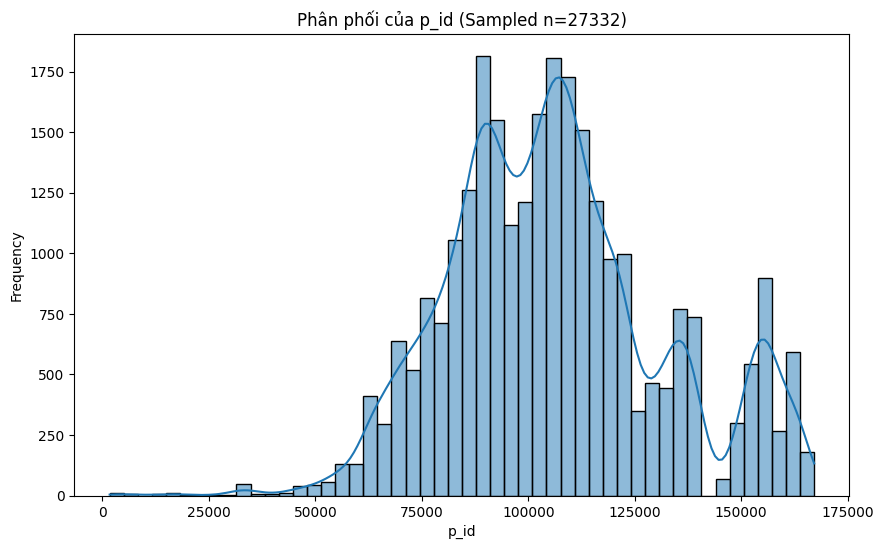

Lỗi khi lấy mẫu (có thể do kích thước mẫu > tổng số hàng): cannot take a larger sample than the total population when `with_replacement=false`


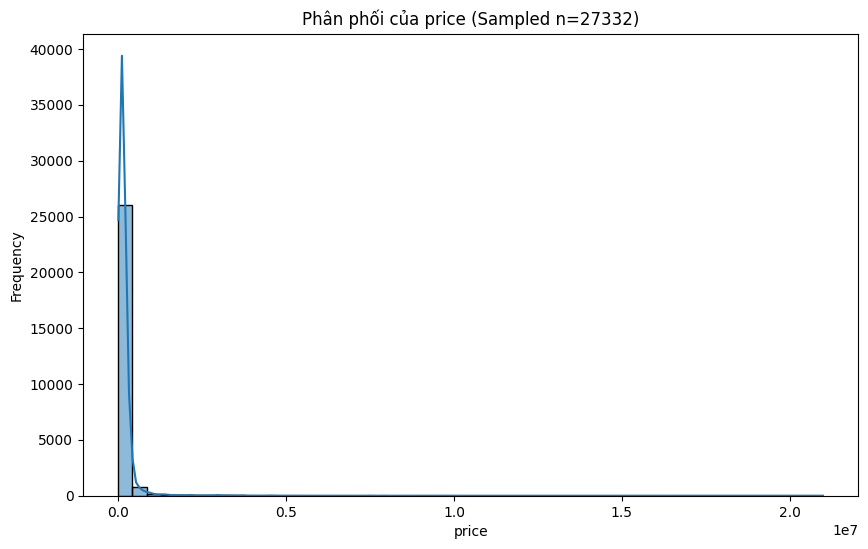

Lỗi khi lấy mẫu (có thể do kích thước mẫu > tổng số hàng): cannot take a larger sample than the total population when `with_replacement=false`


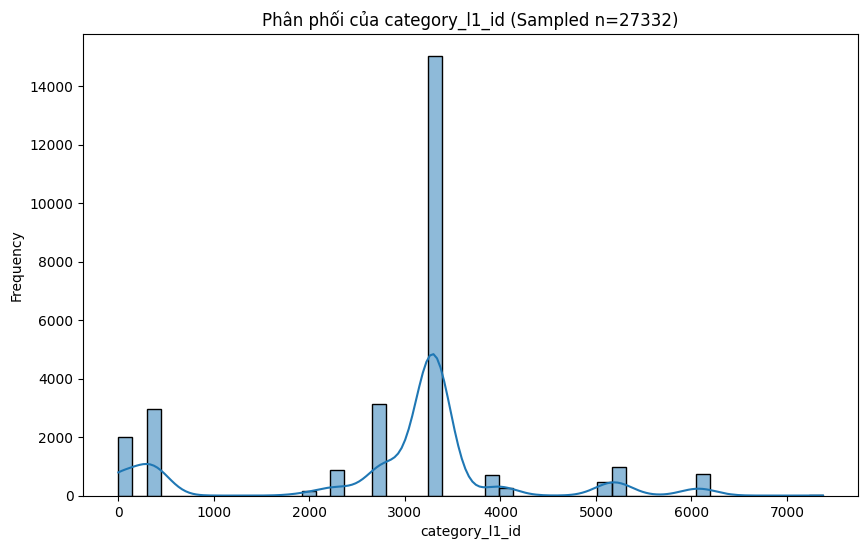

Lỗi khi lấy mẫu (có thể do kích thước mẫu > tổng số hàng): cannot take a larger sample than the total population when `with_replacement=false`


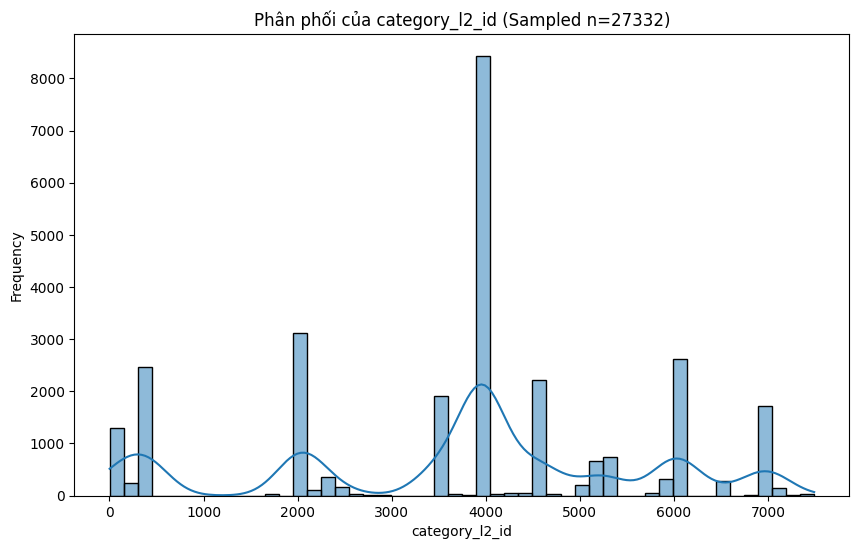

Lỗi khi lấy mẫu (có thể do kích thước mẫu > tổng số hàng): cannot take a larger sample than the total population when `with_replacement=false`


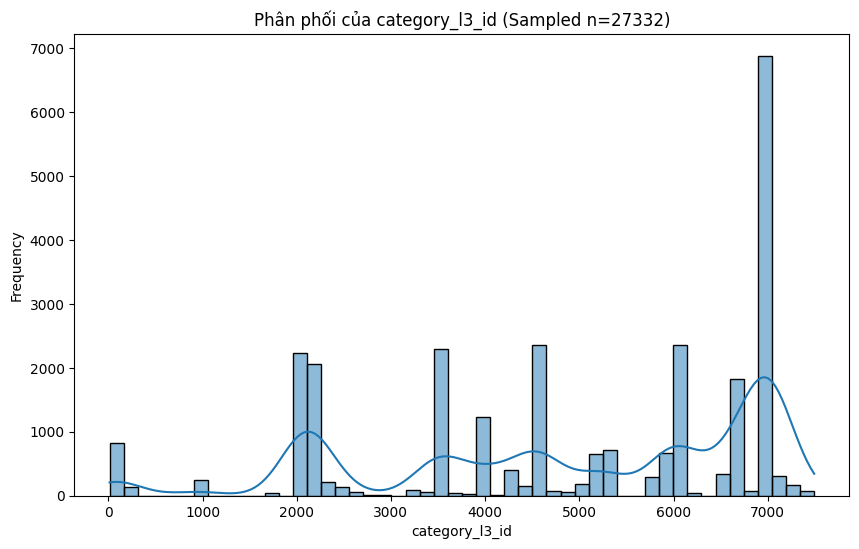

Lỗi khi lấy mẫu (có thể do kích thước mẫu > tổng số hàng): cannot take a larger sample than the total population when `with_replacement=false`


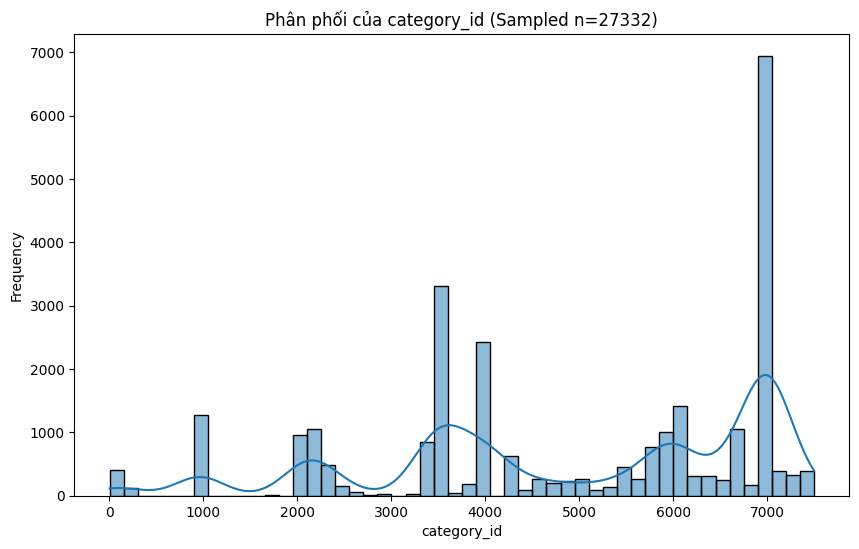

Lỗi khi lấy mẫu (có thể do kích thước mẫu > tổng số hàng): cannot take a larger sample than the total population when `with_replacement=false`


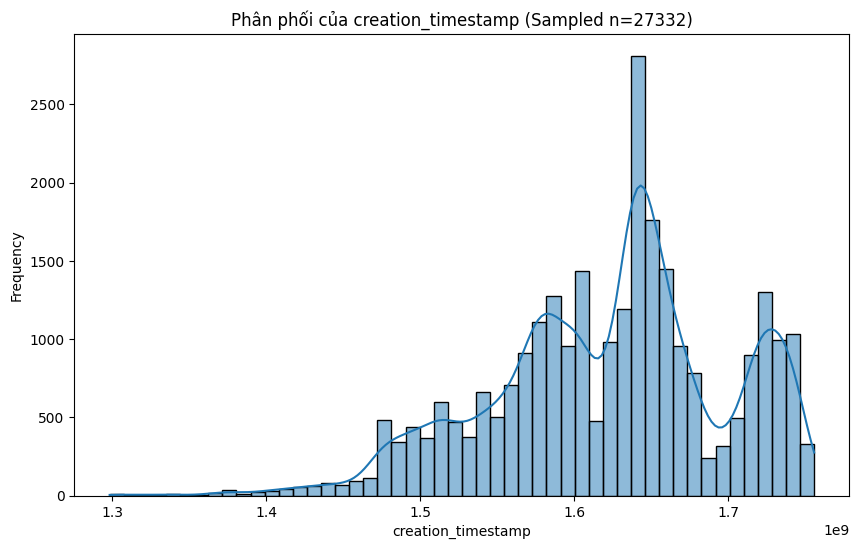

Lỗi khi lấy mẫu (có thể do kích thước mẫu > tổng số hàng): cannot take a larger sample than the total population when `with_replacement=false`


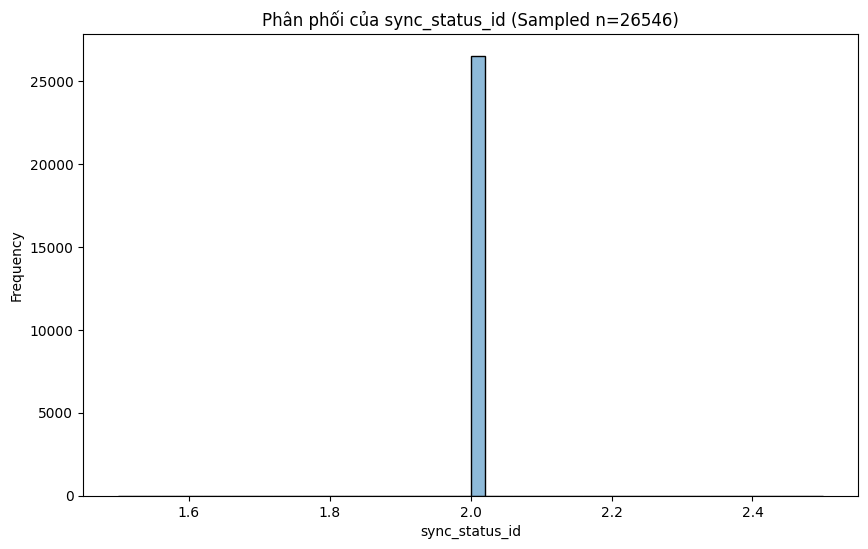

Lỗi khi lấy mẫu (có thể do kích thước mẫu > tổng số hàng): cannot take a larger sample than the total population when `with_replacement=false`


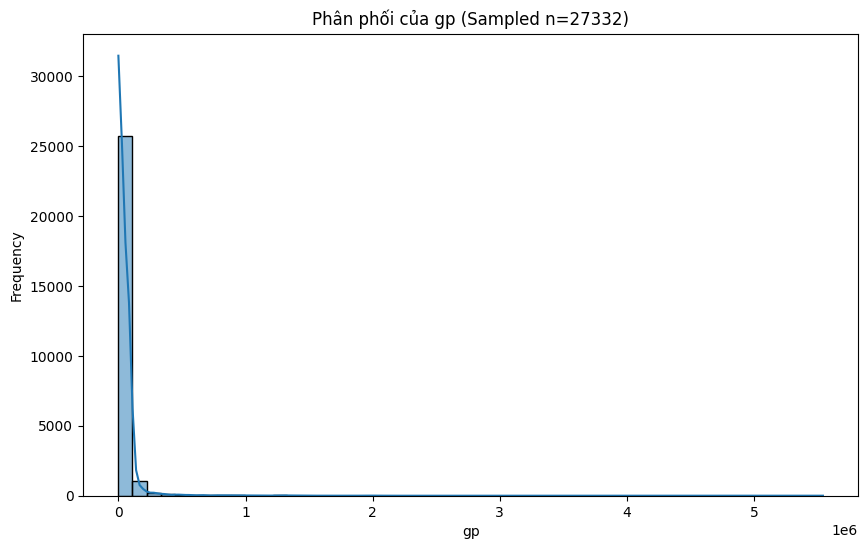

Lỗi khi lấy mẫu (có thể do kích thước mẫu > tổng số hàng): cannot take a larger sample than the total population when `with_replacement=false`
Không có dữ liệu non-null để vẽ cho 'weight'.
Lỗi khi lấy mẫu (có thể do kích thước mẫu > tổng số hàng): cannot take a larger sample than the total population when `with_replacement=false`


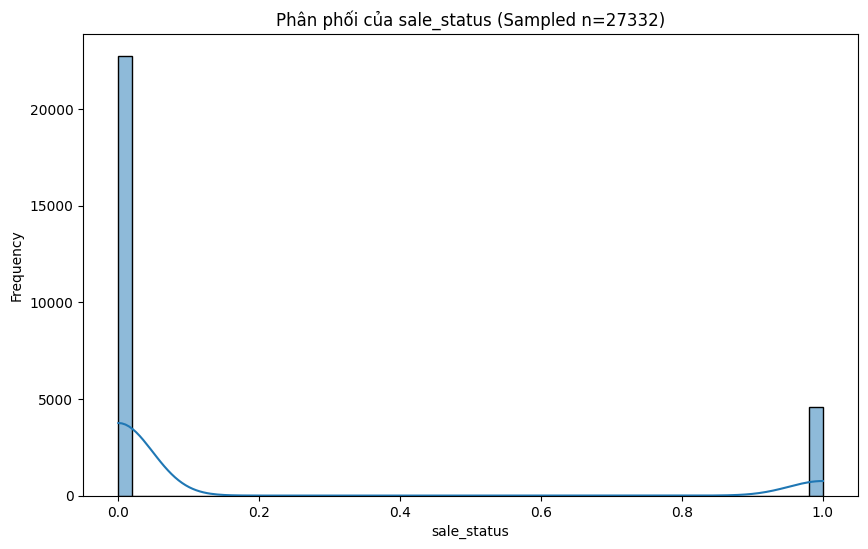

Đang lấy giá trị cho cột 'item_id'...


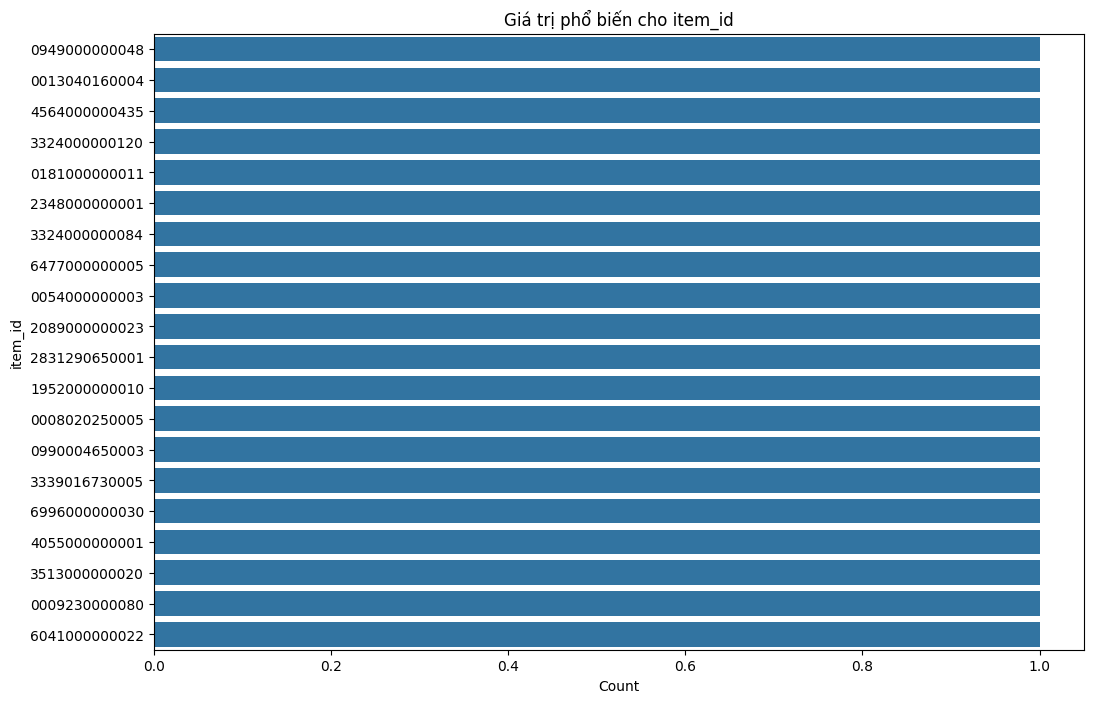

Đang lấy giá trị cho cột 'category_l1'...


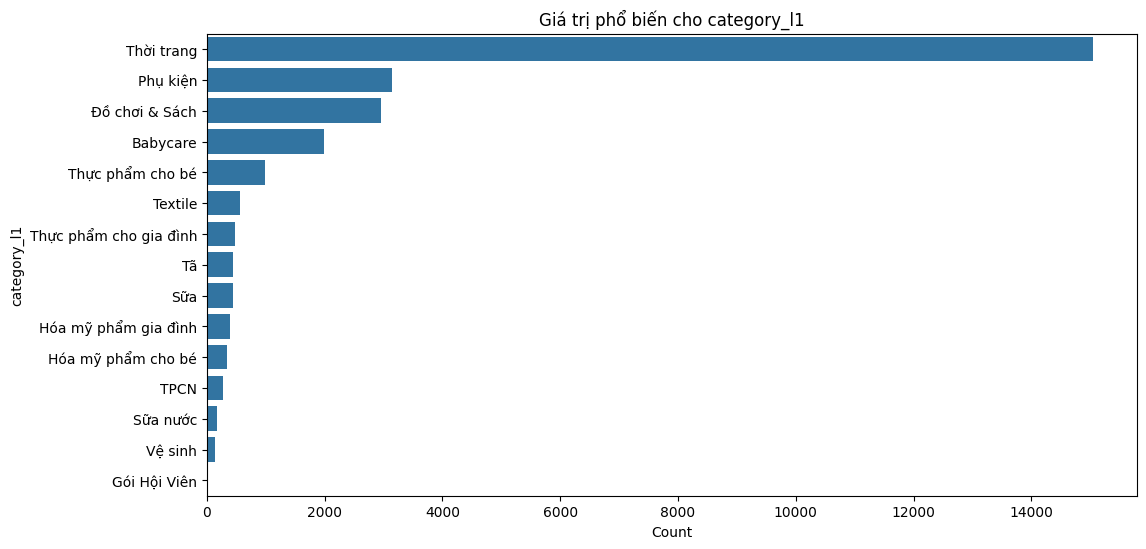

Đang lấy giá trị cho cột 'category_l2'...


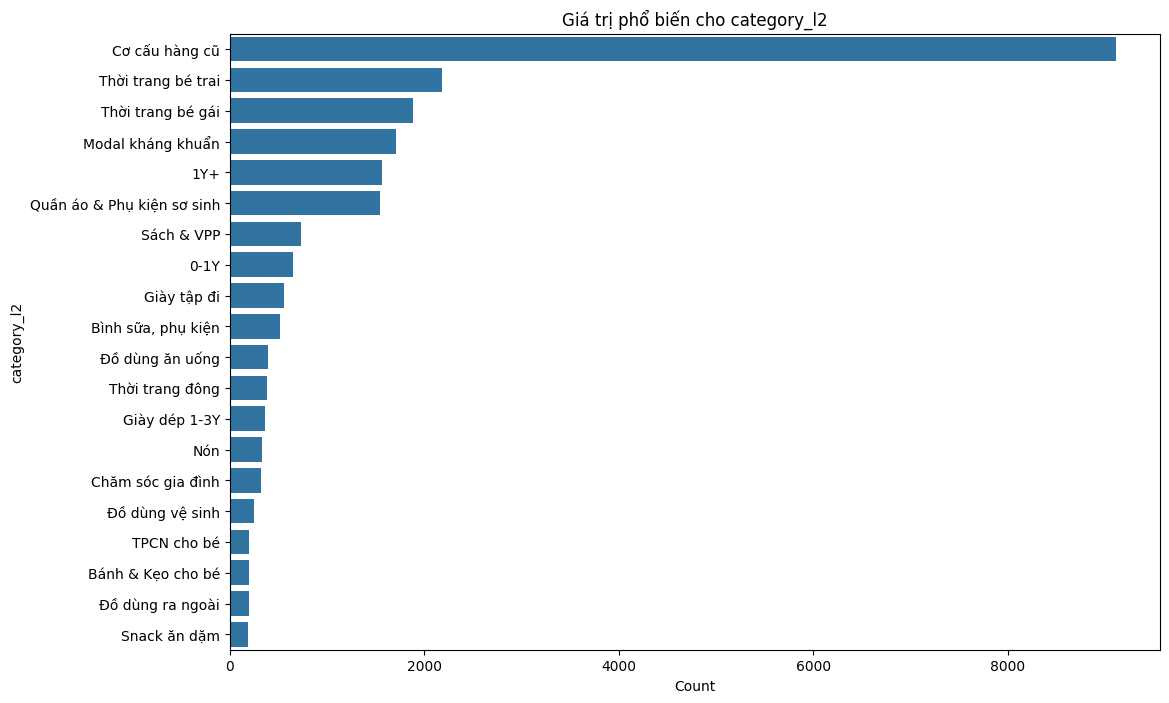

Đang lấy giá trị cho cột 'category_l3'...


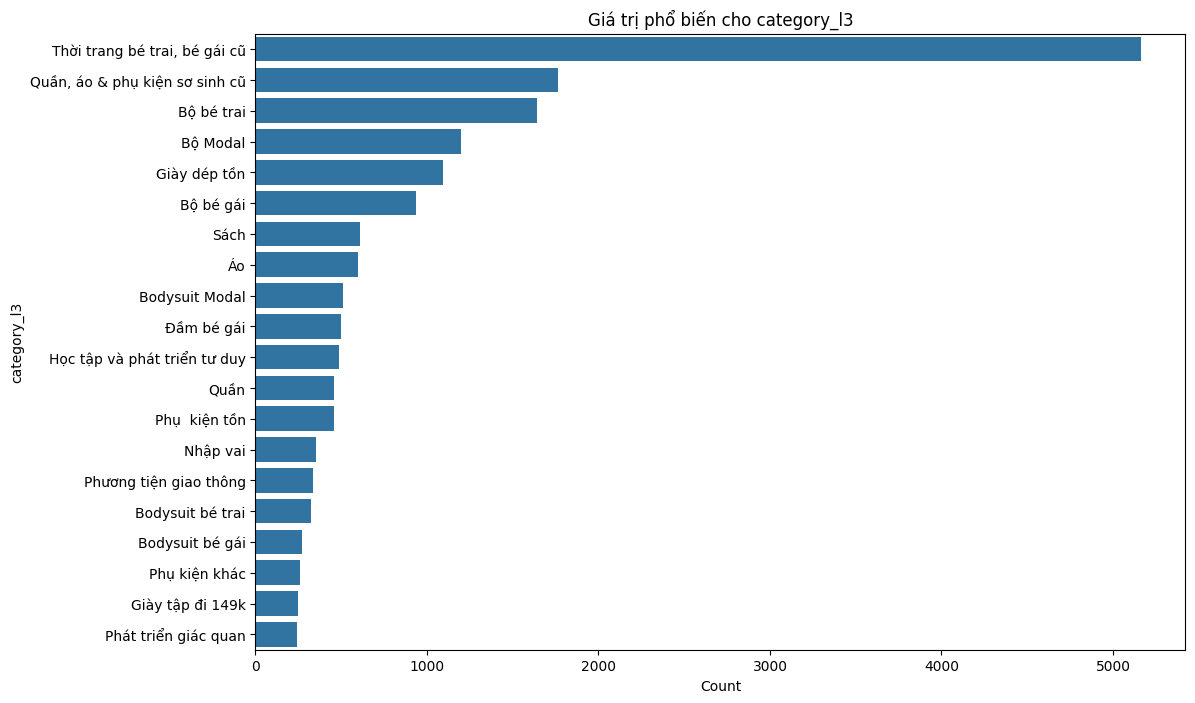

Đang lấy giá trị cho cột 'category'...


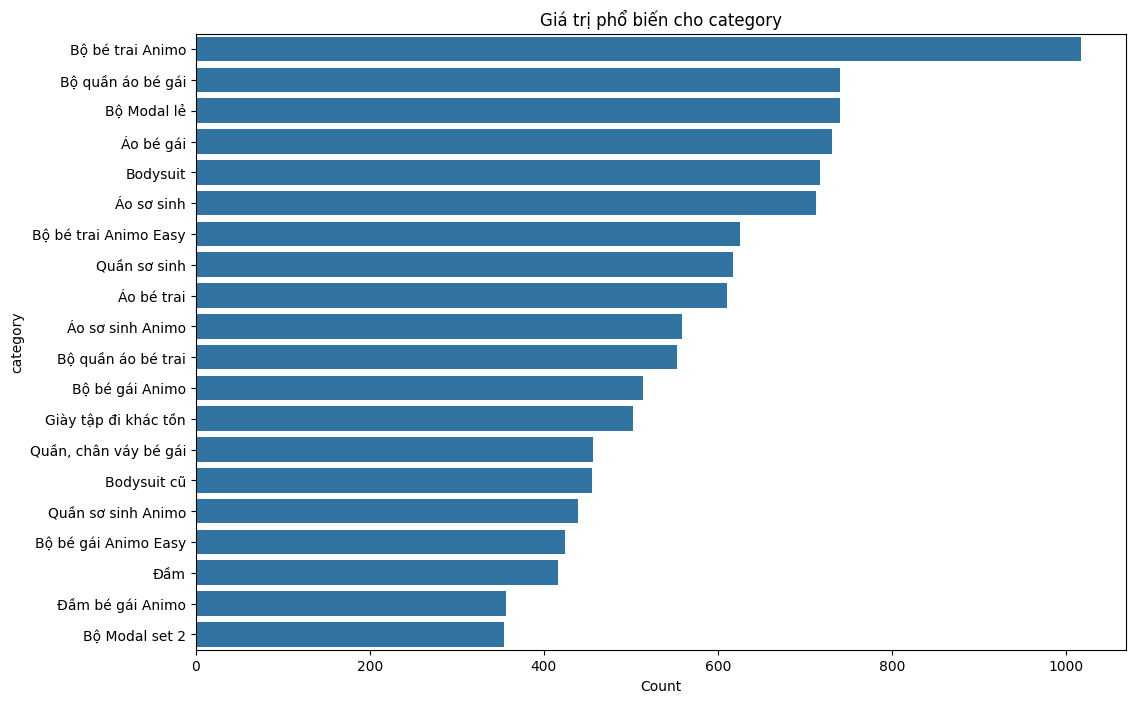

Đang lấy giá trị cho cột 'description'...


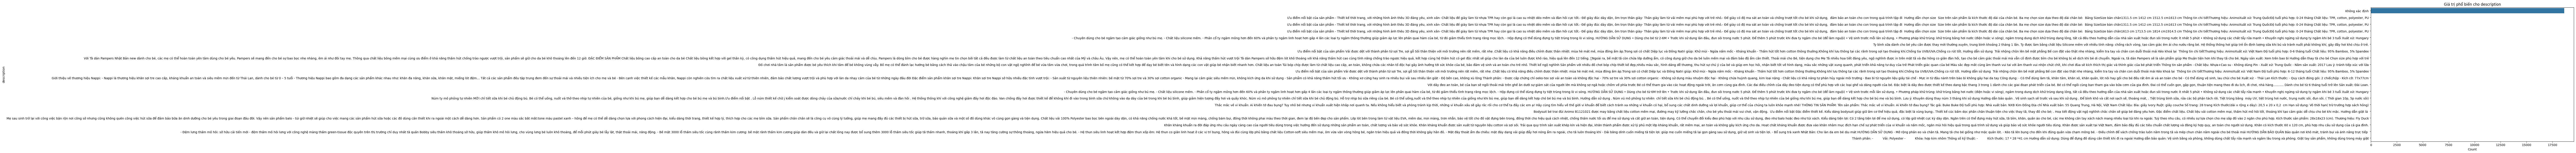

Đang lấy giá trị cho cột 'brand'...


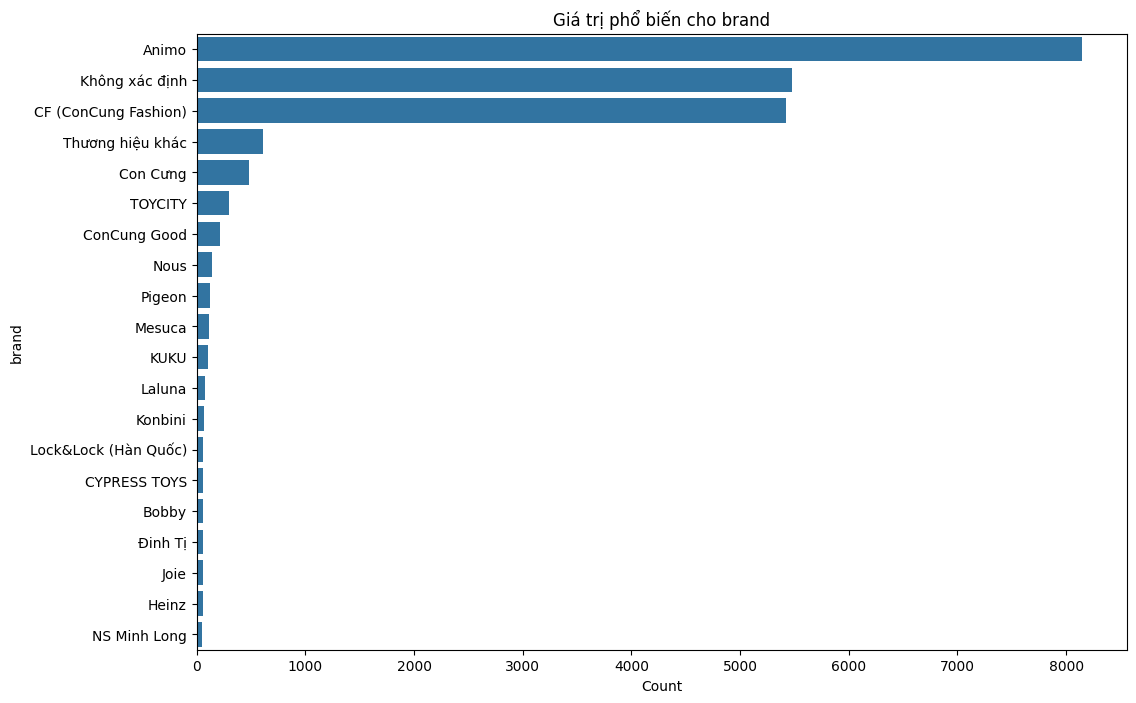

Đang lấy giá trị cho cột 'manufacturer'...


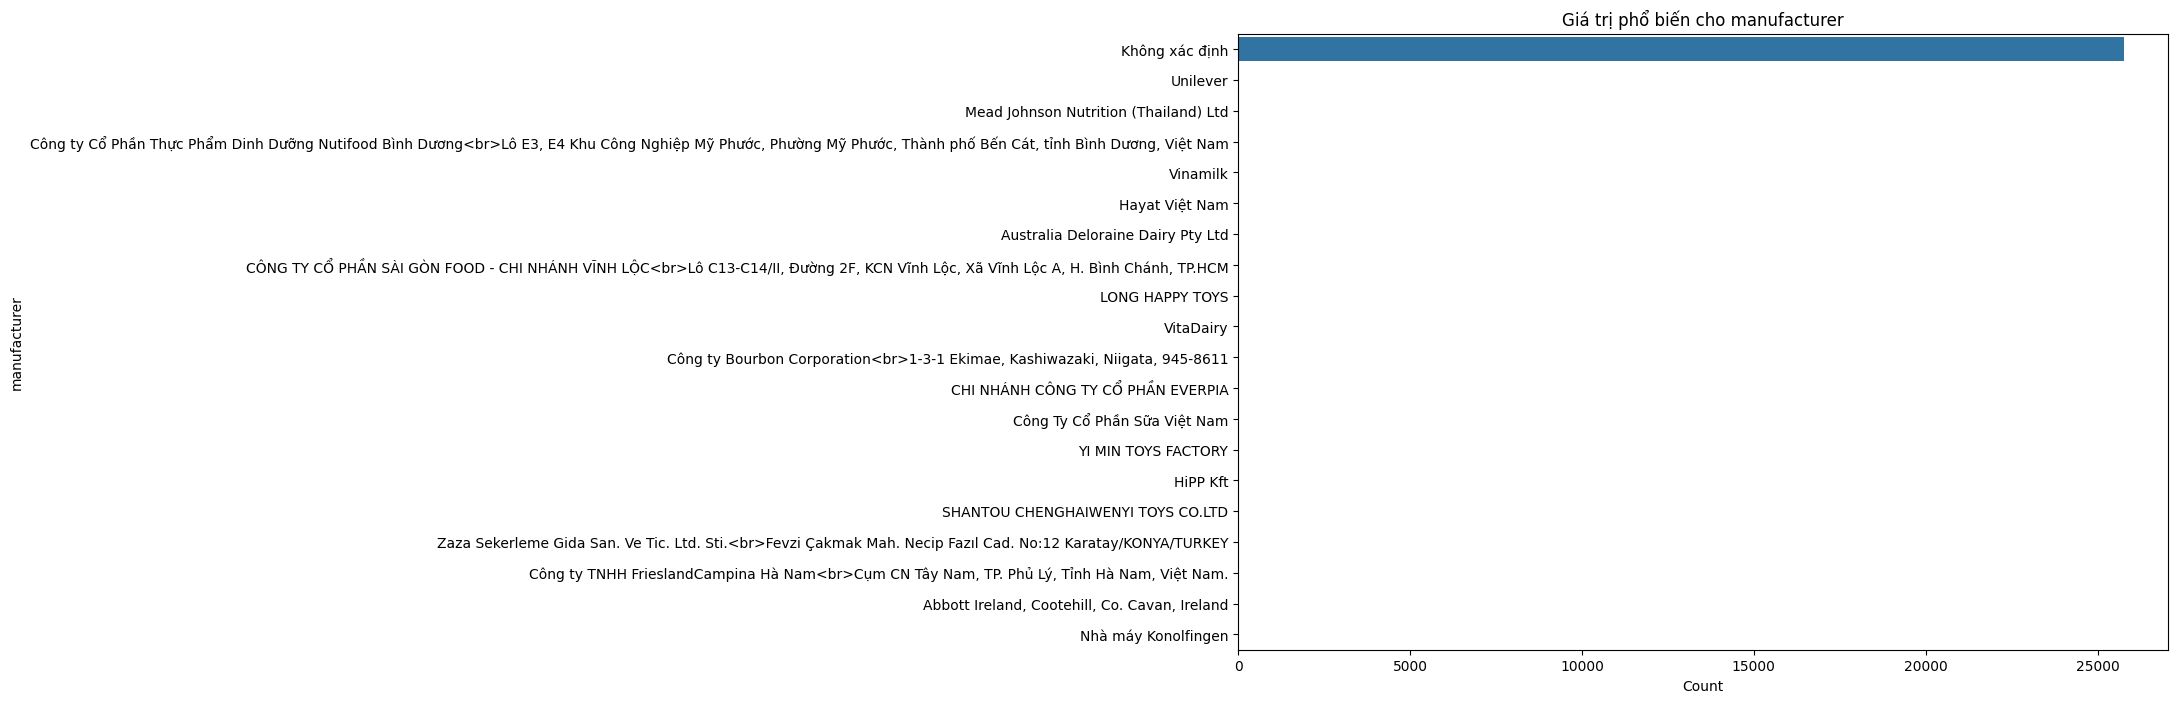

Đang lấy giá trị cho cột 'is_deleted'...


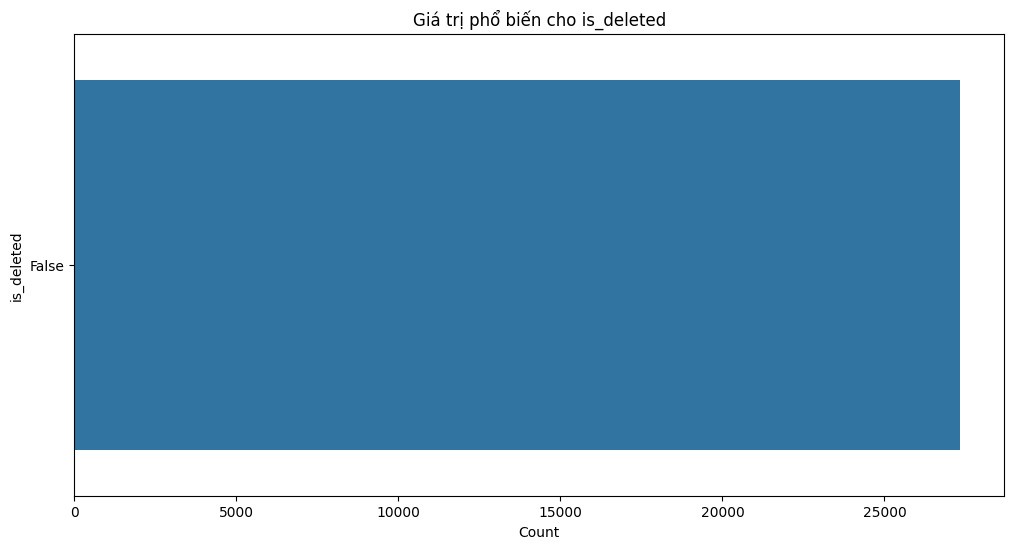

Đang lấy giá trị cho cột 'sync_error_message'...


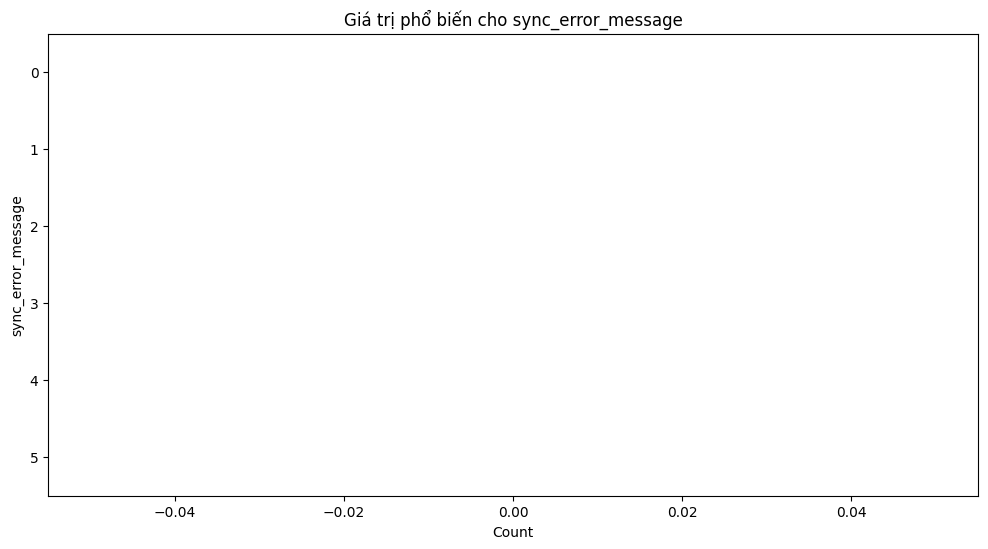

Đang lấy giá trị cho cột 'image_url'...


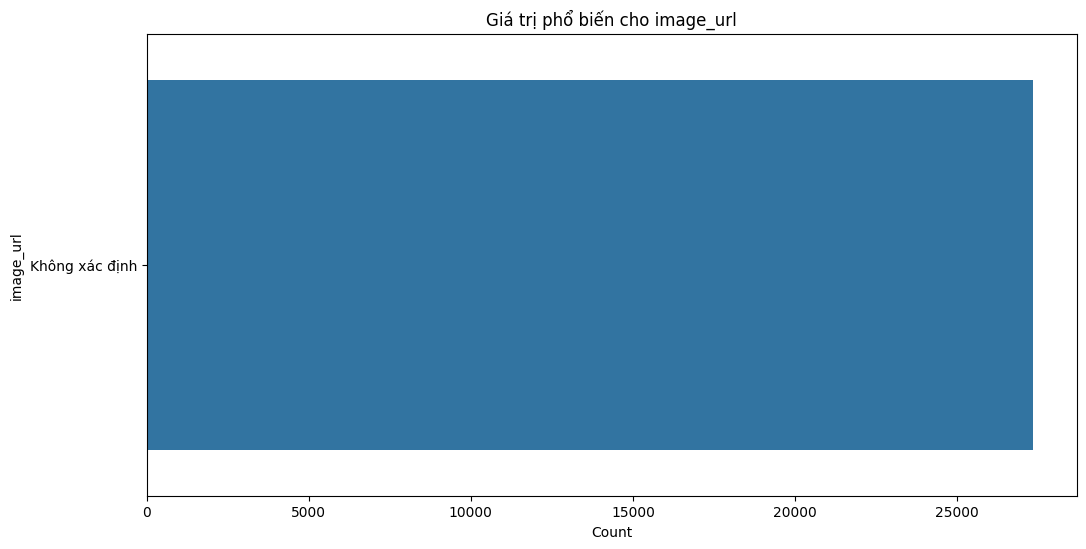

Đang lấy giá trị cho cột 'gender_target'...


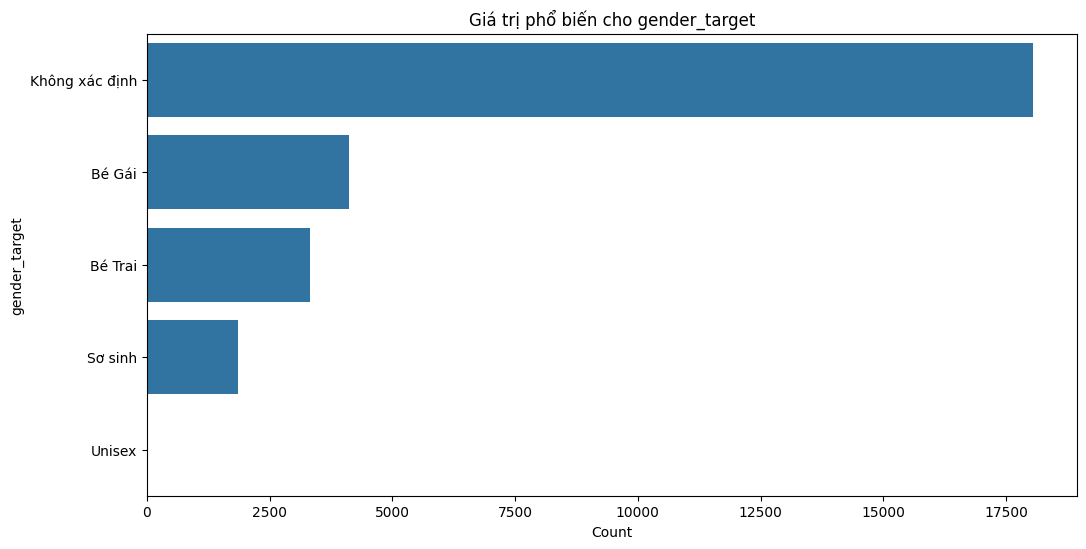

Đang lấy giá trị cho cột 'age_group'...


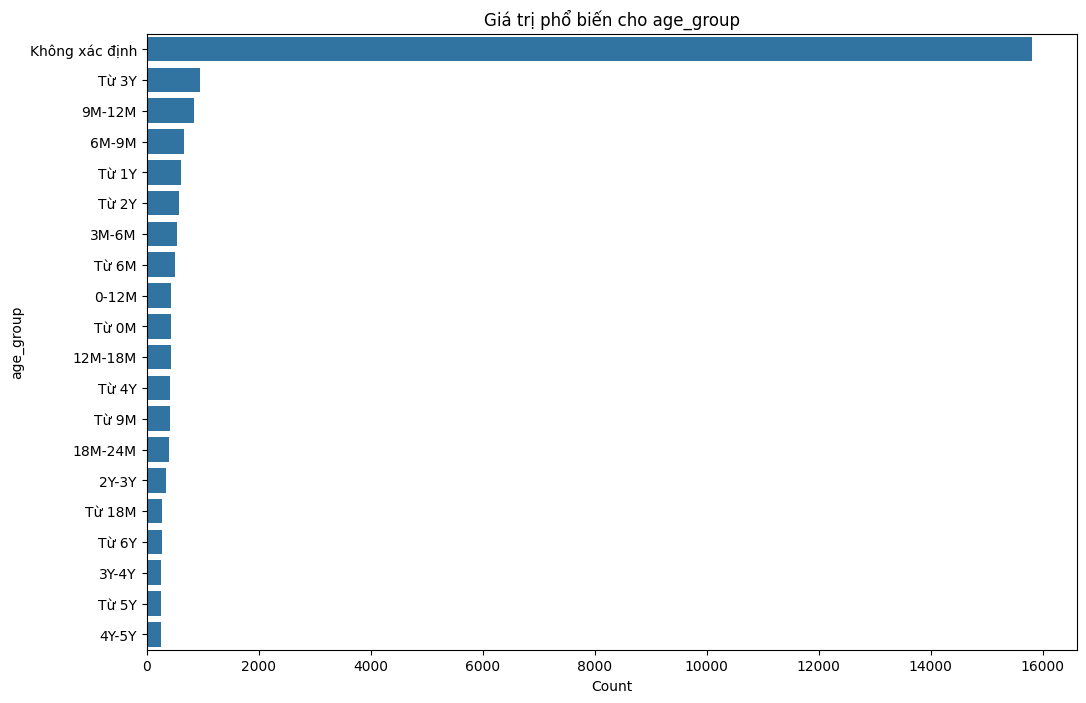

Đang lấy giá trị cho cột 'item_type'...


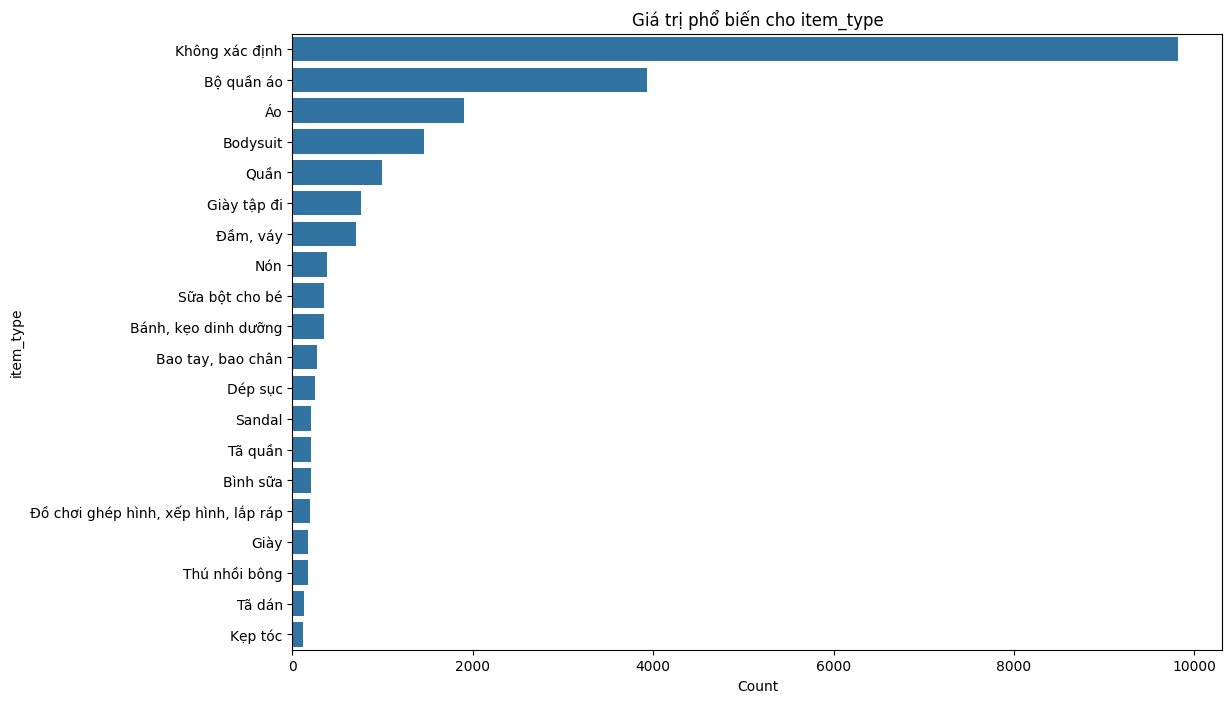

Đang lấy giá trị cho cột 'color'...


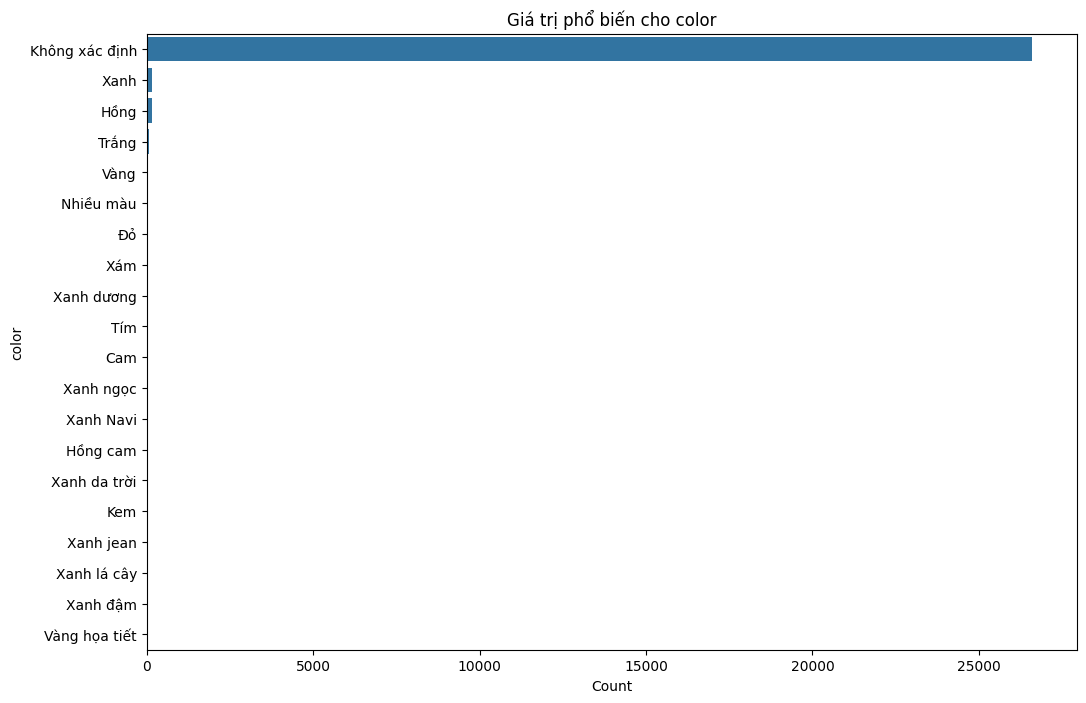

Đang lấy giá trị cho cột 'size'...


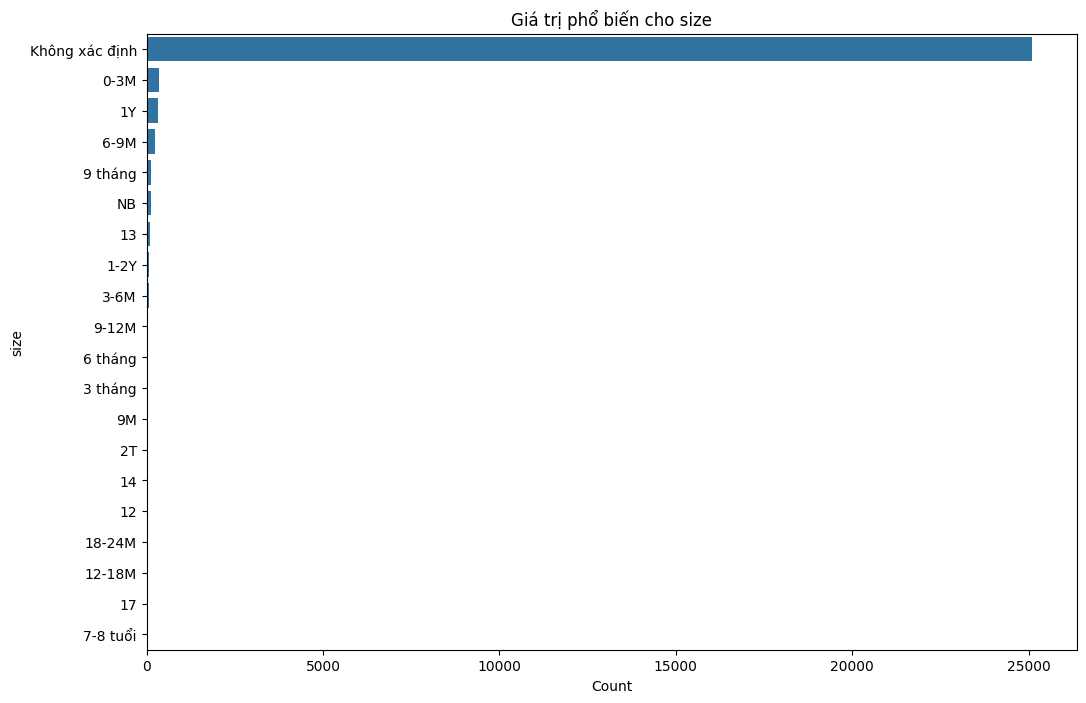

Đang lấy giá trị cho cột 'origin'...


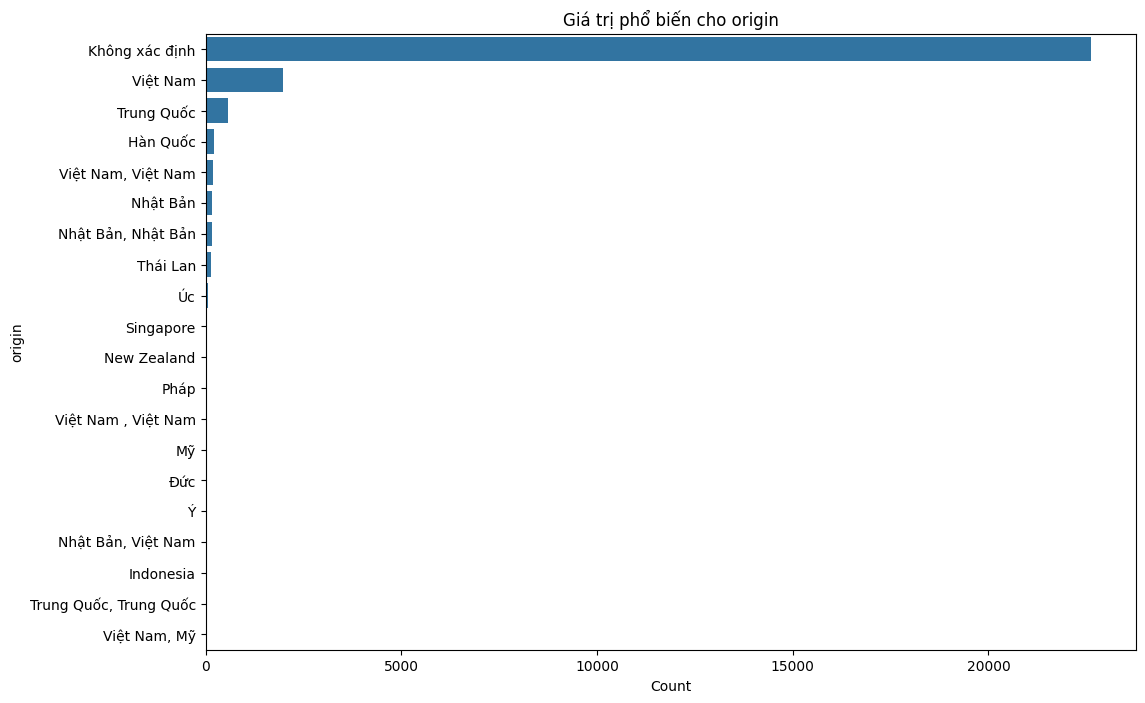

Đang lấy giá trị cho cột 'volume'...


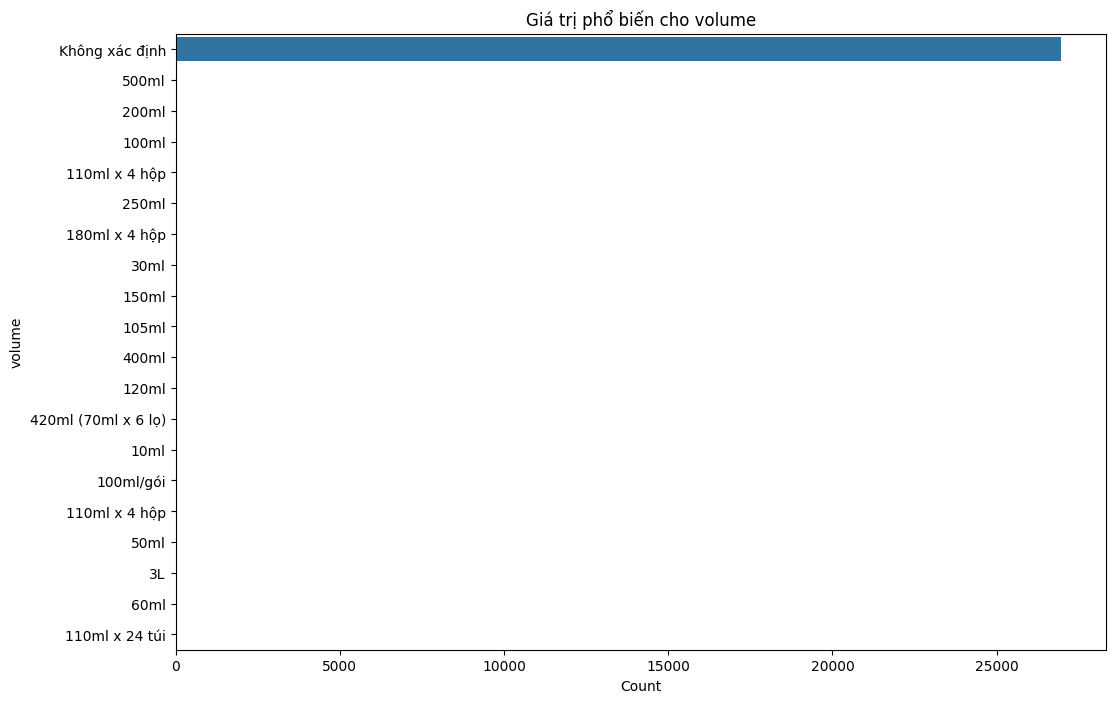

Đang lấy giá trị cho cột 'material'...


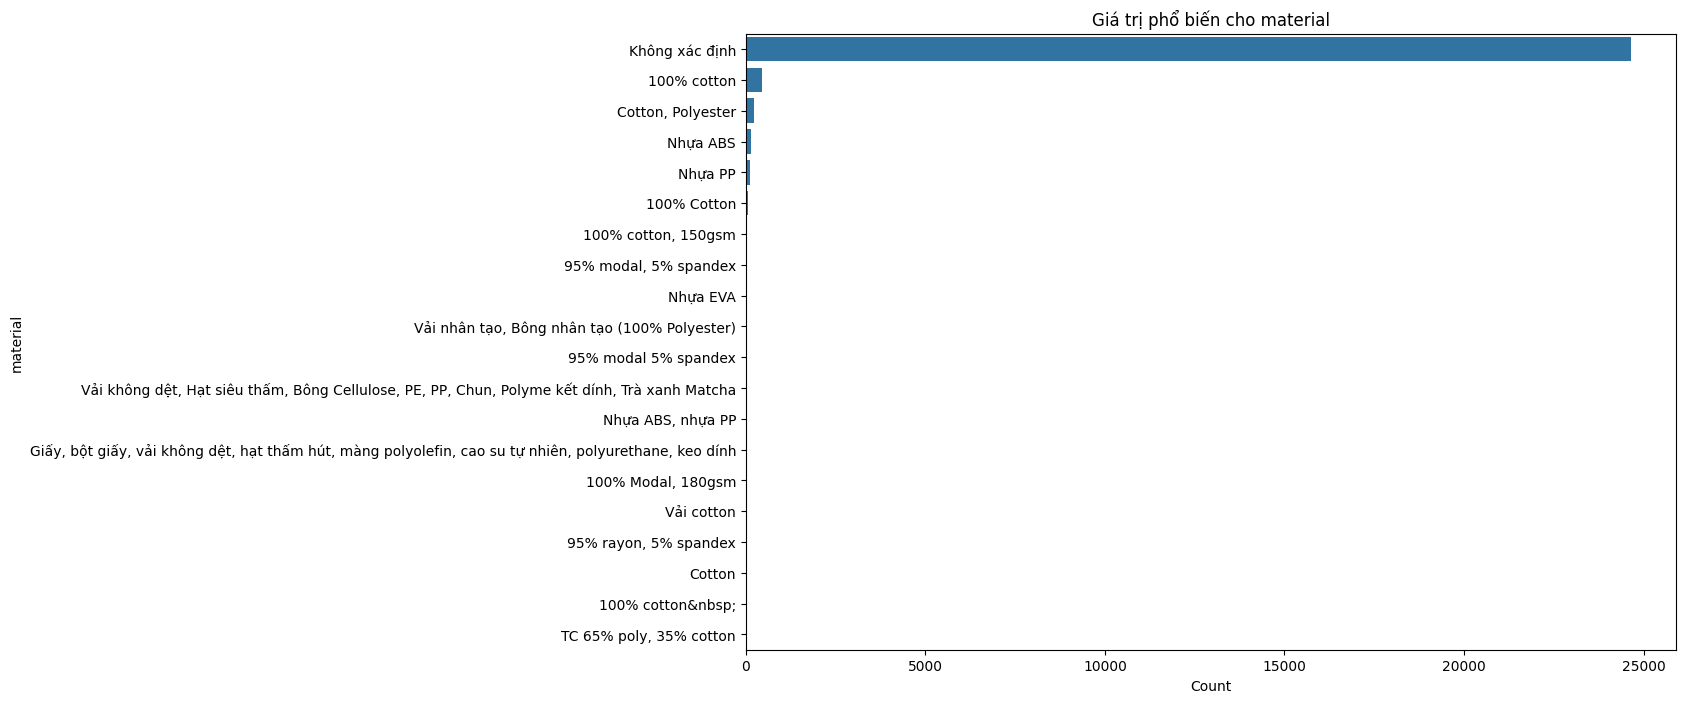

Đang lấy giá trị cho cột 'description_new'...


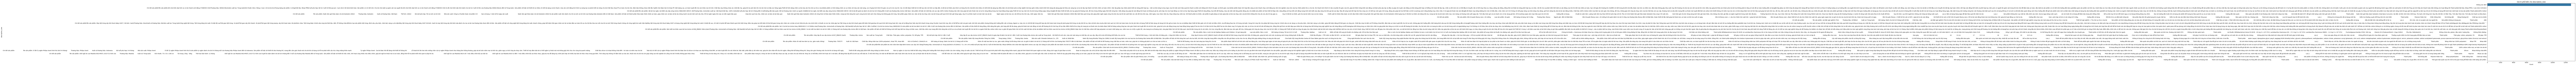

In [ ]:
# 1. Xem tóm tắt schema (giống .info() + nulls)
items_summary = eda_items.summarize_schema()
display(items_summary)

# 2. Xem tóm tắt các cột số (nếu có)
items_numeric_summary = eda_items.get_numeric_summary()
display(items_numeric_summary)

# 3. Xem các giá trị phổ biến nhất cho một cột
for col in eda_items._get_categorical_cols():
  items_value_counts = eda_items.get_value_counts(col)
  display(items_value_counts)

# 4. Vẽ biểu đồ phân phối cho 'age' (sẽ lấy mẫu)
for col in eda_items._get_numeric_cols():
  eda_items.plot_numeric_distribution(col)



# 5. Vẽ biểu đồ bar plot cho 'gender'
for col in eda_items._get_categorical_cols():
  eda_items.plot_categorical_distribution(col)

##EDA đa biến

In [ ]:
def plot_table_correlation(lf_table: pl.LazyFrame, name: str, limit_rows: int = 200_000, sample_fraction: float = 0.25):
    """
    Tạo biểu đồ heatmap tương quan cho bảng dữ liệu từ LazyFrame Polars.

    Tham số:
    ----------
    lf_table : pl.LazyFrame
        LazyFrame của bảng (ví dụ lf_purchases, lf_users, lf_items)
    name : str
        Tên bảng để hiển thị trong tiêu đề biểu đồ
    limit_rows : int, optional
        Giới hạn số dòng đọc từ LazyFrame (default=200_000)
    sample_fraction : float, optional
        Tỷ lệ mẫu lấy ngẫu nhiên sau khi load (default=0.25)
    """
    t0 = time.time()

    # Lấy sample nhỏ từ LazyFrame
    df = lf_table.limit(limit_rows).collect()
    sample_df = df.sample(fraction=sample_fraction, seed=42)

    # Chuẩn hóa kiểu dữ liệu
    def try_cast_to_numeric(s: pl.Series) -> pl.Series:
        try:
            return s.cast(pl.Float64)
        except Exception:
            try:
                return pl.Series(s.name, pl.Series(s).to_pandas().astype(str).str.replace(",", "").astype(float))
            except Exception:
                return s

    sample_df = sample_df.with_columns([
        try_cast_to_numeric(sample_df[c]).alias(c)
        for c in sample_df.columns
    ])

    # Nhận diện loại cột
    num_cols = [c for c, dtype in zip(sample_df.columns, sample_df.dtypes)
                if dtype in pl.NUMERIC_DTYPES]
    bool_cols = [c for c, dtype in zip(sample_df.columns, sample_df.dtypes)
                 if dtype == pl.Boolean]
    cat_cols = [c for c, dtype in zip(sample_df.columns, sample_df.dtypes)
                if dtype in (pl.Utf8, pl.Categorical)]

    # Label encode các cột category
    encoded_series = []
    for c in cat_cols:
        s = sample_df[c].cast(pl.Categorical)
        codes = s.to_physical()
        encoded_series.append(codes.rename(c))

    encoded_df = pl.DataFrame({s.name: s for s in encoded_series}) if encoded_series else pl.DataFrame()

    # Gộp numeric + boolean + encoded
    parts = [sample_df.select(num_cols + bool_cols)]
    if len(encoded_df.columns) > 0:
        parts.append(encoded_df)
    df_encoded = pl.concat(parts, how="horizontal")

    # Tính correlation
    pd_df = df_encoded.to_pandas()
    corr = pd_df.corr(numeric_only=True)

    # Vẽ heatmap
    plt.figure(figsize=(12, 10))
    sns.heatmap(
        corr,
        cmap="coolwarm",
        center=0,
        annot=True,
        fmt=".2f",
        annot_kws={"size": 8},
        cbar_kws={"shrink": 0.7},
    )
    plt.title(f"Correlation Heatmap — {name}")
    plt.tight_layout()
    plt.show()

### EDA đa biến cho bảng lf_purchases

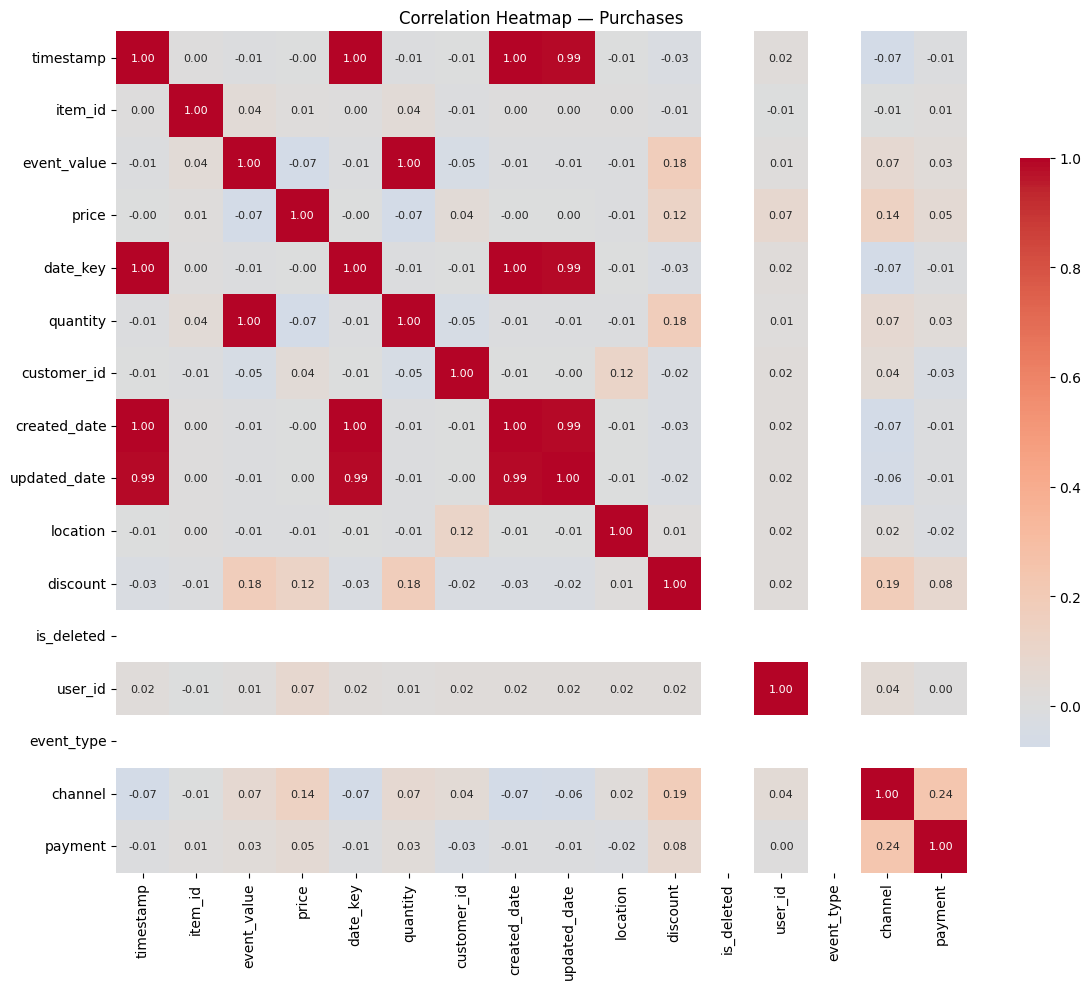

In [ ]:
plot_table_correlation(lf_purchases, "Purchases")

In [ ]:
def analyze_purchases_multivariate(
    lf_purchases: pl.LazyFrame,
    table_name: str = "purchases",
    limit_rows: int = 100_000_000,
    sample_n: int = 1_000_000,
    top_k_items: int = 10,
    do_pca_cluster: bool = False,
    random_seed: int = 42,
):
    t0 = time.time()

    # Lấy sample nhẹ để vẽ các biểu đồ cần
    df = lf_purchases.limit(limit_rows).collect()
    n_total = df.height
    n_sample = min(sample_n, n_total)
    sample_df = df.sample(n=n_sample, seed=random_seed) if n_sample < n_total else df
    pdf = sample_df.to_pandas()

    # Chuẩn hóa numeric
    for c in ["price", "quantity", "discount", "event_value"]:
        if c in pdf.columns:
            pdf[c] = pd.to_numeric(pdf[c], errors="coerce")

    pdf["total_value"] = pdf.get("price", 0) * pdf.get("quantity", 0)

    # Thêm time feature
    if "created_date" in pdf.columns:
        pdf["created_time"] = pd.to_datetime(pdf["created_date"], errors="coerce")
    elif "timestamp" in pdf.columns:
        pdf["created_time"] = pd.to_datetime(pd.to_numeric(pdf["timestamp"], errors="coerce"), unit="s", errors="coerce")
    elif "date_key" in pdf.columns:
        pdf["created_time"] = pd.to_datetime(pdf["date_key"].astype(str), format="%Y%m%d", errors="coerce")
    else:
        pdf["created_time"] = pd.NaT

    pdf["hour"] = pdf["created_time"].dt.hour
    pdf["weekday"] = pdf["created_time"].dt.day_name()

    # Payment theo Channel (toàn bộ dữ liệu, không sample)
    if {"channel", "payment"} <= set(lf_purchases.columns):
        agg_df = (
            lf_purchases
            .group_by(["channel", "payment"])
            .agg(pl.len().alias("count"))
            .with_columns(
                (pl.col("count") / pl.col("count").sum().over("channel")).alias("ratio")
            )
            .collect()
            .to_pandas()
        )

        df_pivot = agg_df.pivot_table(
            index="channel",
            columns="payment",
            values="ratio",
            fill_value=0
        )

        df_pivot.plot(kind="barh", stacked=True, figsize=(8, 5), colormap="tab10")
        plt.title(f"{table_name}: Phân bố Payment theo Channel (toàn bộ dữ liệu)")
        plt.xlabel("Tỉ trọng")
        plt.ylabel("Channel")
        plt.legend(title="Payment", bbox_to_anchor=(1.05, 0.5), loc="center left")
        plt.tight_layout()
        plt.show()

    # Discount theo nhóm Quantity (chỉ dùng sample_df)
    if {"discount", "quantity"} <= set(sample_df.columns):
        discq2 = (
            sample_df
            .select([
                pl.col("discount").cast(pl.Float64),
                pl.col("quantity").cast(pl.Int32)
            ])
            .with_columns(
                pl.when(pl.col("quantity") <= 5).then(pl.lit("≤5"))
                 .when(pl.col("quantity") <= 10).then(pl.lit("6–10"))
                 .when(pl.col("quantity") <= 20).then(pl.lit("11–20"))
                 .otherwise(pl.lit(">20")).alias("qty_bucket")
            )
            .to_pandas()
        )

        sns.boxplot(data=discq2, x="qty_bucket", y="discount", showfliers=False)
        plt.title(f"{table_name}: Discount theo nhóm Quantity")
        plt.xlabel("Nhóm Quantity")
        plt.ylabel("Discount")
        plt.tight_layout()
        plt.show()

    # Các biểu đồ khác (giữ nguyên)
    if "discount" in pdf.columns and "total_value" in pdf.columns:
        plt.figure(figsize=(8, 6))
        sns.scatterplot(data=pdf, x="discount", y="total_value", hue="channel", alpha=0.5, edgecolor=None)
        plt.title(f"{table_name}: Discount vs Total Value by Channel")
        plt.tight_layout()
        plt.show()

    if "hour" in pdf.columns and pdf["hour"].notna().any():
        plt.figure(figsize=(10, 4))
        sns.countplot(data=pdf, x="hour", hue="channel", order=sorted(pdf["hour"].dropna().unique()))
        plt.title(f"{table_name}: Transactions by Hour and Channel")
        plt.tight_layout()
        plt.show()

    if "price" in pdf.columns and "payment" in pdf.columns:
        plt.figure(figsize=(10, 5))
        sns.boxplot(data=pdf, x="payment", y="price")
        plt.title(f"{table_name}: Price distribution by Payment")
        plt.xticks(rotation=30)
        plt.tight_layout()
        plt.show()

    if "item_id" in pdf.columns:
        top_items = pdf["item_id"].value_counts().nlargest(top_k_items).index.tolist()
        subset = pdf[pdf["item_id"].isin(top_items)].copy()
        if not subset.empty and "payment" in subset.columns:
            plt.figure(figsize=(10, 6))
            sns.countplot(data=subset, y="item_id", hue="payment", order=top_items)
            plt.title(f"{table_name}: Payment methods for Top {top_k_items} Items")
            plt.tight_layout()
            plt.show()

    if "created_time" in pdf.columns and pdf["created_time"].notna().any():
        daily = pdf.dropna(subset=["created_time"]).set_index("created_time").resample("D")["total_value"].sum()
        if not daily.empty:
            plt.figure(figsize=(12, 4))
            daily.plot()
            plt.title(f"{table_name}: Daily Total Value")
            plt.tight_layout()
            plt.show()

    print(f"Hoàn tất {table_name}: {n_sample}/{n_total} rows | Elapsed {time.time()-t0:.1f}s")
    return pdf


In [ ]:
analyze_purchases_multivariate(lf_purchases, table_name="purchases")

### EDA đa biến cho bảng lf_users

In [ ]:
plot_table_correlation(lf_users, "Users")

In [ ]:
def analyze_users_multivariate(lf_users: pl.LazyFrame, table_name: str = "users"):
    """
    Phân tích đa biến cho bảng người dùng (lf_users) — phiên bản tối ưu, không cần sample.
    """
    # --- Membership × Gender ---
    print("\nPhân bố membership theo giới tính:")
    df1 = (
        lf_users
        .group_by(["membership", "gender"])
        .agg(pl.count().alias("count"))
        .with_columns(
            (pl.col("count") / pl.sum("count").over("membership")).alias("ratio")
        )
        .collect()
    )

    sns.barplot(data=df1.to_pandas(), x="membership", y="ratio", hue="gender")
    plt.title("Tỉ lệ giới tính theo hạng thành viên")
    plt.ylabel("Tỉ trọng")
    plt.tight_layout()
    plt.show()

    # --- Membership × Region ---
    print("\nPhân bố membership theo vùng (region):")
    df2 = (
        lf_users
        .group_by(["region", "membership"])
        .agg(pl.count().alias("count"))
        .with_columns(
            (pl.col("count") / pl.sum("count").over("region")).alias("ratio")
        )
        .collect()
    )

    pivot2 = (
        df2.pivot(index="region", columns="membership", values="ratio")
        .fill_null(0)
        .sort("region")
    )
    sns.heatmap(pivot2.to_pandas().set_index("region"), annot=True, fmt=".1%", cmap="Blues")
    plt.title("Tỉ lệ Membership theo Region")
    plt.xlabel("Membership")
    plt.ylabel("Region")
    plt.tight_layout()
    plt.show()

    # --- Install app × Region ---
    print("\nTỉ lệ cài đặt app theo vùng:")
    df3 = (
        lf_users
        .group_by(["region", "install_app"])
        .agg(pl.count().alias("count"))
        .with_columns(
            (pl.col("count") / pl.sum("count").over("region")).alias("ratio")
        )
        .collect()
    )

    plt.figure(figsize=(10, 6))
    sns.barplot(
        data=df3.to_pandas(),
        x="region",
        y="ratio",
        hue="install_app"
    )
    plt.xticks(rotation=45, ha="right")
    plt.title("Tỉ lệ cài đặt app theo vùng")
    plt.ylabel("Tỉ trọng")

    # Chuyển legend ra ngoài để không che biểu đồ
    plt.legend(
        title="Kênh cài đặt",
        bbox_to_anchor=(1.02, 1),
        loc="upper left",
        borderaxespad=0,
        ncol=2,          # chia legend làm 2 cột để gọn hơn
        fontsize=9,
        title_fontsize=10
    )

    plt.tight_layout(rect=[0, 0, 0.85, 1])  # chừa không gian bên phải cho legend
    plt.show()

    # --- Install app × Gender ---
    print("\nPhân bố giới tính theo trạng thái cài app:")
    df4 = (
        lf_users
        .with_columns(pl.col("install_app").cast(pl.Utf8))  # ép kiểu chuỗi
        .group_by(["install_app", "gender"])
        .agg(pl.count().alias("count"))
        .with_columns(
            (pl.col("count") / pl.sum("count").over("install_app")).alias("ratio")
        )
        .collect()
    )

    pivot_df = (
        df4.pivot(index="install_app", columns="gender", values="ratio")
        .fill_null(0)
    )

    pdf = pivot_df.to_pandas().set_index("install_app")  # giữ nhãn chuỗi làm index

    pdf.plot(
        kind="barh",
        stacked=True,
        figsize=(8, 5),
        colormap="Set2",
        edgecolor="none"
    )
    plt.title("Tỉ lệ giới tính theo trạng thái cài app", fontsize=13)
    plt.xlabel("Tỉ trọng (%)")
    plt.ylabel("Trạng thái cài app")
    plt.legend(title="Giới tính", bbox_to_anchor=(1.05, 0.5), loc="center left")
    plt.tight_layout()
    plt.show()

In [ ]:
analyze_users_multivariate(lf_users, table_name="users")

### EDA đa biên cho bảng lf_items

In [ ]:
plot_table_correlation(lf_items, "Items")

In [ ]:
def analyze_items_multivariate(
    lf_items: pl.LazyFrame,
    table_name: str = "items",
    top_k: int = 20,
    random_seed: int = 42,
):
    """
    Phân tích đa biến cho bảng sản phẩm (lf_items) — phiên bản nâng cấp.
    - Dùng gp thay cho price.
    - Thêm biểu đồ scatter giữa price và gp.
    """

    t0 = time.time()

    # ------------------------------------------------------------------
    # Chuẩn hoá dữ liệu cơ bản
    # ------------------------------------------------------------------
    lf = lf_items.with_columns([
        pl.col("price").cast(pl.Float64).fill_null(0),
        pl.col("gp").cast(pl.Float64).fill_null(0),
        pl.col("brand").fill_null("Unknown"),
        pl.col("gender_target").fill_null("Unknown"),
        pl.col("age_group").fill_null("Unknown"),
        pl.col("origin").fill_null("Unknown"),
        pl.col("material").fill_null("Unknown"),
        pl.col("color").fill_null("Unknown"),
        pl.col("item_type").fill_null("Unknown"),
    ])

    # ------------------------------------------------------------------
    # Scatterplot giữa price và gp
    # ------------------------------------------------------------------
    print("\nPhân tích tương quan giữa price và gp")

    df_scatter = lf.select(["price", "gp"]).collect().to_pandas()

    plt.figure(figsize=(8, 7))
    sns.scatterplot(
        data=df_scatter,
        x="price", y="gp",
        alpha=0.4, s=20, edgecolor=None
    )
    plt.title("Tương quan giữa Price và GP (toàn bộ dữ liệu)")
    plt.xlabel("Price")
    plt.ylabel("GP")
    plt.tight_layout()
    plt.show()


    # ------------------------------------------------------------------
    # Phân bố GP theo các cấp độ Category (4 biểu đồ)
    # ------------------------------------------------------------------
    print("\nPhân bố GP theo các cấp độ Category...")
    categories = ["category_l1", "category_l2", "category_l3", "category"]

    fig, axes = plt.subplots(2, 2, figsize=(16, 10))
    axes = axes.flatten()

    for i, cat in enumerate(categories):
        df_gp = (
            lf
            .group_by(cat)
            .agg(pl.col("gp").mean().alias("avg_gp"))
            .sort("avg_gp", descending=True)
            .head(top_k)
            .collect()
            .to_pandas()
        )
        sns.barplot(data=df_gp, x="avg_gp", y=cat, ax=axes[i], palette="crest")
        axes[i].set_title(f"Top {top_k} {cat}: GP trung bình")
        axes[i].set_xlabel("GP trung bình")
        axes[i].set_ylabel(cat)

    plt.tight_layout()
    plt.show()

    # ------------------------------------------------------------------
    # GP × Brand
    # ------------------------------------------------------------------
    print("\nGP trung bình theo thương hiệu (brand)...")
    df_brand_gp = (
        lf
        .group_by("brand")
        .agg(pl.col("gp").mean().alias("avg_gp"))
        .sort("avg_gp", descending=True)
        .head(top_k)
        .collect()
        .to_pandas()
    )

    plt.figure(figsize=(10, 6))
    sns.barplot(data=df_brand_gp, x="avg_gp", y="brand", palette="viridis")
    plt.title(f"Top {top_k} thương hiệu có GP trung bình cao nhất")
    plt.xlabel("GP trung bình")
    plt.ylabel("Brand")
    plt.tight_layout()
    plt.show()

    # ------------------------------------------------------------------
    # GP × Age Group
    # ------------------------------------------------------------------
    print("\nGP trung bình theo nhóm tuổi...")
    df_age_gp = (
        lf
        .group_by("age_group")
        .agg(pl.col("gp").mean().alias("avg_gp"))
        .sort("avg_gp", descending=True)
        .head(top_k)
        .collect()
        .to_pandas()
    )

    plt.figure(figsize=(10, 6))
    sns.barplot(data=df_age_gp, x="avg_gp", y="age_group", palette="magma")
    plt.title(f"Top {top_k} nhóm tuổi có GP trung bình cao nhất")
    plt.xlabel("GP trung bình")
    plt.ylabel("Nhóm tuổi")
    plt.tight_layout()
    plt.show()

In [ ]:
analyze_items_multivariate(lf_items)

# Tiền Xử Lý Dữ Liệu (Đồ án 2)

In [ ]:
df = lf_purchases.collect()

# Kiểm tra có bao nhiêu user_id trỏ tới nhiều customer_id
check = df.select(["user_id", "customer_id"]).unique()
dup_user = (
    check.group_by("user_id")
    .agg(pl.n_unique("customer_id").alias("n_unique_cust"))
    .filter(pl.col("n_unique_cust") > 1)
)

print(f"🔍 Số user_id có >1 customer_id: {dup_user.height}")

🔍 Số user_id có >1 customer_id: 0


### Task 1: Loại bỏ các cột không cần thiết

In [ ]:
class ColumnDropper:
    """
    Một class để tự động loại bỏ các cột không cần thiết từ Polars LazyFrame
    dựa trên các ngưỡng đã định nghĩa.
    """

    def __init__(self, lf: pl.LazyFrame, name: str = "LazyFrame"):
        self.lf = lf
        self.name = name
        self.schema = lf.schema
        self.columns = lf.columns
        self.total_rows = 0 # Sẽ được tính khi cần thiết

        print(f"Khởi tạo ColumnDropper cho: '{self.name}'")
        print(f"Tổng số cột ban đầu: {len(self.columns)}")

    def _get_total_rows(self):
        """Tính toán tổng số hàng nếu chưa được tính."""
        if self.total_rows == 0:
            try:
                print("Đang tính tổng số hàng...")
                self.total_rows = self.lf.select(pl.count()).collect().item()
                print(f"Tổng số hàng: {self.total_rows:,}")
            except Exception as e:
                print(f"Không thể lấy tổng số hàng: {e}")
                self.total_rows = 0
        return self.total_rows

    def _get_numeric_cols(self) -> list[str]:
        """Helper: Lấy danh sách các cột số."""
        return self.lf.select(pl.selectors.numeric()).columns


    def drop_high_null_cols(self, null_threshold: float = 0.95) -> pl.LazyFrame:
        """
        Loại bỏ các cột có tỷ lệ null vượt quá ngưỡng.
        """
        total_rows = self._get_total_rows()
        if total_rows == 0:
            print("Không thể loại bỏ cột null khi tổng số hàng là 0.")
            return self.lf

        print(f"\nĐang kiểm tra các cột có tỷ lệ null > {null_threshold*100}%...")
        null_counts_df = self.lf.select(pl.all().null_count()).collect()

        cols_to_drop = []
        for col_name in self.columns:
            nulls = null_counts_df.item(0, col_name)
            null_pct = nulls / total_rows
            if null_pct > null_threshold:
                cols_to_drop.append(col_name)
                print(f" - Loại bỏ cột '{col_name}' (tỷ lệ null: {null_pct:.2%})")

        if cols_to_drop:
            return self.lf.drop(cols_to_drop)
        else:
            print("Không có cột nào cần loại bỏ dựa trên ngưỡng null.")
            return self.lf


    def drop_high_unique_cols(self, unique_threshold: float = 0.95) -> pl.LazyFrame:
        """
        Loại bỏ các cột có tỷ lệ giá trị duy nhất vượt quá ngưỡng.
        """

        total_rows = self._get_total_rows()
        if total_rows == 0:
            print("Không thể loại bỏ cột có tỷ lệ duy nhất cao khi tổng số hàng là 0.")
            return self.lf

        print(f"\nĐang kiểm tra các cột có tỷ lệ giá trị duy nhất > {unique_threshold*100}% hoặc đơn giá trị...")
        cols_to_drop = []
        for col_name in self.columns:
            # Tính toán số lượng giá trị duy nhất
            n_unique = self.lf.select(pl.col(col_name).n_unique()).collect().item()
            # Tính toán tỷ lệ giá trị duy nhất
            unique_pct = n_unique / total_rows if total_rows > 0 else 0

            if unique_pct > unique_threshold or n_unique == 1:
                cols_to_drop.append(col_name)
                print(f" - Loại bỏ cột '{col_name}' (tỷ lệ giá trị duy nhất: {unique_pct:.2%})")

        if cols_to_drop:
            return self.lf.drop(cols_to_drop)
        else:
            print("Không có cột nào cần loại bỏ dựa trên ngưỡng tỷ lệ giá trị duy nhất cao hoặc đơn giá trị.")
            return self.lf

    def drop_low_std_cols(self, std_threshold: float = 0.0) -> pl.LazyFrame:
        """
        Loại bỏ các cột số có độ lệch chuẩn dưới ngưỡng.
        """
        numeric_cols = self._get_numeric_cols()
        if not numeric_cols:
            print("\nKhông có cột số nào để kiểm tra độ lệch chuẩn.")
            return self.lf

        print(f"\nĐang kiểm tra các cột số có độ lệch chuẩn < {std_threshold}...")
        cols_to_drop = []

        # Calculate standard deviation for all numeric columns in one go
        std_exprs = [pl.col(col).std().alias(f"{col}_std") for col in numeric_cols]
        std_df = self.lf.select(std_exprs).collect()

        for col_name in numeric_cols:
            std_val = std_df.item(0, f"{col_name}_std")
            # Handle potential None/NaN if column is all nulls (though drop_high_null_cols should handle this)
            if std_val is None or np.isnan(std_val) or std_val < std_threshold:
                 cols_to_drop.append(col_name)
                 if std_val is None or np.isnan(std_val):
                      print(f" - Loại bỏ cột '{col_name}' (độ lệch chuẩn không xác định/NaN)")
                 else:
                      print(f" - Loại bỏ cột '{col_name}' (độ lệch chuẩn: {std_val:.4f})")


        if cols_to_drop:
            return self.lf.drop(cols_to_drop)
        else:
            print("Không có cột số nào cần loại bỏ dựa trên ngưỡng độ lệch chuẩn.")
            return self.lf


    def drop_specified_cols(self, cols: list[str]) -> pl.LazyFrame:
        """
        Loại bỏ các cột được chỉ định trong danh sách.
        """
        print(f"\nĐang loại bỏ các cột được chỉ định: {cols}")
        existing_cols_to_drop = [col for col in cols if col in self.columns]
        non_existing_cols = [col for col in cols if col not in self.columns]

        if non_existing_cols:
            print(f"Cảnh báo: Các cột sau không tồn tại và sẽ bị bỏ qua: {non_existing_cols}")

        if existing_cols_to_drop:
            return self.lf.drop(existing_cols_to_drop)
        else:
            print("Không có cột được chỉ định nào tồn tại để loại bỏ.")
            return self.lf

    def process(self, null_threshold: float = 0.95, unique_threshold: float = 0.95, std_threshold: float = 0.01, specified_cols: list[str] = None) -> pl.LazyFrame:
        """
        Thực hiện quy trình loại bỏ cột theo thứ tự
        """
        processed_lf = self.lf

        if specified_cols:
            processed_lf = ColumnDropper(processed_lf, name=f"{self.name} (after specified)").drop_specified_cols(specified_cols)

        processed_lf = ColumnDropper(processed_lf, name=f"{self.name} (after high null)").drop_high_null_cols(null_threshold)
        processed_lf = ColumnDropper(processed_lf, name=f"{self.name} (after high unique)").drop_high_unique_cols(unique_threshold)
        processed_lf = ColumnDropper(processed_lf, name=f"{self.name} (after low std)").drop_low_std_cols(std_threshold)


        print(f"\nTổng số cột sau khi xử lý: {len(processed_lf.columns)}")
        return processed_lf

### Sử dụng lớp `ColumnDropper`

* xóa các cột theo các tiêu chí
  null quá 95%, cột có tỉ lệ đơn giá trị quá 95%, cột có một giá trị duy nhất dưới 5% và trên 95%

In [ ]:
# Sử dụng ColumnDropper cho lf_purchases
# Loại bỏ các cột đã xác định trước đó ("event_type", "is_deleted")
# và bất kỳ cột nào chỉ có một giá trị duy nhất hoặc tỷ lệ null cao (>95%)
column_dropper_purchases = ColumnDropper(lf_purchases, name="Purchases")
initial_cols_purchases = lf_purchases.columns
lf_purchases_cleaned = column_dropper_purchases.process(
    specified_cols=["event_type", "is_deleted"] # Các cột đã xác định
)
dropped_cols_purchases = [col for col in initial_cols_purchases if col not in lf_purchases_cleaned.columns]

print("\nCột còn lại trong lf_purchases sau khi làm sạch:")
print(lf_purchases_cleaned.columns)
print("\nCác cột đã bị xóa khỏi lf_purchases:")
print(dropped_cols_purchases)
print("\n----------\n")

# Sử dụng ColumnDropper cho lf_users
column_dropper_users = ColumnDropper(lf_users, name="Users")
initial_cols_users = lf_users.columns
lf_users_cleaned = column_dropper_users.process() # Sử dụng các ngưỡng mặc định
dropped_cols_users = [col for col in initial_cols_users if col not in lf_users_cleaned.columns]


print("\nCột còn lại trong lf_users sau khi làm sạch:")
print(lf_users_cleaned.columns)
print("\nCác cột đã bị xóa khỏi lf_users:")
print(dropped_cols_users)
print("\n----------\n")

# Sử dụng ColumnDropper cho lf_items
column_dropper_items = ColumnDropper(lf_items, name="Items")
initial_cols_items = lf_items.columns
lf_items_cleaned = column_dropper_items.process() # Sử dụng các ngưỡng mặc định
dropped_cols_items = [col for col in initial_cols_items if col not in lf_items_cleaned.columns]

print("\nCột còn lại trong lf_items sau khi làm sạch:")
print(lf_items_cleaned.columns)
print("\nCác cột đã bị xóa khỏi lf_items:")
print(dropped_cols_items)

Khởi tạo ColumnDropper cho: 'Purchases'
Tổng số cột ban đầu: 16
Khởi tạo ColumnDropper cho: 'Purchases (after specified)'
Tổng số cột ban đầu: 16

Đang loại bỏ các cột được chỉ định: ['event_type', 'is_deleted']
Khởi tạo ColumnDropper cho: 'Purchases (after high null)'
Tổng số cột ban đầu: 14
Đang tính tổng số hàng...
Tổng số hàng: 35,729,825

Đang kiểm tra các cột có tỷ lệ null > 95.0%...
Không có cột nào cần loại bỏ dựa trên ngưỡng null.
Khởi tạo ColumnDropper cho: 'Purchases (after high unique)'
Tổng số cột ban đầu: 14
Đang tính tổng số hàng...
Tổng số hàng: 35,729,825

Đang kiểm tra các cột có tỷ lệ giá trị duy nhất > 95.0% hoặc đơn giá trị...
Không có cột nào cần loại bỏ dựa trên ngưỡng tỷ lệ giá trị duy nhất cao hoặc đơn giá trị.
Khởi tạo ColumnDropper cho: 'Purchases (after low std)'
Tổng số cột ban đầu: 14

Đang kiểm tra các cột số có độ lệch chuẩn < 0.01...
Không có cột số nào cần loại bỏ dựa trên ngưỡng độ lệch chuẩn.

Tổng số cột sau khi xử lý: 14

Cột còn lại trong lf_purch

dữ liệu sau khi được xóa cột

In [ ]:
print("===lf_purchases_cleaned===")
display(lf_purchases_cleaned.collect().head(5))

===lf_purchases_cleaned===


KeyboardInterrupt: 

In [ ]:
print("\n===lf_users_cleaned===")
display(lf_users_cleaned.collect().head(5))


===lf_users_cleaned===


shape: (5, 11)
┌────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────┐
│ gender ┆ locati ┆ provin ┆ member ┆ update ┆ last_s ┆ region ┆ locati ┆ instal ┆ instal ┆ distri │
│ ---    ┆ on     ┆ ce     ┆ ship   ┆ d_date ┆ ync_da ┆ ---    ┆ on_nam ┆ l_app  ┆ l_date ┆ ct     │
│ str    ┆ ---    ┆ ---    ┆ ---    ┆ ---    ┆ te     ┆ str    ┆ e      ┆ ---    ┆ ---    ┆ ---    │
│        ┆ i32    ┆ str    ┆ str    ┆ dateti ┆ ---    ┆        ┆ ---    ┆ str    ┆ i64    ┆ str    │
│        ┆        ┆        ┆        ┆ me[μs] ┆ dateti ┆        ┆ str    ┆        ┆        ┆        │
│        ┆        ┆        ┆        ┆        ┆ me[μs] ┆        ┆        ┆        ┆        ┆        │
╞════════╪════════╪════════╪════════╪════════╪════════╪════════╪════════╪════════╪════════╪════════╡
│ Nam    ┆ 155    ┆ Hồ Chí ┆ Standa ┆ 2025-0 ┆ 2025-0 ┆ Đông   ┆ HCM -  ┆ In-Sto ┆ 130628 ┆ 7      │
│        ┆        ┆ Minh   ┆ rd     ┆ 7-07   ┆ 7-16   ┆ Nam Bộ ┆ Grand  ┆ re     ┆ 1600   ┆        │
│        ┆        ┆        ┆        ┆ 15:33: ┆ 11:54: ┆        ┆ View   ┆        ┆        ┆        │
│        ┆        ┆        ┆        ┆ 10.201 ┆ 29.816 ┆        ┆ Phú Mỹ ┆        ┆        ┆        │
│        ┆        ┆        ┆        ┆ 316    ┆ 986    ┆        ┆ Hưng   ┆        ┆        ┆        │
│ Nữ     ┆ 300    ┆ Hồ Chí ┆ Standa ┆ 2025-0 ┆ 2025-0 ┆ Đông   ┆ HCM -  ┆ In-Sto ┆ 130628 ┆ Thủ    │
│        ┆        ┆ Minh   ┆ rd     ┆ 7-07   ┆ 7-16   ┆ Nam Bộ ┆ 121A   ┆ re     ┆ 1600   ┆ Đức    │
│        ┆        ┆        ┆        ┆ 15:33: ┆ 11:54: ┆        ┆ Nguyễn ┆        ┆        ┆        │
│        ┆        ┆        ┆        ┆ 10.201 ┆ 29.816 ┆        ┆ Duy    ┆        ┆        ┆        │
│        ┆        ┆        ┆        ┆ 316    ┆ 986    ┆        ┆ Trinh  ┆        ┆        ┆        │
│ Nữ     ┆ 157    ┆ Bến    ┆ Standa ┆ 2025-0 ┆ 2025-0 ┆ Đồng   ┆ BTR -  ┆ In-Sto ┆ 158207 ┆ Bến    │
│        ┆        ┆ Tre    ┆ rd     ┆ 7-07   ┆ 7-16   ┆ bằng   ┆ 179    ┆ re     ┆ 0400   ┆ Tre    │
│        ┆        ┆        ┆        ┆ 15:33: ┆ 11:54: ┆ sông   ┆ Nguyễn ┆        ┆        ┆        │
│        ┆        ┆        ┆        ┆ 10.201 ┆ 29.816 ┆ Cửu    ┆ Đình   ┆        ┆        ┆        │
│        ┆        ┆        ┆        ┆ 316    ┆ 986    ┆ Long   ┆ Chiểu  ┆        ┆        ┆        │
│ Nữ     ┆ 53     ┆ Hồ Chí ┆ Standa ┆ 2025-0 ┆ 2025-0 ┆ Đông   ┆ HCM -  ┆ In-Sto ┆ 131423 ┆ 1      │
│        ┆        ┆ Minh   ┆ rd     ┆ 7-07   ┆ 7-16   ┆ Nam Bộ ┆ 101    ┆ re     ┆ 0400   ┆        │
│        ┆        ┆        ┆        ┆ 15:33: ┆ 11:54: ┆        ┆ Trần   ┆        ┆        ┆        │
│        ┆        ┆        ┆        ┆ 10.201 ┆ 29.816 ┆        ┆ Quang  ┆        ┆        ┆        │
│        ┆        ┆        ┆        ┆ 316    ┆ 986    ┆        ┆ Khải   ┆        ┆        ┆        │
│ Nữ     ┆ 660    ┆ Hồ Chí ┆ Standa ┆ 2025-0 ┆ 2025-0 ┆ Đông   ┆ HCM -  ┆ In-Sto ┆ 131423 ┆ Tân    │
│        ┆        ┆ Minh   ┆ rd     ┆ 7-07   ┆ 7-16   ┆ Nam Bộ ┆ 85-87  ┆ re     ┆ 0400   ┆ Phú    │
│        ┆        ┆        ┆        ┆ 15:33: ┆ 11:54: ┆        ┆ Tây    ┆        ┆        ┆        │
│        ┆        ┆        ┆        ┆ 10.201 ┆ 29.816 ┆        ┆ Thạnh  ┆        ┆        ┆        │
│        ┆        ┆        ┆        ┆ 316    ┆ 986    ┆        ┆        ┆        ┆        ┆        │
└────────┴────────┴────────┴────────┴────────┴────────┴────────┴────────┴────────┴────────┴────────┘

In [ ]:
print("\n===lf_items_cleaned===")
display(lf_items_cleaned.collect().head(5))


===lf_items_cleaned===


shape: (5, 27)
┌─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┐
│ pri ┆ cat ┆ cat ┆ cat ┆ cat ┆ cat ┆ cat ┆ cat ┆ cat ┆ des ┆ bra ┆ man ┆ cre ┆ cre ┆ upd ┆ las ┆ gen ┆ age ┆ ite ┆ gp  ┆ col ┆ siz ┆ ori ┆ vol ┆ mat ┆ sal ┆ des │
│ ce  ┆ ego ┆ ego ┆ ego ┆ ego ┆ ego ┆ ego ┆ ego ┆ ego ┆ cri ┆ nd  ┆ ufa ┆ ati ┆ ate ┆ ate ┆ t_s ┆ der ┆ _gr ┆ m_t ┆ --- ┆ or  ┆ e   ┆ gin ┆ ume ┆ eri ┆ e_s ┆ cri │
│ --- ┆ ry_ ┆ ry_ ┆ ry_ ┆ ry_ ┆ ry_ ┆ ry_ ┆ ry_ ┆ ry  ┆ pti ┆ --- ┆ ctu ┆ on_ ┆ d_d ┆ d_d ┆ ync ┆ _ta ┆ oup ┆ ype ┆ dec ┆ --- ┆ --- ┆ --- ┆ --- ┆ al  ┆ tat ┆ pti │
│ dec ┆ l1_ ┆ l1  ┆ l2_ ┆ l2  ┆ l3_ ┆ l3  ┆ id  ┆ --- ┆ on  ┆ str ┆ rer ┆ tim ┆ ate ┆ ate ┆ _da ┆ rge ┆ --- ┆ --- ┆ ima ┆ str ┆ str ┆ str ┆ str ┆ --- ┆ us  ┆ on_ │
│ ima ┆ id  ┆ --- ┆ id  ┆ --- ┆ id  ┆ --- ┆ --- ┆ str ┆ --- ┆     ┆ --- ┆ est ┆ --- ┆ --- ┆ te  ┆ t   ┆ str ┆ str ┆ l[3 ┆     ┆     ┆     ┆     ┆ str ┆ --- ┆ new │
│ l[3 ┆ --- ┆ str ┆ --- ┆ str ┆ --- ┆ str ┆ i32 ┆     ┆ str ┆     ┆ str ┆ amp ┆ dat ┆ dat ┆ --- ┆ --- ┆     ┆     ┆ 8,4 ┆     ┆     ┆     ┆     ┆     ┆ i32 ┆ --- │
│ 8,4 ┆ i32 ┆     ┆ i32 ┆     ┆ i32 ┆     ┆     ┆     ┆     ┆     ┆     ┆ --- ┆ eti ┆ eti ┆ dat ┆ str ┆     ┆     ┆ ]   ┆     ┆     ┆     ┆     ┆     ┆     ┆ str │
│ ]   ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆ i64 ┆ me[ ┆ me[ ┆ eti ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     │
│     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆ μs] ┆ μs] ┆ me[ ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     │
│     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆ μs] ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     │
╞═════╪═════╪═════╪═════╪═════╪═════╪═════╪═════╪═════╪═════╪═════╪═════╪═════╪═════╪═════╪═════╪═════╪═════╪═════╪═════╪═════╪═════╪═════╪═════╪═════╪═════╪═════╡
│ 990 ┆ 1   ┆ Bab ┆ 35  ┆ Bìn ┆ 705 ┆ Núm ┆ 705 ┆ Núm ┆ Khô ┆ Dr. ┆ Khô ┆ 133 ┆ 201 ┆ 202 ┆ 202 ┆ Khô ┆ Khô ┆ Khô ┆ 368 ┆ Khô ┆ Khô ┆ Khô ┆ Khô ┆ Khô ┆ 0   ┆ Chi │
│ 00. ┆     ┆ yca ┆     ┆ h   ┆ 0   ┆ ty  ┆ 8   ┆ ty  ┆ ng  ┆ Bro ┆ ng  ┆ 353 ┆ 2-0 ┆ 5-0 ┆ 5-0 ┆ ng  ┆ ng  ┆ ng  ┆ 28. ┆ ng  ┆ ng  ┆ ng  ┆ ng  ┆ ng  ┆     ┆ tiế │
│ 000 ┆     ┆ re  ┆     ┆ sữa ┆     ┆     ┆     ┆ Dr  ┆ xác ┆ wn' ┆ xác ┆ 154 ┆ 4-0 ┆ 8-1 ┆ 7-1 ┆ xác ┆ xác ┆ xác ┆ 000 ┆ xác ┆ xác ┆ xác ┆ xác ┆ xác ┆     ┆ t   │
│ 0   ┆     ┆     ┆     ┆ ,   ┆     ┆     ┆     ┆ Bro ┆ địn ┆ s   ┆ địn ┆ 4   ┆ 4   ┆ 8   ┆ 8   ┆ địn ┆ địn ┆ địn ┆ 0   ┆ địn ┆ địn ┆ địn ┆ địn ┆ địn ┆     ┆ sản │
│     ┆     ┆     ┆     ┆ phụ ┆     ┆     ┆     ┆ wn  ┆ h   ┆     ┆ h   ┆     ┆ 09: ┆ 09: ┆ 17: ┆ h   ┆ h   ┆ h   ┆     ┆ h   ┆ h   ┆ h   ┆ h   ┆ h   ┆     ┆ phẩ │
│     ┆     ┆     ┆     ┆ kiệ ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆ 25: ┆ 59: ┆ 59: ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆ m   │
│     ┆     ┆     ┆     ┆ n   ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆ 44. ┆ 19. ┆ 29. ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆ …   │
│     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆ 240 ┆ 847 ┆ 898 ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     │
│     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆ 256 ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     │
│ 690 ┆ 329 ┆ Thờ ┆ 395 ┆ Cơ  ┆ 700 ┆ Thờ ┆ 698 ┆ Bộ  ┆ Khô ┆ Con ┆ Khô ┆ 150 ┆ 201 ┆ 202 ┆ nul ┆ Bé  ┆ Từ  ┆ Bộ  ┆ 0.0 ┆ Khô ┆ Khô ┆ Khô ┆ Khô ┆ Khô ┆ 0   ┆ Khô │
│ 00. ┆ 2   ┆ i   ┆ 8   ┆ cấu ┆ 7   ┆ i   ┆ 7   ┆ quầ ┆ ng  ┆ Cưn ┆ ng  ┆ 304 ┆ 7-0 ┆ 5-0 ┆ l   ┆ Gái ┆ 3Y  ┆ quầ ┆ 000 ┆ ng  ┆ ng  ┆ ng  ┆ ng  ┆ ng  ┆     ┆ ng  │
│ 000 ┆     ┆ tra ┆     ┆ hàn ┆     ┆ tra ┆     ┆ n   ┆ xác ┆ g   ┆ xác ┆ 625 ┆ 8-1 ┆ 9-1 ┆     ┆     ┆     ┆ n   ┆     ┆ xác ┆ xác ┆ xác ┆ xác ┆ xác ┆     ┆ xác │
│ 0   ┆     ┆ ng  ┆     ┆ g   ┆     ┆ ng  ┆     ┆

### Task 2: Xử lý null, outliers

In [ ]:
class DataCleaner:
    """
    Một class để xử lý null và outlier cho Polars LazyFrame.
    """

    def __init__(self, lf: pl.LazyFrame, name: str = "LazyFrame"):
        """
        Khởi tạo class với một LazyFrame.
        """
        self.lf = lf
        self.name = name
        self.schema = lf.schema
        self.columns = lf.columns
        print(f"Khởi tạo DataCleaner cho: '{self.name}'")

    def fill_nulls(self, strategy: str = "mean", columns: list[str] = None) -> pl.LazyFrame:
        """
        Điền giá trị null trong các cột số.
        """
        numeric_cols = self.lf.select(pl.selectors.numeric()).columns
        if not numeric_cols:
            print("Không có cột số nào để điền null.")
            return self.lf

        if columns is None:
            cols_to_fill = numeric_cols
        else:
            cols_to_fill = [col for col in columns if col in numeric_cols]

        if not cols_to_fill:
            print("Không có cột số hợp lệ nào được chỉ định để điền null.")
            return self.lf

        print(f"\nĐang điền giá trị null trong các cột số: {cols_to_fill} bằng chiến lược '{strategy}'...")

        fill_expressions = []
        initial_null_counts = {}
        null_counts_df = self.lf.select([pl.col(col).null_count() for col in cols_to_fill]).collect()


        for i, col in enumerate(cols_to_fill):
            initial_null_counts[col] = null_counts_df.item(0, i) # Capture initial null count

            if strategy == "mean":
                mean_val = self.lf.select(pl.col(col).mean()).collect().item()
                fill_expressions.append(pl.col(col).fill_null(mean_val))
            elif strategy == "median":
                median_val = self.lf.select(pl.col(col).median()).collect().item()
                fill_expressions.append(pl.col(col).fill_null(median_val))
            elif strategy == "zero":
                fill_expressions.append(pl.col(col).fill_null(0))
            elif strategy == "forward":
                 fill_expressions.append(pl.col(col).fill_null(strategy="forward"))
            elif strategy == "backward":
                 fill_expressions.append(pl.col(col).fill_null(strategy="backward"))
            else:
                print(f"Cảnh báo: Chiến lược điền null '{strategy}' không được hỗ trợ. Bỏ qua cột '{col}'.")
                fill_expressions.append(pl.col(col)) # Keep the original column

        print(f"\n--- Báo cáo làm sạch dữ liệu cho '{self.name}' ---")

        if initial_null_counts:
            print("\nThống kê điền giá trị null:")
            for i, col in enumerate(initial_null_counts.keys()):
                initial_nulls = initial_null_counts[col]
                if initial_nulls > 0:
                    print(f" - Cột '{col}': {initial_nulls} giá trị null (đã được thay thế)")
        else:
            print("\nKhông có thống kê điền giá trị null (có thể không có cột số hoặc không có giá trị null).")

        return self.lf.with_columns(fill_expressions)


    def cap_outliers_iqr(self, factor: float = 1.5, columns: list[str] = None) -> pl.LazyFrame:

        numeric_cols = self.lf.select(pl.selectors.numeric()).columns

        if columns is None:
            cols_to_cap = numeric_cols
        else:
            cols_to_cap = [col for col in columns if col in numeric_cols]

        if not cols_to_cap:
            print("Không có cột số hợp lệ nào được chỉ định để xử lý outlier.")
            return self.lf


        print(f"\nĐang giới hạn outlier trong các cột số: {cols_to_cap} bằng phương pháp IQR (factor={factor})...")

        capped_expressions = []
        initial_outlier_counts = {}

        for col in cols_to_cap:
            # Calculate Q1, Q3, and IQR lazily for the current column
            q1 = self.lf.select(pl.col(col).quantile(0.25)).collect().item()
            q3 = self.lf.select(pl.col(col).quantile(0.75)).collect().item()
            iqr = q3 - q1

            if iqr is None or np.isnan(iqr) or iqr == 0:
                 print(f"Cảnh báo: Không thể tính IQR cho cột '{col}' hoặc IQR bằng 0. Bỏ qua outlier capping.")
                 capped_expressions.append(pl.col(col)) # Keep the original column
                 continue


            lower_bound = q1 - factor * iqr
            upper_bound = q3 + factor * iqr

            # Calculate initial outlier counts (this requires a collect on a small result)
            initial_outliers_lower = self.lf.filter(pl.col(col) < lower_bound).select(pl.count()).collect().item()
            initial_outliers_upper = self.lf.filter(pl.col(col) > upper_bound).select(pl.count()).collect().item()
            initial_outlier_counts[col] = initial_outliers_lower + initial_outliers_upper

            # Create the expression to cap values
            capped_expr = pl.col(col).clip(lower_bound, upper_bound)
            capped_expressions.append(capped_expr.alias(col)) # Alias back to original name

        #self.initial_outlier_counts = initial_outlier_counts
        # thống kê giá trị được thay thế
        if initial_outlier_counts:
            print("\nThống kê giới hạn outlier (sử dụng IQR):")
            sum_handled_outliers = 0
            for col, initial_count in initial_outlier_counts.items():
                sum_handled_outliers += initial_count
                if initial_count > 0:
                    print(f"Cột {col}: Có {initial_count} giá trị bị outliers")
            print(f"\n => Tổng cộng: {sum_handled_outliers} giá trị outlier")

        else:
            print("\nKhông có thống kê giới hạn outlier (có thể không có cột số hoặc không có outlier ban đầu).")


        all_cols = [
            capped_expressions[cols_to_cap.index(c)] if c in cols_to_cap else pl.col(c)
            for c in self.columns
        ]
        return self.lf.select(all_cols)


    def process(self, fill_null_strategy: str = "mean", fill_null_cols: list[str] = None,
                cap_outliers_factor: float = 1.5, cap_outliers_cols: list[str] = None) -> pl.LazyFrame:
        """
        Thực hiện quy trình làm sạch dữ liệu:
        1. Điền giá trị null.
        2. Giới hạn outlier.
        """
        # Step 1: Fill Nulls
        self.lf = DataCleaner(self.lf, name=f"{self.name} (after null filling)").fill_nulls(fill_null_strategy, fill_null_cols)
        # Step 2: Cap Outliers (IQR method)
        self.lf = DataCleaner(self.lf, name=f"{self.name} (after outlier capping)").cap_outliers_iqr(cap_outliers_factor, cap_outliers_cols)

        print(f"\nQuá trình làm sạch dữ liệu cho '{self.name}' hoàn tất.")
        return self.lf

In [ ]:

# Sử dụng DataCleaner cho lf_purchases_cleaned
data_cleaner_purchases = DataCleaner(lf_purchases_cleaned, name="Purchases Cleaned")
lf_purchases_cleaned_processed = data_cleaner_purchases.process()

print("\n-----Hoàn tất Null, Outlier cho purchases-----\n")

# Sử dụng DataCleaner cho lf_users_cleaned
data_cleaner_users = DataCleaner(lf_users_cleaned, name="Users Cleaned")
lf_users_cleaned_processed = data_cleaner_users.process()

print("\n-----Hoàn tất Null, Outlier cho users-----\n")

# Sử dụng DataCleaner cho lf_items_cleaned
data_cleaner_items = DataCleaner(lf_items_cleaned, name="Items Cleaned")
lf_items_cleaned_processed = data_cleaner_items.process()
print("\n-----Hoàn tất Null, Outlier cho items-----\n")

print("\nQuá trình làm sạch dữ liệu hoàn tất cho tất cả các lazyframe.")

Khởi tạo DataCleaner cho: 'Purchases Cleaned'
Khởi tạo DataCleaner cho: 'Purchases Cleaned (after null filling)'

Đang điền giá trị null trong các cột số: ['timestamp', 'event_value', 'price', 'date_key', 'quantity', 'customer_id', 'location', 'discount'] bằng chiến lược 'mean'...

--- Báo cáo làm sạch dữ liệu cho 'Purchases Cleaned (after null filling)' ---

Thống kê điền giá trị null:
Khởi tạo DataCleaner cho: 'Purchases Cleaned (after outlier capping)'

Đang giới hạn outlier trong các cột số: ['timestamp', 'event_value', 'price', 'date_key', 'quantity', 'customer_id', 'location', 'discount'] bằng phương pháp IQR (factor=1.5)...
Cảnh báo: Không thể tính IQR cho cột 'event_value' hoặc IQR bằng 0. Bỏ qua outlier capping.
Cảnh báo: Không thể tính IQR cho cột 'quantity' hoặc IQR bằng 0. Bỏ qua outlier capping.

Thống kê giới hạn outlier (sử dụng IQR):
Cột price: Có 2307238 giá trị bị outliers
Cột discount: Có 4839178 giá trị bị outliers

 => Tổng cộng: 7146416 giá trị outlier

Quá trình 

## Task 3: Phân tích tương đồng và loại bỏ đặc trưng thừa

In [ ]:
# ========== TASK 3: PHÂN TÍCH TƯƠNG ĐỒNG - PURCHASES ==========
# 1) Kiểm tra event_value vs quantity
purchases_pair_ev_qty = (
    lf_purchases_cleaned
    .select([
        pl.col("event_value").alias("event_value"),
        pl.col("quantity").alias("quantity")
    ])
    .unique()  # chỉ giữ các cặp khác nhau
    .collect()
)

print("Số cặp (event_value, quantity) khác nhau:", purchases_pair_ev_qty.shape[0])
print(purchases_pair_ev_qty.head())

# Nếu bạn nghi ngờ chỉ khác ở vài hàng (noise), có thể kiểm tra thêm:
ev_qty_mismatch = (
    lf_purchases_cleaned
    .filter(pl.col("event_value") != pl.col("quantity"))
    .select(["event_value", "quantity"])
    .limit(10)
    .collect()
)

print("\nMột vài trường hợp event_value != quantity (nếu có):")
print(ev_qty_mismatch)

# 2) Kiểm tra date_key vs created_date (chỉ nếu cả 2 cột còn tồn tại)
cols = lf_purchases_cleaned.columns
if "date_key" in cols and "created_date" in cols:
    purchases_pair_date = (
        lf_purchases_cleaned
        .select([
            pl.col("date_key").alias("date_key"),
            pl.col("created_date").alias("created_date"),
        ])
        .unique()
        .collect()
    )
    print("\nSố cặp (date_key, created_date) khác nhau:", purchases_pair_date.shape[0])
    print(purchases_pair_date.head())

    # Kiểm tra xung đột (nếu date_key không luôn mapping 1–1 với created_date)
    date_mismatch = (
        lf_purchases_cleaned
        .select(["date_key", "created_date"])
        .unique()
        .group_by("date_key")
        .agg(pl.n_unique("created_date").alias("n_date"))
        .filter(pl.col("n_date") > 1)
        .limit(10)
        .collect()
    )
    print("\nMột vài date_key map tới nhiều created_date (nếu có):")
    print(date_mismatch)
else:
    print("\nKhông đủ cả date_key và created_date để so sánh.")


Số cặp (event_value, quantity) khác nhau: 90
shape: (5, 2)
┌───────────────┬──────────┐
│ event_value   ┆ quantity │
│ ---           ┆ ---      │
│ decimal[38,4] ┆ i32      │
╞═══════════════╪══════════╡
│ 40.0000       ┆ 40       │
│ 141.0000      ┆ 141      │
│ 216.0000      ┆ 216      │
│ 192.0000      ┆ 192      │
│ 39.0000       ┆ 39       │
└───────────────┴──────────┘

Một vài trường hợp event_value != quantity (nếu có):
shape: (0, 2)
┌───────────────┬──────────┐
│ event_value   ┆ quantity │
│ ---           ┆ ---      │
│ decimal[38,4] ┆ i32      │
╞═══════════════╪══════════╡
└───────────────┴──────────┘

Số cặp (date_key, created_date) khác nhau: 16158446
shape: (5, 2)
┌──────────┬─────────────────────────┐
│ date_key ┆ created_date            │
│ ---      ┆ ---                     │
│ i32      ┆ datetime[μs]            │
╞══════════╪═════════════════════════╡
│ 20240214 ┆ 2024-02-14 18:36:58.647 │
│ 20240907 ┆ 2024-09-07 18:39:29.370 │
│ 20241226 ┆ 2024-12-26 08:43:28.453 │
│

In [ ]:
cat_cols_users = ["gender", "province", "membership", "install_app"]

# Lấy dữ liệu từ LazyFrame → pandas (chỉ các cột cần thiết)
df_users_cat = (
    lf_users_cleaned
    .select(cat_cols_users)
    .collect()
    .to_pandas()
)

# (Tuỳ chọn) bỏ bớt NA để tránh làm bẩn ma trận
df_users_cat = df_users_cat.dropna(subset=cat_cols_users)

# Hàm tính Cramér’s V giữa 2 biến categorical
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    if confusion_matrix.size == 0:
        return np.nan

    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.values.sum()
    if n == 0:
        return np.nan

    phi2 = chi2 / n
    r, k = confusion_matrix.shape

    # correction theo Bergsma and Wicher (2013)
    phi2_corr = max(0, phi2 - ((k - 1)*(r - 1))/(n - 1))
    r_corr = r - ((r - 1)**2)/(n - 1)
    k_corr = k - ((k - 1)**2)/(n - 1)

    if min(r_corr - 1, k_corr - 1) <= 0:
        return np.nan

    return np.sqrt(phi2_corr / min((k_corr - 1), (r_corr - 1)))

# Tạo ma trận Cramér’s V
n = len(cat_cols_users)
cramer_matrix = pd.DataFrame(
    np.zeros((n, n)),
    index=cat_cols_users,
    columns=cat_cols_users,
)

for i, col_i in enumerate(cat_cols_users):
    for j, col_j in enumerate(cat_cols_users):
        if i == j:
            cramer_matrix.iloc[i, j] = 1.0  # tự tương quan
        elif i < j:
            v = cramers_v(df_users_cat[col_i], df_users_cat[col_j])
            cramer_matrix.iloc[i, j] = v
            cramer_matrix.iloc[j, i] = v

cramer_matrix

gender  province  membership  install_app
gender       1.000000  0.079442    0.028834     0.160863
province     0.079442  1.000000    0.063060     0.239984
membership   0.028834  0.063060    1.000000     0.063252
install_app  0.160863  0.239984    0.063252     1.000000

In [ ]:
# ========== TASK 3: PHÂN TÍCH TƯƠNG ĐỒNG - ITEMS ==========

cols_items = lf_items_cleaned.columns

pairs_cat = [
    ("category_l1_id", "category_l1"),
    ("category_l2_id", "category_l2"),
    ("category_l3_id", "category_l3"),
    ("category_id",   "category"),
]

for id_col, label_col in pairs_cat:
    if id_col in cols_items and label_col in cols_items:
        pair_df = (
            lf_items_cleaned
            .select([pl.col(id_col), pl.col(label_col)])
            .unique()
            .collect()
        )
        print(f"\nCặp ({id_col}, {label_col}) có {pair_df.shape[0]} mapping khác nhau:")
        print(pair_df.head())

        # Kiểm tra xem 1 id có map đến >1 label không
        conflict = (
            lf_items_cleaned
            .select([pl.col(id_col), pl.col(label_col)])
            .unique()
            .group_by(id_col)
            .agg(pl.n_unique(label_col).alias("n_label"))
            .filter(pl.col("n_label") > 1)
            .limit(10)
            .collect()
        )
        print(f"Ví dụ id {id_col} map tới nhiều {label_col} (nếu có):")
        print(conflict)



Cặp (category_l1_id, category_l1) có 15 mapping khác nhau:
shape: (5, 2)
┌────────────────┬──────────────────────┐
│ category_l1_id ┆ category_l1          │
│ ---            ┆ ---                  │
│ i32            ┆ str                  │
╞════════════════╪══════════════════════╡
│ 2357           ┆ Sữa                  │
│ 1              ┆ Babycare             │
│ 3960           ┆ Textile              │
│ 6074           ┆ Hóa mỹ phẩm gia đình │
│ 351            ┆ Đồ chơi & Sách       │
└────────────────┴──────────────────────┘
Ví dụ id category_l1_id map tới nhiều category_l1 (nếu có):
shape: (0, 2)
┌────────────────┬─────────┐
│ category_l1_id ┆ n_label │
│ ---            ┆ ---     │
│ i32            ┆ u32     │
╞════════════════╪═════════╡
└────────────────┴─────────┘

Cặp (category_l2_id, category_l2) có 139 mapping khác nhau:
shape: (5, 2)
┌────────────────┬────────────────┐
│ category_l2_id ┆ category_l2    │
│ ---            ┆ ---            │
│ i32            ┆ str           

In [ ]:
# ============================
# Task 3: Remove redundant columns before DataCleaner
# ============================

# PURCHASE_HISTORY: remove duplicate fields
cols_to_drop_purchases = [
    "event_value",
    "date_key"
]

lf_purchases_cleaned = lf_purchases_cleaned.drop(cols_to_drop_purchases)

# USERS: no redundant fields found
# Keep lf_users_cleaned as is

# ITEMS: remove duplicate categorical name columns
cols_to_drop_items = [
    "category_l1",
    "category_l2",
    "category_l3"
]

lf_items_cleaned = lf_items_cleaned.drop(cols_to_drop_items)

print("Đã xóa các cột dư thừa theo Task 3.\n")


Đã xóa các cột dư thừa theo Task 3.



#### Nhận xét
Trong Task 3, nhóm đã kiểm tra chi tiết các cặp cột có khả năng trùng lặp thông tin trong purchase_history, users và items. Kết quả phân tích như sau:

1. purchase_history

Cặp (event_value, quantity) hoàn toàn trùng nhau: không có bất kỳ trường hợp nào event_value khác quantity.
→ Đây là hai cột lưu cùng một thông tin.
→ Giữ quantity – xoá event_value.

Cặp (date_key, created_date) cho thấy date_key chỉ là dạng rút gọn YYYYMMDD của trường created_date.
→ Không mang thêm thông tin mới.
→ Giữ created_date – xoá date_key.

Kết luận: Xoá 2 cột trùng thông tin: event_value, date_key.

2. users

Phân tích tương quan Cramér’s V giữa các cột gender, province, membership và install_app đều cho giá trị rất thấp (< 0.25).

Không có mối quan hệ mạnh hoặc suy luận được cột này từ cột khác.

Mỗi đặc trưng mô tả một khía cạnh khác nhau của người dùng.

Kết luận: Không xoá thêm cột nào trong bảng users.

3. items

Kiểm tra quan hệ giữa các cặp ID và tên danh mục:

Các cặp:

(category_l1_id, category_l1)

(category_l2_id, category_l2)

(category_l3_id, category_l3)

→ Đều là ánh xạ 1–1.
→ Hai cột mang cùng thông tin.
→ Giữ ID – xoá tên.

Riêng cặp (category_id, category):
→ Một category_id map tới 2–3 category khác nhau.
→ Không còn là quan hệ 1–1.
→ category vẫn chứa thông tin bổ sung hữu ích.

Kết luận: Xoá category_l1, category_l2, category_l3. Giữ lại category.

## Task 4: Chuẩn hóa dữ liệu (nếu có), biến đổi dữ liệu

In [ ]:
def log_transform(df, column):
    return df.with_columns(
        (pl.col(column).cast(pl.Float64).log1p()).alias(column + "_log")
    )

def minmax_scale(df, column):
    # Collect min/max from LazyFrame
    stats = df.select([
        pl.col(column).min().alias("min"),
        pl.col(column).max().alias("max")
    ]).collect()

    min_val = stats["min"][0]
    max_val = stats["max"][0]

    return df.with_columns(
        ((pl.col(column) - min_val) / (max_val - min_val)).alias(column + "_scaled")
    )


# =====================================================
# 1. PURCHASE HISTORY
# =====================================================

df_p = lf_purchases_cleaned_processed

numeric_cols_p = ["price", "quantity", "discount"]

for col in numeric_cols_p:
    df_p = log_transform(df_p, col)
    df_p = minmax_scale(df_p, col + "_log")

print("Purchase History – chuẩn hoá xong")


# =====================================================
# 2. USERS
# =====================================================

df_u = lf_users_cleaned_processed

cat_cols_u = ["gender", "province", "membership", "install_app"]

for col in cat_cols_u:
    # Chuẩn hóa: chữ thường + loại bỏ khoảng trắng đầu/cuối
    df_u = df_u.with_columns(
        pl.col(col).str.to_lowercase().str.strip_chars().alias(col)
    )

print("Users – chuẩn hoá phân loại xong")

# =====================================================
# 3. ITEMS
# =====================================================

df_i = lf_items_cleaned_processed

numeric_cols_i = ["price", "gp"]

for col in numeric_cols_i:
    df_i = log_transform(df_i, col)
    df_i = minmax_scale(df_i, col + "_log")

print("Items – chuẩn hoá xong")


# Output final lazyframes
lf_purchases_final = df_p
lf_users_final = df_u
lf_items_final = df_i

print("\n==== Task 4 hoàn tất cho toàn bộ bảng ====\n")


Purchase History – chuẩn hoá xong
Users – chuẩn hoá phân loại xong
Items – chuẩn hoá xong

==== Task 4 hoàn tất cho toàn bộ bảng ====



##Task 5: Rút trích đặc trưng

In [ ]:
# =====================================================
# 1. PURCHASES – tạo đặc trưng thời gian
# =====================================================

df_p_fe = lf_purchases_final.with_columns([
    # time_slot: giờ trong ngày
    pl.col("created_date").dt.hour().alias("time_slot"),

    # weekday_index: thứ trong tuần (1–7)
    (pl.col("created_date").dt.weekday() + 1).alias("weekday_index")
])

print("Purchases – tạo time_slot và weekday_index xong")


# =====================================================
# 2. ITEMS – tạo margin_ratio + price_segment + encoding
# =====================================================

df_i_fe = lf_items_final

# ---------- (A) margin_ratio ----------
df_i_fe = df_i_fe.with_columns(
    pl.when(pl.col("price") > 0)
      .then(pl.col("gp") / pl.col("price"))
      .otherwise(0)
      .alias("margin_ratio")
)

# ---------- (B) price_segment theo quantile ----------
# Cần collect để lấy phân vị
quantiles = df_i_fe.select([
    pl.col("price").quantile(0.2).alias("q1"),
    pl.col("price").quantile(0.4).alias("q2"),
    pl.col("price").quantile(0.6).alias("q3"),
    pl.col("price").quantile(0.8).alias("q4")
]).collect()

q1, q2, q3, q4 = quantiles.row(0)

df_i_fe = df_i_fe.with_columns(
    pl.when(pl.col("price") <= q1).then(pl.lit("Ultra Low"))
     .when(pl.col("price") <= q2).then(pl.lit("Low"))
     .when(pl.col("price") <= q3).then(pl.lit("Mid"))
     .when(pl.col("price") <= q4).then(pl.lit("High"))
     .otherwise(pl.lit("Ultra High"))
     .alias("price_segment")
)

# ---------- (C) Label Encoding thủ công ----------
# Polars không có LabelEncoder → dùng category → cast int
df_i_fe = df_i_fe.with_columns([
    pl.col("brand").cast(pl.Categorical).to_physical().cast(pl.Int32).alias("brand_id"),
    pl.col("item_type").cast(pl.Categorical).to_physical().cast(pl.Int32).alias("item_cat"),
    pl.col("price_segment").cast(pl.Categorical).to_physical().cast(pl.Int32).alias("segment_id")
])

print("Items – thêm margin_ratio + price_segment + encoding xong")


# =====================================================
# 3. OUTPUT
# =====================================================

lf_purchases_final_fe = df_p_fe
lf_items_final_fe = df_i_fe
lf_users_final_fe = lf_users_final  # task 5 không đổi bảng users

print("\n==== Task 5 hoàn tất (Feature Engineering) ====\n")

Purchases – tạo time_slot và weekday_index xong
Items – thêm margin_ratio + price_segment + encoding xong

==== Task 5 hoàn tất (Feature Engineering) ====



In [ ]:
print("\n=== lf_items_final_fe (sau Feature Engineering) ===")
display(lf_items_final_fe.collect().head())




=== lf_items_final_fe (sau Feature Engineering) ===


shape: (5, 36)
┌─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┐
│ pri ┆ cat ┆ cat ┆ cat ┆ cat ┆ cat ┆ cat ┆ cat ┆ cat ┆ des ┆ bra ┆ man ┆ cre ┆ cre ┆ upd ┆ las ┆ gen ┆ age ┆ ite ┆ gp  ┆ col ┆ siz ┆ ori ┆ vol ┆ mat ┆ sal ┆ des ┆ pri ┆ pri ┆ gp_ ┆ gp_ ┆ mar ┆ pri ┆ bra ┆ ite ┆ seg │
│ ce  ┆ ego ┆ ego ┆ ego ┆ ego ┆ ego ┆ ego ┆ ego ┆ ego ┆ cri ┆ nd  ┆ ufa ┆ ati ┆ ate ┆ ate ┆ t_s ┆ der ┆ _gr ┆ m_t ┆ --- ┆ or  ┆ e   ┆ gin ┆ ume ┆ eri ┆ e_s ┆ cri ┆ ce_ ┆ ce_ ┆ log ┆ log ┆ gin ┆ ce_ ┆ nd_ ┆ m_c ┆ men │
│ --- ┆ ry_ ┆ ry_ ┆ ry_ ┆ ry_ ┆ ry_ ┆ ry_ ┆ ry_ ┆ ry  ┆ pti ┆ --- ┆ ctu ┆ on_ ┆ d_d ┆ d_d ┆ ync ┆ _ta ┆ oup ┆ ype ┆ dec ┆ --- ┆ --- ┆ --- ┆ --- ┆ al  ┆ tat ┆ pti ┆ log ┆ log ┆ --- ┆ _sc ┆ _ra ┆ seg ┆ id  ┆ at  ┆ t_i │
│ dec ┆ l1_ ┆ l1  ┆ l2_ ┆ l2  ┆ l3_ ┆ l3  ┆ id  ┆ --- ┆ on  ┆ str ┆ rer ┆ tim ┆ ate ┆ ate ┆ _da ┆ rge ┆ --- ┆ --- ┆ ima ┆ str ┆ str ┆ str ┆ str ┆ --- ┆ us  ┆ on_ ┆ --- ┆ _sc ┆ f64 ┆ ale ┆ tio ┆ men ┆ --- ┆ --- ┆ d   │
│ ima ┆ id  ┆ --- ┆ id  ┆ --- ┆ id  ┆ --- ┆ --- ┆ str ┆ --- ┆     ┆ --- ┆ est ┆ --- ┆ --- ┆ te  ┆ t   ┆ str ┆ str ┆ l[3 ┆     ┆     ┆     ┆     ┆ str ┆ --- ┆ new ┆ f64 ┆ ale ┆     ┆ d   ┆ --- ┆ t   ┆ i32 ┆ i32 ┆ --- │
│ l[3 ┆ --- ┆ str ┆ --- ┆ str ┆ --- ┆ str ┆ f64 ┆     ┆ str ┆     ┆ str ┆ amp ┆ dat ┆ dat ┆ --- ┆ --- ┆     ┆     ┆ 8,4 ┆     ┆     ┆     ┆     ┆     ┆ f64 ┆ --- ┆     ┆ d   ┆     ┆ --- ┆ dec ┆ --- ┆     ┆     ┆ i32 │
│ 8,4 ┆ f64 ┆     ┆ f64 ┆     ┆ f64 ┆     ┆     ┆     ┆     ┆     ┆     ┆ --- ┆ eti ┆ eti ┆ dat ┆ str ┆     ┆     ┆ ]   ┆     ┆     ┆     ┆     ┆     ┆     ┆ str ┆     ┆ --- ┆     ┆ f64 ┆ ima ┆ str ┆     ┆     ┆     │
│ ]   ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆ f64 ┆ me[ ┆ me[ ┆ eti ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆ f64 ┆     ┆     ┆ l[* ┆     ┆     ┆     ┆     │
│     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆ μs] ┆ μs] ┆ me[ ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆ ,8] ┆     ┆     ┆     ┆     │
│     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆ μs] ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     │
╞═════╪═════╪═════╪═════╪═════╪═════╪═════╪═════╪═════╪═════╪═════╪═════╪═════╪═════╪═════╪═════╪═════╪═════╪═════╪═════╪═════╪═════╪═════╪═════╪═════╪═════╪═════╪═════╪═════╪═════╪═════╪═════╪═════╪═════╪═════╪═════╡
│ 990 ┆ 203 ┆ Bab ┆ 35. ┆ Bìn ┆ 705 ┆ Núm ┆ 705 ┆ Núm ┆ Khô ┆ Dr. ┆ Khô ┆ 1.4 ┆ 201 ┆ 202 ┆ 202 ┆ Khô ┆ Khô ┆ Khô ┆ 368 ┆ Khô ┆ Khô ┆ Khô ┆ Khô ┆ Khô ┆ 0.0 ┆ Chi ┆ 11. ┆ 0.8 ┆ 10. ┆ 0.8 ┆ 0.3 ┆ Mid ┆ 0   ┆ 0   ┆ 0   │
│ 00. ┆ 2.0 ┆ yca ┆ 0   ┆ h   ┆ 0.0 ┆ ty  ┆ 8.0 ┆ ty  ┆ ng  ┆ Bro ┆ ng  ┆ 338 ┆ 2-0 ┆ 5-0 ┆ 5-0 ┆ ng  ┆ ng  ┆ ng  ┆ 28. ┆ ng  ┆ ng  ┆ ng  ┆ ng  ┆ ng  ┆     ┆ tiế ┆ 502 ┆ 877 ┆ 514 ┆ 756 ┆ 720 ┆     ┆     ┆     ┆     │
│ 000 ┆     ┆ re  ┆     ┆ sữa ┆     ┆     ┆     ┆ Dr  ┆ xác ┆ wn' ┆ xác ┆ e9  ┆ 4-0 ┆ 8-1 ┆ 7-1 ┆ xác ┆ xác ┆ xác ┆ 000 ┆ xác ┆ xác ┆ xác ┆ xác ┆ xác ┆     ┆ t   ┆ 885 ┆ 4   ┆ 041 ┆ 89  ┆ 000 ┆     ┆     ┆     ┆     │
│ 0   ┆     ┆     ┆     ┆ ,   ┆     ┆     ┆     ┆ Bro ┆ địn ┆ s   ┆ địn ┆     ┆ 4   ┆ 8   ┆ 8   ┆ địn ┆ địn ┆ địn ┆ 0   ┆ địn ┆ địn ┆ địn ┆ địn ┆ địn ┆     ┆ sản ┆     ┆     ┆     ┆     ┆ 0   ┆     ┆     ┆     ┆     │
│     ┆     ┆     ┆     ┆ phụ ┆     ┆     ┆     ┆ wn  ┆ h   ┆     ┆ h   ┆     ┆ 09: ┆ 09: ┆ 17: ┆ h   ┆ h   ┆ h   ┆     ┆ h   ┆ h   ┆ h   ┆ h   ┆ h   ┆     ┆ phẩ ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     │
│     ┆     ┆     ┆     ┆ kiệ ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆ 25: ┆ 59: ┆ 59: ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆ m   ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     │
│     ┆     ┆     ┆     ┆ n   ┆     ┆     ┆     ┆     ┆     ┆

In [ ]:
print("\n=== lf_purchases_final_fe (sau Feature Engineering) ===")
display(lf_purchases_final_fe.collect().head())


=== lf_purchases_final_fe (sau Feature Engineering) ===


shape: (5, 22)
┌─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┐
│ tim ┆ use ┆ ite ┆ eve ┆ pri ┆ dat ┆ qua ┆ cus ┆ cre ┆ upd ┆ cha ┆ pay ┆ loc ┆ dis ┆ pri ┆ pri ┆ qua ┆ qua ┆ dis ┆ dis ┆ tim ┆ wee │
│ est ┆ r_i ┆ m_i ┆ nt_ ┆ ce  ┆ e_k ┆ nti ┆ tom ┆ ate ┆ ate ┆ nne ┆ men ┆ ati ┆ cou ┆ ce_ ┆ ce_ ┆ nti ┆ nti ┆ cou ┆ cou ┆ e_s ┆ kda │
│ amp ┆ d   ┆ d   ┆ val ┆ --- ┆ ey  ┆ ty  ┆ er_ ┆ d_d ┆ d_d ┆ l   ┆ t   ┆ on  ┆ nt  ┆ log ┆ log ┆ ty_ ┆ ty_ ┆ nt_ ┆ nt_ ┆ lot ┆ y_i │
│ --- ┆ --- ┆ --- ┆ ue  ┆ dec ┆ --- ┆ --- ┆ id  ┆ ate ┆ ate ┆ --- ┆ --- ┆ --- ┆ --- ┆ --- ┆ _sc ┆ log ┆ log ┆ log ┆ log ┆ --- ┆ nde │
│ f64 ┆ str ┆ str ┆ --- ┆ ima ┆ f64 ┆ f64 ┆ --- ┆ --- ┆ --- ┆ str ┆ str ┆ f64 ┆ dec ┆ f64 ┆ ale ┆ --- ┆ _sc ┆ --- ┆ _sc ┆ i8  ┆ x   │
│     ┆     ┆     ┆ dec ┆ l[3 ┆     ┆     ┆ f64 ┆ dat ┆ dat ┆     ┆     ┆     ┆ ima ┆     ┆ d   ┆ f64 ┆ ale ┆ f64 ┆ ale ┆     ┆ --- │
│     ┆     ┆     ┆ ima ┆ 8,4 ┆     ┆     ┆     ┆ eti ┆ eti ┆     ┆     ┆     ┆ l[3 ┆     ┆ --- ┆     ┆ d   ┆     ┆ d   ┆     ┆ i8  │
│     ┆     ┆     ┆ l[3 ┆ ]   ┆     ┆     ┆     ┆ me[ ┆ me[ ┆     ┆     ┆     ┆ 8,4 ┆     ┆ f64 ┆     ┆ --- ┆     ┆ --- ┆     ┆     │
│     ┆     ┆     ┆ 8,4 ┆     ┆     ┆     ┆     ┆ μs] ┆ μs] ┆     ┆     ┆     ┆ ]   ┆     ┆     ┆     ┆ f64 ┆     ┆ f64 ┆     ┆     │
│     ┆     ┆     ┆ ]   ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     │
╞═════╪═════╪═════╪═════╪═════╪═════╪═════╪═════╪═════╪═════╪═════╪═════╪═════╪═════╪═════╪═════╪═════╪═════╪═════╪═════╪═════╪═════╡
│ 1.7 ┆ ca1 ┆ 711 ┆ 1.0 ┆ 490 ┆ 2.0 ┆ 1.0 ┆ 5.2 ┆ 202 ┆ 202 ┆ In- ┆ Vie ┆ 656 ┆ 0.0 ┆ 10. ┆ 0.8 ┆ 0.6 ┆ 0.0 ┆ 0.0 ┆ 0.0 ┆ 18  ┆ 3   │
│ 351 ┆ 270 ┆ 500 ┆ 000 ┆ 00. ┆ 241 ┆     ┆ 542 ┆ 4-1 ┆ 4-1 ┆ Sto ┆ tQR ┆ .0  ┆ 000 ┆ 799 ┆ 178 ┆ 931 ┆     ┆     ┆     ┆     ┆     │
│ e9  ┆ 2dd ┆ 000 ┆     ┆ 000 ┆ 224 ┆     ┆ 14e ┆ 2-2 ┆ 2-2 ┆ re  ┆     ┆     ┆     ┆ 596 ┆ 78  ┆ 47  ┆     ┆     ┆     ┆     ┆     │
│     ┆ f55 ┆ 000 ┆     ┆ 0   ┆ e7  ┆     ┆ 6   ┆ 4   ┆ 4   ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     │
│     ┆ aca ┆ 4   ┆     ┆     ┆     ┆     ┆     ┆ 18: ┆ 18: ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     │
│     ┆ a9f ┆     ┆     ┆     ┆     ┆     ┆     ┆ 17: ┆ 20: ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     │
│     ┆ b76 ┆     ┆     ┆     ┆     ┆     ┆     ┆ 01. ┆ 09. ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     │
│     ┆ 7e1 ┆     ┆     ┆     ┆     ┆     ┆     ┆ 027 ┆ 453 ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     │
│     ┆ 0fa ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     │
│     ┆ aa6 ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     │
│     ┆ …   ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     │
│ 1.7 ┆ 543 ┆ 002 ┆ 1.0 ┆ 690 ┆ 2.0 ┆ 1.0 ┆ 7.5 ┆ 202 ┆ 202 ┆ In- ┆ Tiề ┆ 143 ┆ 0.0 ┆ 11. ┆ 0.8 ┆ 0.6 ┆ 0.0 ┆ 0.0 ┆ 0.0 ┆ 19  ┆ 3   │
│ 351 ┆ 14c ┆ 913 ┆ 000 ┆ 00. ┆ 241 ┆     ┆ 732 ┆ 4-1 ┆ 4-1 ┆ Sto ┆ n   ┆ .0  ┆ 000 ┆ 141 ┆ 439 ┆ 931 ┆     ┆     ┆     ┆     ┆     │
│ e9  ┆ e86 ┆ 000 ┆     ┆ 000 ┆ 224 ┆     ┆ 32e ┆ 2-2 ┆ 2-2 ┆ re  ┆ mặt ┆     ┆     ┆ 876 ┆ 05  ┆ 47  ┆     ┆     ┆     ┆     ┆     │
│     ┆ 269 ┆ 003 ┆     ┆ 0   ┆ e7  ┆     ┆ 6   ┆ 4   ┆ 4   ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     │
│     ┆ f48 ┆ 0   ┆     ┆     ┆     ┆     ┆     ┆ 19: ┆ 19: ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     │
│     ┆ 49f ┆     ┆     ┆     ┆     ┆     ┆     ┆ 28: ┆ 28: ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     │
│     ┆ 9a4 ┆     ┆     ┆     ┆     ┆     ┆     ┆ 01. ┆ 01. ┆     ┆     ┆     ┆     ┆     ┆     ┆  

#Feature Engineer

In [ ]:
def create_item_customer_cooc_features(lf_purchases: pl.LazyFrame) -> pl.LazyFrame:
    """
    Tạo đặc trưng đồng xuất hiện (co-occurrence) giữa item_id và customer_id.
    Giả định rằng mỗi dòng trong lf_purchases là 1 giao dịch.
    """
    # Số lần item xuất hiện với customer
    cooc = (
        lf_purchases
        .group_by(["item_id", "customer_id"])
        .agg(pl.len().alias("freq_item_customer"))
    )

    # Tổng số lần mỗi item được mua
    item_freq = (
        lf_purchases
        .group_by("item_id")
        .agg(pl.len().alias("freq_item_total"))
    )

    # Tổng số lần mỗi customer mua hàng
    cust_freq = (
        lf_purchases
        .group_by("customer_id")
        .agg(pl.len().alias("freq_customer_total"))
    )

    # Gộp lại
    result = (
        cooc
        .join(item_freq, on="item_id", how="left")
        .join(cust_freq, on="customer_id", how="left")
        .with_columns([
            (pl.col("freq_item_customer") / pl.col("freq_item_total")).alias("ratio_item_for_customer"),
            (pl.col("freq_item_customer") / pl.col("freq_customer_total")).alias("ratio_customer_for_item"),
            (pl.col("freq_item_customer") / (pl.col("freq_item_total") * pl.col("freq_customer_total")).sqrt()).alias("cooc_score")
        ])
    )

    return result

In [ ]:
create_item_customer_cooc_features(lf_purchases).collect()

shape: (24_700_599, 8)
┌────────────┬────────────┬────────────┬───────────┬───────────┬───────────┬───────────┬───────────┐
│ item_id    ┆ customer_i ┆ freq_item_ ┆ freq_item ┆ freq_cust ┆ ratio_ite ┆ ratio_cus ┆ cooc_scor │
│ ---        ┆ d          ┆ customer   ┆ _total    ┆ omer_tota ┆ m_for_cus ┆ tomer_for ┆ e         │
│ str        ┆ ---        ┆ ---        ┆ ---       ┆ l         ┆ tomer     ┆ _item     ┆ ---       │
│            ┆ i32        ┆ u32        ┆ u32       ┆ ---       ┆ ---       ┆ ---       ┆ f64       │
│            ┆            ┆            ┆           ┆ u32       ┆ f64       ┆ f64       ┆           │
╞════════════╪════════════╪════════════╪═══════════╪═══════════╪═══════════╪═══════════╪═══════════╡
│ 1331000000 ┆ 5170418    ┆ 1          ┆ 27131     ┆ 55        ┆ 0.000037  ┆ 0.018182  ┆ 0.000819  │
│ 001        ┆            ┆            ┆           ┆           ┆           ┆           ┆           │
│ 4294000000 ┆ 4919752    ┆ 1          ┆ 1253      ┆ 35        ┆ 0.000798  ┆ 0.028571  ┆ 0.004775  │
│ 080        ┆            ┆            ┆           ┆           ┆           ┆           ┆           │
│ 6847000000 ┆ 7710173    ┆ 1          ┆ 37146     ┆ 63        ┆ 0.000027  ┆ 0.015873  ┆ 0.000654  │
│ 003        ┆            ┆            ┆           ┆           ┆           ┆           ┆           │
│ 6548000000 ┆ 480129     ┆ 2          ┆ 46741     ┆ 20        ┆ 0.000043  ┆ 0.1       ┆ 0.002069  │
│ 002        ┆            ┆            ┆           ┆           ┆           ┆           ┆           │
│ 5600000000 ┆ 6346122    ┆ 1          ┆ 2048      ┆ 190       ┆ 0.000488  ┆ 0.005263  ┆ 0.001603  │
│ 003        ┆            ┆            ┆           ┆           ┆           ┆           ┆           │
│ …          ┆ …          ┆ …          ┆ …         ┆ …         ┆ …         ┆ …         ┆ …         │
│ 3953000000 ┆ 1880667    ┆ 1          ┆ 1089      ┆ 18        ┆ 0.000918  ┆ 0.055556  ┆ 0.007142  │
│ 224        ┆            ┆            ┆           ┆           ┆           ┆           ┆           │
│ 4402000000 ┆ 6644746    ┆ 1          ┆ 13941     ┆ 20        ┆ 0.000072  ┆ 0.05      ┆ 0.001894  │
│ 002        ┆            ┆            ┆           ┆           ┆           ┆           ┆           │
│ 5140000000 ┆ 7993978    ┆ 1          ┆ 28059     ┆ 4         ┆ 0.000036  ┆ 0.25      ┆ 0.002985  │
│ 003        ┆            ┆            ┆           ┆           ┆           ┆           ┆           │
│ 5537000000 ┆ 1060996    ┆ 1          ┆ 27810     ┆ 13        ┆ 0.000036  ┆ 0.076923  ┆ 0.001663  │
│ 012        ┆            ┆            ┆           ┆           ┆           ┆           ┆           │
│ 7167000000 ┆ 2299476    ┆ 1          ┆ 24042     ┆ 44        ┆ 0.000042  ┆ 0.022727  ┆ 0.000972  │
│ 002        ┆            ┆            ┆           ┆           ┆           ┆           ┆           │
└────────────┴────────────┴────────────┴───────────┴───────────┴───────────┴───────────┴───────────┘

# Xây dựng bảng feature_label

In [ ]:
print("⏳ Đang quét dữ liệu để tìm khoảng thời gian...")

# SỬA LỖI: Bỏ .str.to_datetime() vì dữ liệu gốc đã là datetime
date_stats = (
    lf_purchases
    .select([
        pl.col("created_date").cast(pl.Datetime).min().alias("min_date"),
        pl.col("created_date").cast(pl.Datetime).max().alias("max_date")
    ])
    .collect()
)

min_d = date_stats["min_date"][0]
max_d = date_stats["max_date"][0]

print("-" * 30)
print(f"📅 Dữ liệu BẮT ĐẦU từ ngày: {min_d.strftime('%Y-%m-%d')}")
print(f"📅 Dữ liệu KẾT THÚC vào ngày: {max_d.strftime('%Y-%m-%d')}")

⏳ Đang quét dữ liệu để tìm khoảng thời gian...
------------------------------
📅 Dữ liệu BẮT ĐẦU từ ngày: 2024-01-01
📅 Dữ liệu KẾT THÚC vào ngày: 2024-12-31


In [ ]:
import polars as pl
import numpy as np
from datetime import datetime, timedelta

# =============================================================================
# CẤU HÌNH HIỂN THỊ
# =============================================================================
# Hiển thị 20 dòng để gọn gàng hơn
pl.Config.set_tbl_rows(20)
pl.Config.set_fmt_str_lengths(50)

# =============================================================================
# 1. ĐỊNH NGHĨA HÀM TẠO BẢNG FEATURE
# =============================================================================
def create_feature_table(
    transactions: pl.LazyFrame,
    items: pl.LazyFrame,
    users: pl.LazyFrame,
    begin_hist: datetime,
    end_hist: datetime,
    begin_recent: datetime,
    end_recent: datetime,
    date_col: str = "created_date",
    user_col: str = "customer_id",
    item_col: str = "item_id",
    cat_col: str = "category_l1",
    brand_col: str = "brand",
    age_col: str = "age_group",
    n_negative_samples: int = 1
) -> pl.DataFrame:

    print(f"--- Đang xử lý Feature Engineering ---")
    print(f"Cột thời gian sử dụng: '{date_col}'")
    print(f"Giai đoạn History: {begin_hist.date()} -> {end_hist.date()}")
    print(f"Giai đoạn Recent:  {begin_recent.date()} -> {end_recent.date()}")

    # --- BƯỚC 0: CHUẨN HÓA DỮ LIỆU ---
    transactions = transactions.with_columns(
        pl.col(date_col).cast(pl.Datetime)
    )

    # --- BƯỚC 1: LỌC DỮ LIỆU THEO THỜI GIAN ---
    df_hist = transactions.filter(
        (pl.col(date_col) >= begin_hist) &
        (pl.col(date_col) <= end_hist)
    )

    df_recent = transactions.filter(
        (pl.col(date_col) >= begin_recent) &
        (pl.col(date_col) <= end_recent)
    )

    # --- BƯỚC 2: TÍNH TOÁN FEATURES (X1, X2, X3) ---
    hist_enriched = df_hist.join(items, on=item_col, how="inner")

    # X_1: Brand Count
    feat_brand = (
        hist_enriched.group_by([user_col, brand_col])
        .len().rename({"len": "X_1"})
    )

    # X_2: Age Group Count
    feat_age = (
        hist_enriched.group_by([user_col, age_col])
        .len().rename({"len": "X_2"})
    )

    # X_3: Category Count
    feat_cat = (
        hist_enriched.group_by([user_col, cat_col])
        .len().rename({"len": "X_3"})
    )

    # --- BƯỚC 3: TẠO TẬP ỨNG VIÊN (CANDIDATES) & NHÃN Y ---
    positives = (
        df_recent.select([user_col, item_col])
        .unique()
        .with_columns(pl.lit(1).alias("Y"))
    )

    # Negative Sampling
    active_customers = positives.select(user_col).unique()
    all_items = items.select(item_col).unique()

    # Collect ID về numpy để sampling
    cust_ids = active_customers.collect()[user_col].to_numpy()
    item_ids = all_items.collect()[item_col].to_numpy()

    if len(cust_ids) > 0 and len(item_ids) > 0:
        n_samples = positives.collect().height * n_negative_samples
        rand_cust = np.random.choice(cust_ids, n_samples)
        rand_item = np.random.choice(item_ids, n_samples)

        negatives_lf = pl.DataFrame({
            user_col: rand_cust,
            item_col: rand_item,
            "Y": 0
        }).lazy()

        negatives = negatives_lf.join(
            positives.select([user_col, item_col]),
            on=[user_col, item_col],
            how="anti"
        )
    else:
        negatives = positives.clear()

    candidates = pl.concat([positives, negatives])

    # --- BƯỚC 4: GHÉP FEATURES ---
    candidates_info = candidates.join(items, on=item_col, how="left")

    final_df = candidates_info.join(feat_brand, on=[user_col, brand_col], how="left")
    final_df = final_df.join(feat_age, on=[user_col, age_col], how="left")
    final_df = final_df.join(feat_cat, on=[user_col, cat_col], how="left")

    # --- BƯỚC 5: OUTPUT ---
    result = (
        final_df
        .fill_null(0)
        .select([
            pl.col(user_col).alias("X_-1"),
            pl.col(item_col).alias("X_0"),
            pl.col("X_1"),
            pl.col("X_2"),
            pl.col("X_3"),
            pl.col("Y")
        ])
    )

    return result.collect()

# =============================================================================
# 2. CHUẨN BỊ DỮ LIỆU (Đảm bảo biến sạch)
# =============================================================================

print("Đang chuẩn bị dữ liệu đầu vào (Reset biến)...")

# Sử dụng tên cột GỐC của dữ liệu
DATE_COL_NAME = "created_date"
CAT_COL_NAME = "category_l1"

# Reset biến input
lf_trans_input = lf_purchases.select(["customer_id", "item_id", DATE_COL_NAME])
lf_items_input = lf_items.select(["item_id", "brand", "age_group", CAT_COL_NAME])
lf_users_input = lf_users.select(["customer_id"])

# =============================================================================
# 3. THIẾT LẬP THAM SỐ & CHẠY
# =============================================================================

# 🟢 NHẬP NGÀY BẠN ĐÃ KIỂM TRA VÀO ĐÂY:
dates_config = {
    "begin_hist": datetime(2024, 1, 1),    # Ngày bắt đầu lịch sử
    "end_hist":   datetime(2024, 8, 31),   # Ngày kết thúc lịch sử
    "begin_recent": datetime(2024, 9, 1),  # Ngày bắt đầu dự đoán (Label Y)
    "end_recent":   datetime(2024, 12, 31) # Ngày kết thúc dự đoán
}

try:
    df_feature_table = create_feature_table(
        transactions=lf_trans_input,
        items=lf_items_input,
        users=lf_users_input,
        **dates_config,
        date_col=DATE_COL_NAME,
        cat_col=CAT_COL_NAME,
        user_col="customer_id",
        item_col="item_id",
        n_negative_samples=1
    )

    print("\n" + "="*40)
    print("KẾT QUẢ BẢNG ĐẶC TRƯNG (Hiển thị 20 dòng)")
    print("="*40)

    if df_feature_table.height == 0:
        print("⚠️ CẢNH BÁO: Bảng kết quả rỗng! Hãy kiểm tra lại ngày tháng trong 'dates_config'.")
    else:
        # Mặc định sẽ in ra 20 dòng theo config ở trên
        print(df_feature_table)

        # Vẫn lưu file backup nếu bạn cần
        # df_feature_table.write_parquet("feature_matrix.parquet")

    print("\n" + "="*40)
    print("PHÂN PHỐI NHÃN Y (0: Không mua, 1: Có mua)")
    print("="*40)
    print(df_feature_table["Y"].value_counts())

except Exception as e:
    print(f"\n🔥 LỖI XẢY RA: {e}")
    print("Gợi ý: Hãy thử chạy lại cell load file Parquet (lf_purchases = pl.concat...) ở đầu notebook rồi chạy lại cell này.")

Đang chuẩn bị dữ liệu đầu vào (Reset biến)...
--- Đang xử lý Feature Engineering ---
Cột thời gian sử dụng: 'created_date'
Giai đoạn History: 2024-01-01 -> 2024-08-31
Giai đoạn Recent:  2024-09-01 -> 2024-12-31

KẾT QUẢ BẢNG ĐẶC TRƯNG (Hiển thị 20 dòng)
shape: (18_097_696, 6)
┌─────────┬───────────────┬─────┬─────┬─────┬─────┐
│ X_-1    ┆ X_0           ┆ X_1 ┆ X_2 ┆ X_3 ┆ Y   │
│ ---     ┆ ---           ┆ --- ┆ --- ┆ --- ┆ --- │
│ i32     ┆ str           ┆ u32 ┆ u32 ┆ u32 ┆ i32 │
╞═════════╪═══════════════╪═════╪═════╪═════╪═════╡
│ 5133742 ┆ 0007380000041 ┆ 0   ┆ 4   ┆ 0   ┆ 1   │
│ 6947772 ┆ 4355000000001 ┆ 12  ┆ 0   ┆ 28  ┆ 1   │
│ 7939077 ┆ 6382000000002 ┆ 0   ┆ 0   ┆ 0   ┆ 1   │
│ 5362671 ┆ 1667000000001 ┆ 1   ┆ 1   ┆ 2   ┆ 1   │
│ 6939798 ┆ 2202000000008 ┆ 1   ┆ 64  ┆ 3   ┆ 1   │
│ 878319  ┆ 5952000000002 ┆ 0   ┆ 0   ┆ 0   ┆ 1   │
│ 7178076 ┆ 5537000000011 ┆ 1   ┆ 2   ┆ 19  ┆ 1   │
│ 7568468 ┆ 1386000000002 ┆ 2   ┆ 17  ┆ 5   ┆ 1   │
│ 5832085 ┆ 4877000000003 ┆ 3   ┆ 25  ┆ 11  ┆ 1

# Đánh giá mô hình với baseline đầu tiên

In [ ]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split
import gc

print(">>> BƯỚC 1: HUẤN LUYỆN MÔ HÌNH (TRAINING PHASE)\n")

# 1. Cấu hình
features = ["X_1", "X_2", "X_3"]
label_col = "Y"
SAMPLE_SIZE = 3_000_000
# 2. Lấy dữ liệu từ bảng feature store (Kết quả Task 2)
print(f"⏳ Đang lấy mẫu {SAMPLE_SIZE} dòng để làm tập Train/Validation...")

try:
    pdf_full = (
        df_feature_table
        .select(features + [label_col, "X_-1", "X_0"]) # Lấy cả ID để dùng cho bước sau
        .sample(n=SAMPLE_SIZE, with_replacement=True, seed=42)
        .to_pandas()
    )
except:
    # Fallback if sampling fails (e.g., sample_size > total rows)
    pdf_full = df_feature_table.select(features + [label_col, "X_-1", "X_0"]).sample(1_000_000).to_pandas()

# 3. Tách riêng tập Train và Test ngay từ đầu
# Giữ lại test_df để dùng cho Bước 2 (giả lập việc tính toán sau này)
train_df, test_df = train_test_split(pdf_full, test_size=0.2, random_state=42, stratify=pdf_full[label_col])

print(f"✅ Dữ liệu Train: {len(train_df)} dòng")
print(f"   (Dữ liệu Test {len(test_df)} dòng đã được cất đi để dùng sau)")

# 4. Huấn luyện mô hình
print("\n🚀 Đang huấn luyện LightGBM trên tập Train...")
X_train = train_df[features]
y_train = train_df[label_col]

model = lgb.LGBMClassifier(
    n_estimators=300,
    learning_rate=0.05,
    num_leaves=31,
    random_state=42,
    n_jobs=-1,
    metric='auc'
)

model.fit(X_train, y_train)
print("✅ Mô hình đã được huấn luyện xong (Model Ready).")

# Dọn dẹp biến train để nhẹ RAM
del X_train, y_train, train_df
gc.collect()

>>> BƯỚC 1: HUẤN LUYỆN MÔ HÌNH (TRAINING PHASE)

⏳ Đang lấy mẫu 3000000 dòng để làm tập Train/Validation...
✅ Dữ liệu Train: 2400000 dòng
   (Dữ liệu Test 600000 dòng đã được cất đi để dùng sau)

🚀 Đang huấn luyện LightGBM trên tập Train...
[LightGBM] [Info] Number of positive: 1200245, number of negative: 1199755
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.146729 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 534
[LightGBM] [Info] Number of data points in the train set: 2400000, number of used features: 3
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500102 -> initscore=0.000408
[LightGBM] [Info] Start training from score 0.000408
✅ Mô hình đã được huấn luyện xong (Model Ready).


155

In [ ]:
print(">>> BƯỚC 2: CHUẨN BỊ BẢNG ĐẶC TRƯNG TEST\n")

# Trong quy trình thực tế, ở bước này bạn sẽ chạy hàm tính toán features.
# Ở đây, test_df chính là kết quả của việc tính toán đó trong khoảng thời gian Train History/Recent.

print("⏳ Đang trích xuất các đặc trưng cho tập Test...")

# Tách Feature (X) để đưa vào mô hình
X_test_features = test_df[features]

# Giữ lại Ground Truth (Y) và ID để đánh giá sau này
y_test_true = test_df[label_col]
test_ids = test_df[["X_-1", "X_0"]] # User ID, Item ID

print(f"✅ Đã chuẩn bị xong bảng đặc trưng Test: {X_test_features.shape}")
print(f"   - Các cột đặc trưng: {X_test_features.columns.tolist()}")

>>> BƯỚC 2: CHUẨN BỊ BẢNG ĐẶC TRƯNG TEST

⏳ Đang trích xuất các đặc trưng cho tập Test...
✅ Đã chuẩn bị xong bảng đặc trưng Test: (600000, 3)
   - Các cột đặc trưng: ['X_1', 'X_2', 'X_3']


In [ ]:
print(">>> BƯỚC 3: ÁP DỤNG MÔ HÌNH (PREDICTION)\n")

print("🔮 Đang áp dụng mô hình đã train lên bảng đặc trưng Test...")

# Dự đoán xác suất (Score)
# predict_proba trả về 2 cột [xác suất lớp 0, xác suất lớp 1]. Ta lấy cột 1.
test_scores = model.predict_proba(X_test_features)[:, 1]

# Ghép điểm số vào bảng kết quả
test_results = test_df.copy()
test_results['prediction_score'] = test_scores

print("✅ Đã dự đoán xong.")
print(test_results[['X_-1', 'X_0', 'prediction_score']].head())

>>> BƯỚC 3: ÁP DỤNG MÔ HÌNH (PREDICTION)

🔮 Đang áp dụng mô hình đã train lên bảng đặc trưng Test...
✅ Đã dự đoán xong.
            X_-1            X_0  prediction_score
103373   2297504  7232000000004          0.657467
583428   5222717  4294000000071          0.636760
2389312  7679099  0957000000080          0.301656
2093129  2674774  0007150000144          0.854754
2401697  6655392  0988016140002          0.333089


In [ ]:
# =============================================================================
# BƯỚC 4: SẮP XẾP GIẢM DẦN (RANKING)
# =============================================================================
print(">>> BƯỚC 4: SẮP XẾP GIẢM DẦN (RANKING)\n")

# test_results đã có từ bước trước (chứa prediction_score)
print("🔄 Đang gom nhóm theo User và sắp xếp điểm dự đoán từ cao xuống thấp...")

# Sắp xếp: Ưu tiên User ID trước, sau đó đến Score cao nhất nằm trên
# Logic: Với mỗi User, những sản phẩm có khả năng mua cao nhất sẽ lên đầu danh sách (Top 1, Top 2...)
test_ranked = test_results.sort_values(by=['X_-1', 'prediction_score'], ascending=[True, False])

print("✅ Đã sắp xếp xong.")
print("Ví dụ danh sách gợi ý cho 1 User (Các sản phẩm điểm cao nhất):")
example_user = test_ranked['X_-1'].iloc[0]
display(test_ranked[test_ranked['X_-1'] == example_user].head(5))


# =============================================================================
# BƯỚC 5: TÍNH TOÁN ĐỘ CHÍNH XÁC (METRICS)
# =============================================================================
print("\n>>> BƯỚC 5: TÍNH TOÁN ĐỘ CHÍNH XÁC (PRECISION@K, NDCG@K)\n")

def calculate_metrics(df_ranked, k=10):
    """
    Hàm tính Precision và NDCG tại K.
    Input: DataFrame đã được sắp xếp theo score giảm dần cho từng user.
    """
    # Lấy Top K dòng đầu tiên của mỗi user
    top_k = df_ranked.groupby('X_-1').head(k).copy()

    # --- Precision@K ---
    # Tỷ lệ sản phẩm khách thực sự mua (Y=1) trong top K gợi ý
    # Nếu trong 10 món gợi ý, khách mua 2 món -> Precision = 2/10 = 0.2
    precision = top_k.groupby('X_-1')[label_col].sum() / k
    avg_precision = precision.mean()

    # --- NDCG@K ---
    # Tạo cột thứ hạng (rank): 0, 1, 2...
    top_k['rank'] = top_k.groupby('X_-1').cumcount()

    # Tính DCG (Discounted Cumulative Gain)
    # Công thức: (2^relevance - 1) / log2(rank + 2). Với binary Y (0/1), tử số là Y.
    # Sản phẩm đúng nằm ở rank 0 (top 1) sẽ được điểm cao hơn nằm ở rank 9 (top 10)
    top_k['dcg'] = top_k[label_col] / np.log2(top_k['rank'] + 2)
    actual_dcg = top_k.groupby('X_-1')['dcg'].sum()

    # Tính IDCG (Ideal DCG) - Trường hợp lý tưởng (tất cả Y=1 nằm trên cùng)
    num_positives = top_k.groupby('X_-1')[label_col].sum()

    def get_idcg(n):
        # Tổng 1/log2(i+2) cho n sản phẩm đầu tiên
        return sum([1.0 / np.log2(i + 2) for i in range(int(n))])

    idcg = num_positives.apply(get_idcg)

    # NDCG = DCG / IDCG. Nếu IDCG = 0 (không mua gì) thì NDCG = 0
    ndcg = (actual_dcg / idcg).fillna(0)
    avg_ndcg = ndcg.mean()

    return avg_precision, avg_ndcg

# Lọc chỉ những User có ít nhất 1 lần mua hàng thật (Y=1) trong tập Test để đánh giá
# (Vì nếu khách không mua gì trong thực tế, ta không thể đánh giá gợi ý đúng hay sai)
users_with_interactions = test_ranked[test_ranked[label_col] == 1]['X_-1'].unique()
test_ranked_valid = test_ranked[test_ranked['X_-1'].isin(users_with_interactions)].copy()

print(f"📊 Đang đánh giá trên {len(users_with_interactions)} Users (những người có phát sinh mua hàng thực tế)...")

K = 10
p_k, ndcg_k = calculate_metrics(test_ranked_valid, k=K)

print("-" * 40)
print(f"🎯 Precision@{K}: {p_k:.4f}")
print(f"⭐ NDCG@{K}:      {ndcg_k:.4f}")
print("-" * 40)
print("Nhận xét:")
print(f"- Precision: Trung bình {p_k*100:.2f}% sản phẩm trong Top 10 là sản phẩm khách đã mua.")
print(f"- NDCG: {ndcg_k:.4f} cho thấy chất lượng xếp hạng (càng gần 1 càng tốt).")

>>> BƯỚC 4: SẮP XẾP GIẢM DẦN (RANKING)

🔄 Đang gom nhóm theo User và sắp xếp điểm dự đoán từ cao xuống thấp...
✅ Đã sắp xếp xong.
Ví dụ danh sách gợi ý cho 1 User (Các sản phẩm điểm cao nhất):


X_1  X_2  X_3  Y   X_-1            X_0  prediction_score
1614096    0    0    1  1  14732  5468000000001           0.58249


>>> BƯỚC 5: TÍNH TOÁN ĐỘ CHÍNH XÁC (PRECISION@K, NDCG@K)

📊 Đang đánh giá trên 228072 Users (những người có phát sinh mua hàng thực tế)...
----------------------------------------
🎯 Precision@10: 0.1316
⭐ NDCG@10:      0.9776
----------------------------------------
Nhận xét:
- Precision: Trung bình 13.16% sản phẩm trong Top 10 là sản phẩm khách đã mua.
- NDCG: 0.9776 cho thấy chất lượng xếp hạng (càng gần 1 càng tốt).


from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['index']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'index'}, axis=1)
              .sort_values('index', ascending=True))
  xs = counted['index']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_0.sort_values('index', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['X_1']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'X_1'}, axis=1)
              .sort_values('X_1', ascending=True))
  xs = counted['X_1']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_1.sort_values('X_1', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('X_1')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['X_2']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'X_2'}, axis=1)
              .sort_values('X_2', ascending=True))
  xs = counted['X_2']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_2.sort_values('X_2', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('X_2')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['X_3']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'X_3'}, axis=1)
              .sort_values('X_3', ascending=True))
  xs = counted['X_3']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_3.sort_values('X_3', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('X_3')
_ = plt.ylabel('count()')

In [ ]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import polars as pl
import gc

print(">>> BẮT ĐẦU HUẤN LUYỆN TRÊN TOÀN BỘ DỮ LIỆU (18M rows)\n")

features = ["X_1", "X_2", "X_3"]
label_col = "Y"

# =============================================================================
# BƯỚC 1: TỐI ƯU DỮ LIỆU VÀ CHIA TRAIN/TEST (LAZY SPLIT)
# =============================================================================
print("⏳ Đang phân chia Train/Test ngay trong LazyFrame...")

# 1. Thêm cột ngẫu nhiên để chia Train/Test (80/20)
# Dùng lazy để không tốn RAM
lf_full_split = df_feature_table.with_columns([
    (pl.col("X_1").cast(pl.UInt16)), # Tối ưu: Số lần mua khó vượt quá 65000 -> UInt16 đủ rồi
    (pl.col("X_2").cast(pl.UInt16)),
    (pl.col("X_3").cast(pl.UInt16)),
    (pl.col("Y").cast(pl.UInt8)),    # Nhãn 0/1 chỉ cần 8 bit
    (pl.int_range(0, pl.len(), dtype=pl.UInt32).shuffle(seed=42).alias("shuffle_idx")),
    (pl.len().alias("total_rows"))
]).with_columns(
    # Tạo mặt nạ: Nếu index < 80% tổng số dòng -> Train, ngược lại -> Test
    (pl.col("shuffle_idx") < (pl.col("total_rows") * 0.8)).alias("is_train")
)

# =============================================================================
# BƯỚC 2: LẤY DỮ LIỆU TRAIN (CHỈ LẤY SỐ, KHÔNG LẤY ID)
# =============================================================================
print("⏳ Đang nạp tập Train (chỉ cột số) vào RAM...")

# Chỉ lấy Features + Label. BỎ QUA User_ID, Item_ID (tiết kiệm hàng GB RAM)
pdf_train = (
    lf_full_split
    .filter(pl.col("is_train") == True)
    .select(features + [label_col])
    .to_pandas() # Removed .collect() here
)

print(f"✅ Đã nạp tập Train: {len(pdf_train)} dòng.")
print(f"   RAM sử dụng cực thấp do đã bỏ String ID và ép kiểu.")

X_train = pdf_train[features]
y_train = pdf_train[label_col]

# Xóa biến trung gian
del pdf_train
gc.collect()

# =============================================================================
# BƯỚC 3: HUẤN LUYỆN (FULL SCALE)
# =============================================================================
print("\n🚀 Đang huấn luyện LightGBM trên toàn bộ tập Train (~14.4M dòng)...")
print("   (Quá trình này có thể mất 3-5 phút tùy CPU)")

model = lgb.LGBMClassifier(
    n_estimators=500,
    learning_rate=0.05,
    num_leaves=63,          # Tăng độ phức tạp lên xíu vì dữ liệu nhiều hơn
    random_state=42,
    n_jobs=-1,
    metric='auc'
)

# Train không cần eval_set để tiết kiệm RAM (hoặc có thể trích 1 phần nhỏ từ train để làm eval)
model.fit(X_train, y_train)

print("✅ Huấn luyện hoàn tất!")

# Dọn dẹp tập Train (không cần nữa)
del X_train, y_train
gc.collect()

# =============================================================================
# BƯỚC 4: LẤY DỮ LIỆU TEST (CÓ ID ĐỂ ĐÁNH GIÁ)
# =============================================================================
print("\n⏳ Đang nạp tập Test (có ID) để đánh giá...")

# Tập Test cần User_ID để tính Precision/NDCG nên ta phải lấy cột chuỗi
# Nhưng tập Test chỉ chiếm 20% (3.6M dòng) nên RAM vẫn chịu được
pdf_test = (
    lf_full_split
    .filter(pl.col("is_train") == False)
    .select(["X_-1", "X_0"] + features + [label_col]) # Lấy thêm ID
    .to_pandas() # Removed .collect() here
)

print(f"✅ Đã nạp tập Test: {len(pdf_test)} dòng.")

# =============================================================================
# BƯỚC 5: DỰ ĐOÁN VÀ ĐÁNH GIÁ
# =============================================================================
print("\n🔮 Đang dự đoán trên tập Test...")

X_test = pdf_test[features]
# Dự đoán
pdf_test['score'] = model.predict_proba(X_test)[:, 1]

# Hàm tính metrics (tái sử dụng hàm cũ)
def calculate_metrics(df_ranked, k=10):
    top_k = df_ranked.groupby('X_-1').head(k).copy()
    precision = top_k.groupby('X_-1')['Y'].sum() / k
    avg_precision = precision.mean()

    top_k['rank'] = top_k.groupby('X_-1').cumcount()
    top_k['dcg'] = top_k['Y'] / np.log2(top_k['rank'] + 2)
    actual_dcg = top_k.groupby('X_-1')['dcg'].sum()

    num_positives = top_k.groupby('X_-1')['Y'].sum()
    def get_idcg(n): return sum([1.0 / np.log2(i + 2) for i in range(int(n))])
    idcg = num_positives.apply(get_idcg)
    ndcg = (actual_dcg / idcg).fillna(0).mean()
    return avg_precision, ndcg

print("🔄 Đang sắp xếp Ranking...")
test_ranked = pdf_test.sort_values(by=['X_-1', 'score'], ascending=[True, False])

# Lọc user có tương tác thật
users_with_interactions = test_ranked[test_ranked['Y'] == 1]['X_-1'].unique()
test_ranked_valid = test_ranked[test_ranked['X_-1'].isin(users_with_interactions)].copy()

print(f"📊 Đang đánh giá trên {len(users_with_interactions)} Users (Full Test Set)...")

K = 10
p_k, ndcg_k = calculate_metrics(test_ranked_valid, k=K)

print("-" * 40)
print(f"🎯 Precision@{K}: {p_k:.4f}")
print(f"⭐ NDCG@{K}:      {ndcg_k:.4f}")
print("-" * 40)

>>> BẮT ĐẦU HUẤN LUYỆN TRÊN TOÀN BỘ DỮ LIỆU (18M rows)

⏳ Đang phân chia Train/Test ngay trong LazyFrame...
⏳ Đang nạp tập Train (chỉ cột số) vào RAM...
✅ Đã nạp tập Train: 14478157 dòng.
   RAM sử dụng cực thấp do đã bỏ String ID và ép kiểu.

🚀 Đang huấn luyện LightGBM trên toàn bộ tập Train (~14.4M dòng)...
   (Quá trình này có thể mất 3-5 phút tùy CPU)
[LightGBM] [Info] Number of positive: 7240904, number of negative: 7237253
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.912437 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 539
[LightGBM] [Info] Number of data points in the train set: 14478157, number of used features: 3
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500126 -> initscore=0.000504
[LightGBM] [Info] Start training from score 0.000504
✅ Huấn luyện hoàn tất!

⏳ Đang nạp tập Test (có ID) để đánh giá...
✅ Đã nạp tập T